# **------------------Transfer Learning : EfficientNetB4 and MobileNetV2----------------------**

# **Imports**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

# **WandB**

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="Transfer Learning", entity="bargougui-haikel")

wandb: Currently logged in as: bargougui-haikel. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.config = CONFIGURATION

# **Data Loading**

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 309M/309M [00:02<00:00, 160MB/s]
100% 309M/309M [00:02<00:00, 122MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


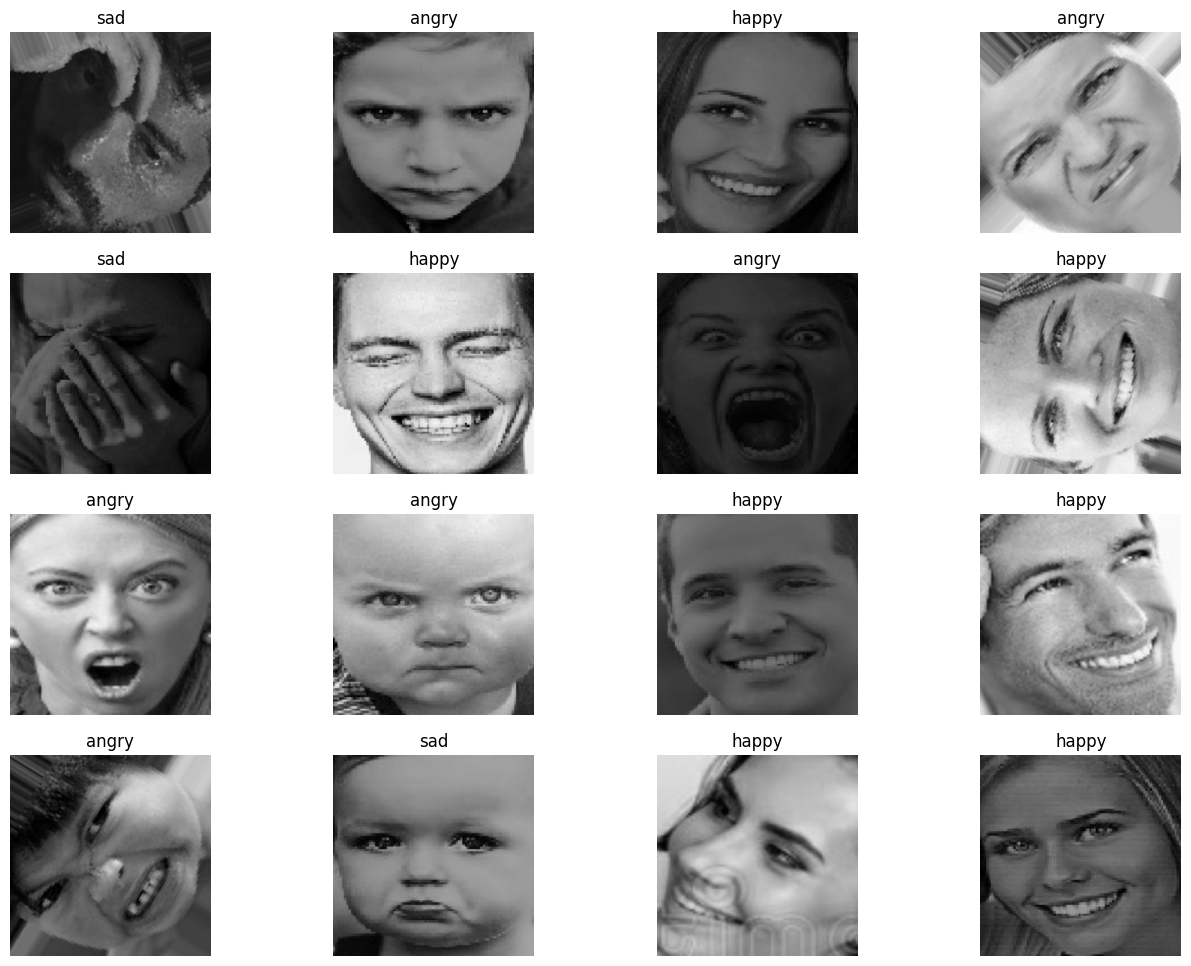

In [ ]:
plt.figure(figsize = (16,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"]
     [tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# **Data augmentation**

In [ ]:
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

In [ ]:
training_dataset = (
    train_dataset.take(100)
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

# **Modeling**

## **Transfer Learning with EfficientNet**

In [ ]:
backbone_EfficientNetB4 = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
backbone_EfficientNetB4.trainable = False

In [ ]:
pretrained_model_EfficientNetB4 = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone_EfficientNetB4,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model_EfficientNetB4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

## **Transfer Learning with MobileNetV2**

In [ ]:
backbone_MobileNetV2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
backbone_MobileNetV2.trainable = False

In [ ]:
pretrained_model_MobileNetV2 = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone_MobileNetV2,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model_MobileNetV2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                      

## **Callbacks**

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,)

In [ ]:
class LogResultsTable(Callback):
    def __init__(self, val_data, class_names, model):
        super().__init__()
        self.validation_data = val_data
        self.class_names = class_names
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        columns = ["Image", "Predicted", "Label"]
        val_table = wandb.Table(columns=columns)

        for images, labels in self.validation_data.take(25):
            # Si la forme de 'images' est (1, 256, 256, 3), utilisez images[0] pour enlever la dimension de batch superflue
            preds = self.model.predict(images)  # 'images' devrait être de forme (256, 256, 3)
            pred_class_idx = tf.argmax(preds, axis=-1).numpy()[0]
            true_class_idx = tf.argmax(labels, axis=-1).numpy()[0]

            pred = self.class_names[pred_class_idx]
            true_label = self.class_names[true_class_idx]

            row = [wandb.Image(images.numpy()), pred, true_label]  # Assurez-vous que 'images' n'a pas de dimension de batch superflue
            val_table.add_data(*row)

        wandb.log({f"Model Results Epoch {epoch+1}": val_table})


# **Training**

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

## **pretrained_model_EfficientNetB4**

In [ ]:
pretrained_model_EfficientNetB4.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
history = pretrained_model_EfficientNetB4.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  callbacks = [WandbCallback(),
               ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
               LogResultsTable(validation_dataset, CONFIGURATION["CLASS_NAMES"], pretrained_model_EfficientNetB4)

  ]
      #EarlyStopping(monitor='val_loss', patience=3),#LogConfMatrix(), LogResultsTable()]
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.7475 - top_k_accuracy: 0.9316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240331_172518-87haueom/files/model-best)... Done. 0.4s


100/100 [==============================] - 162s 2s/step - loss: 0.6250 - accuracy: 0.7475 - top_k_accuracy: 0.9316 - val_loss: 0.6215 - val_accuracy: 0.7322 - val_top_k_accuracy: 0.9175
Epoch 2/10
100/100 [==============================] - 71s 696ms/step - loss: 0.5522 - accuracy: 0.7706 - top_k_accuracy: 0.9341 - val_loss: 0.6689 - val_accuracy: 0.7428 - val_top_k_accuracy: 0.9170
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4849 - accuracy: 0.8028 - top_k_accuracy: 0.9506

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240331_172518-87haueom/files/model-best)... Done. 0.3s


100/100 [==============================] - 122s 1s/step - loss: 0.4849 - accuracy: 0.8028 - top_k_accuracy: 0.9506 - val_loss: 0.5970 - val_accuracy: 0.7634 - val_top_k_accuracy: 0.9289
Epoch 4/10
100/100 [==============================] - 71s 705ms/step - loss: 0.4532 - accuracy: 0.8241 - top_k_accuracy: 0.9591 - val_loss: 0.6837 - val_accuracy: 0.7239 - val_top_k_accuracy: 0.9263
Epoch 5/10
100/100 [==============================] - 66s 649ms/step - loss: 0.4223 - accuracy: 0.8241 - top_k_accuracy: 0.9616 - val_loss: 0.6096 - val_accuracy: 0.7616 - val_top_k_accuracy: 0.9258
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.3852 - accuracy: 0.8459 - top_k_accuracy: 0.9647

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240331_172518-87haueom/files/model-best)... Done. 0.4s


100/100 [==============================] - 123s 1s/step - loss: 0.3852 - accuracy: 0.8459 - top_k_accuracy: 0.9647 - val_loss: 0.5910 - val_accuracy: 0.7709 - val_top_k_accuracy: 0.9267
Epoch 7/10
100/100 [==============================] - 71s 707ms/step - loss: 0.3460 - accuracy: 0.8584 - top_k_accuracy: 0.9706 - val_loss: 0.6924 - val_accuracy: 0.7471 - val_top_k_accuracy: 0.9311
Epoch 8/10
100/100 [==============================] - 71s 706ms/step - loss: 0.3342 - accuracy: 0.8669 - top_k_accuracy: 0.9747 - val_loss: 0.6234 - val_accuracy: 0.7818 - val_top_k_accuracy: 0.9342
Epoch 9/10
100/100 [==============================] - 69s 685ms/step - loss: 0.3320 - accuracy: 0.8731 - top_k_accuracy: 0.9750 - val_loss: 0.6653 - val_accuracy: 0.7599 - val_top_k_accuracy: 0.9241
Epoch 10/10
100/100 [==============================] - 114s 1s/step - loss: 0.3091 - accuracy: 0.8828 - top_k_accuracy: 0.9775 - val_loss: 0.6343 - val_accuracy: 0.7748 - val_top_k_accuracy: 0.9284


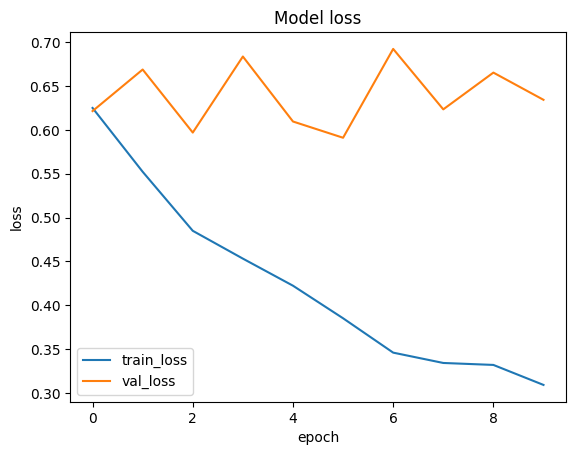

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

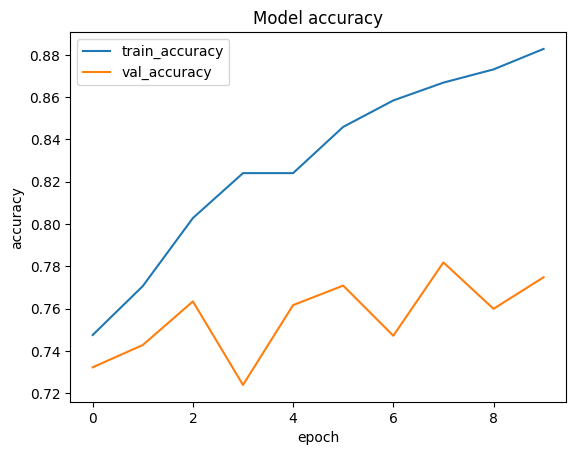

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrained_model_EfficientNetB4.save("/content/drive/MyDrive/Bang/EfficientNetB4_keras.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## **pretrained_model_MobileNetV2**

In [ ]:
pretrained_model_MobileNetV2.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = pretrained_model_MobileNetV2.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  callbacks = [WandbCallback(),
               ModelCheckpoint(filepath='best_MobileNetV2_model.h5', monitor='val_loss', save_best_only=True),
               LogResultsTable(validation_dataset, CONFIGURATION["CLASS_NAMES"], pretrained_model_MobileNetV2)


  ])

Epoch 1/10
100/100 [==============================] - 50s 440ms/step - loss: 1.1373 - accuracy: 0.6407 - top_k_accuracy: 0.8682 - val_loss: 0.9992 - val_accuracy: 0.5505 - val_top_k_accuracy: 0.8077
Epoch 2/10
100/100 [==============================] - 41s 404ms/step - loss: 0.9252 - accuracy: 0.6056 - top_k_accuracy: 0.8616 - val_loss: 0.9303 - val_accuracy: 0.6089 - val_top_k_accuracy: 0.8547
Epoch 3/10
100/100 [==============================] - 43s 421ms/step - loss: 0.8499 - accuracy: 0.6272 - top_k_accuracy: 0.8741 - val_loss: 0.8789 - val_accuracy: 0.6097 - val_top_k_accuracy: 0.8679
Epoch 4/10
100/100 [==============================] - 40s 398ms/step - loss: 0.7954 - accuracy: 0.6597 - top_k_accuracy: 0.8894 - val_loss: 0.9184 - val_accuracy: 0.5825 - val_top_k_accuracy: 0.8543
Epoch 5/10
100/100 [==============================] - 46s 454ms/step - loss: 0.7240 - accuracy: 0.6847 - top_k_accuracy: 0.8931 - val_loss: 0.8430 - val_accuracy: 0.6238 - val_top_k_accuracy: 0.8525
Epoch

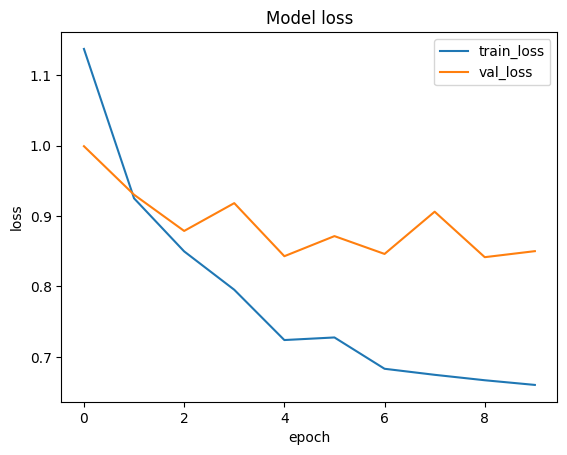

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

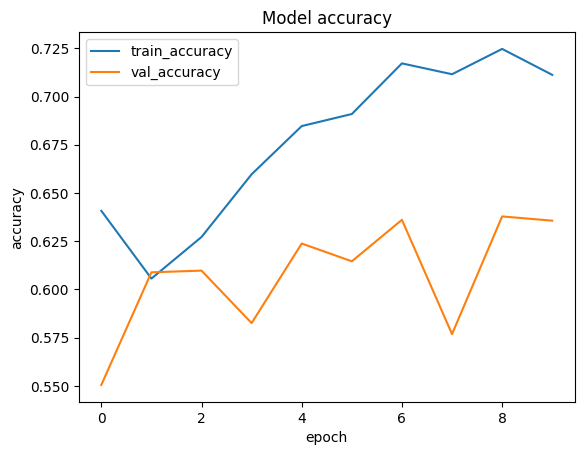

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrained_model_MobileNetV2.save("/content/drive/MyDrive/Bang/MobileNetV2_keras.h5")

# Evaluation

In [ ]:
pretrained_model_EfficientNetB4.evaluate(validation_dataset)

2278/2278 [==============================] - 43s 19ms/step - loss: 0.6343 - accuracy: 0.7748 - top_k_accuracy: 0.9284


[0.6343126893043518, 0.7748024463653564, 0.9284459948539734]

In [ ]:
pretrained_model_MobileNetV2.evaluate(validation_dataset)

2278/2278 [==============================] - 19s 8ms/step - loss: 0.8502 - accuracy: 0.6356 - top_k_accuracy: 0.8630


[0.8501749634742737, 0.63564532995224, 0.8630377650260925]

# Testing

## pretrained_model_EfficientNetB4

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(pretrained_model_EfficientNetB4(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model_EfficientNetB4(im), axis = -1).numpy()[0]])

tf.Tensor([[0.19824715 0.0349333  0.76681954]], shape=(1, 3), dtype=float32)
sad


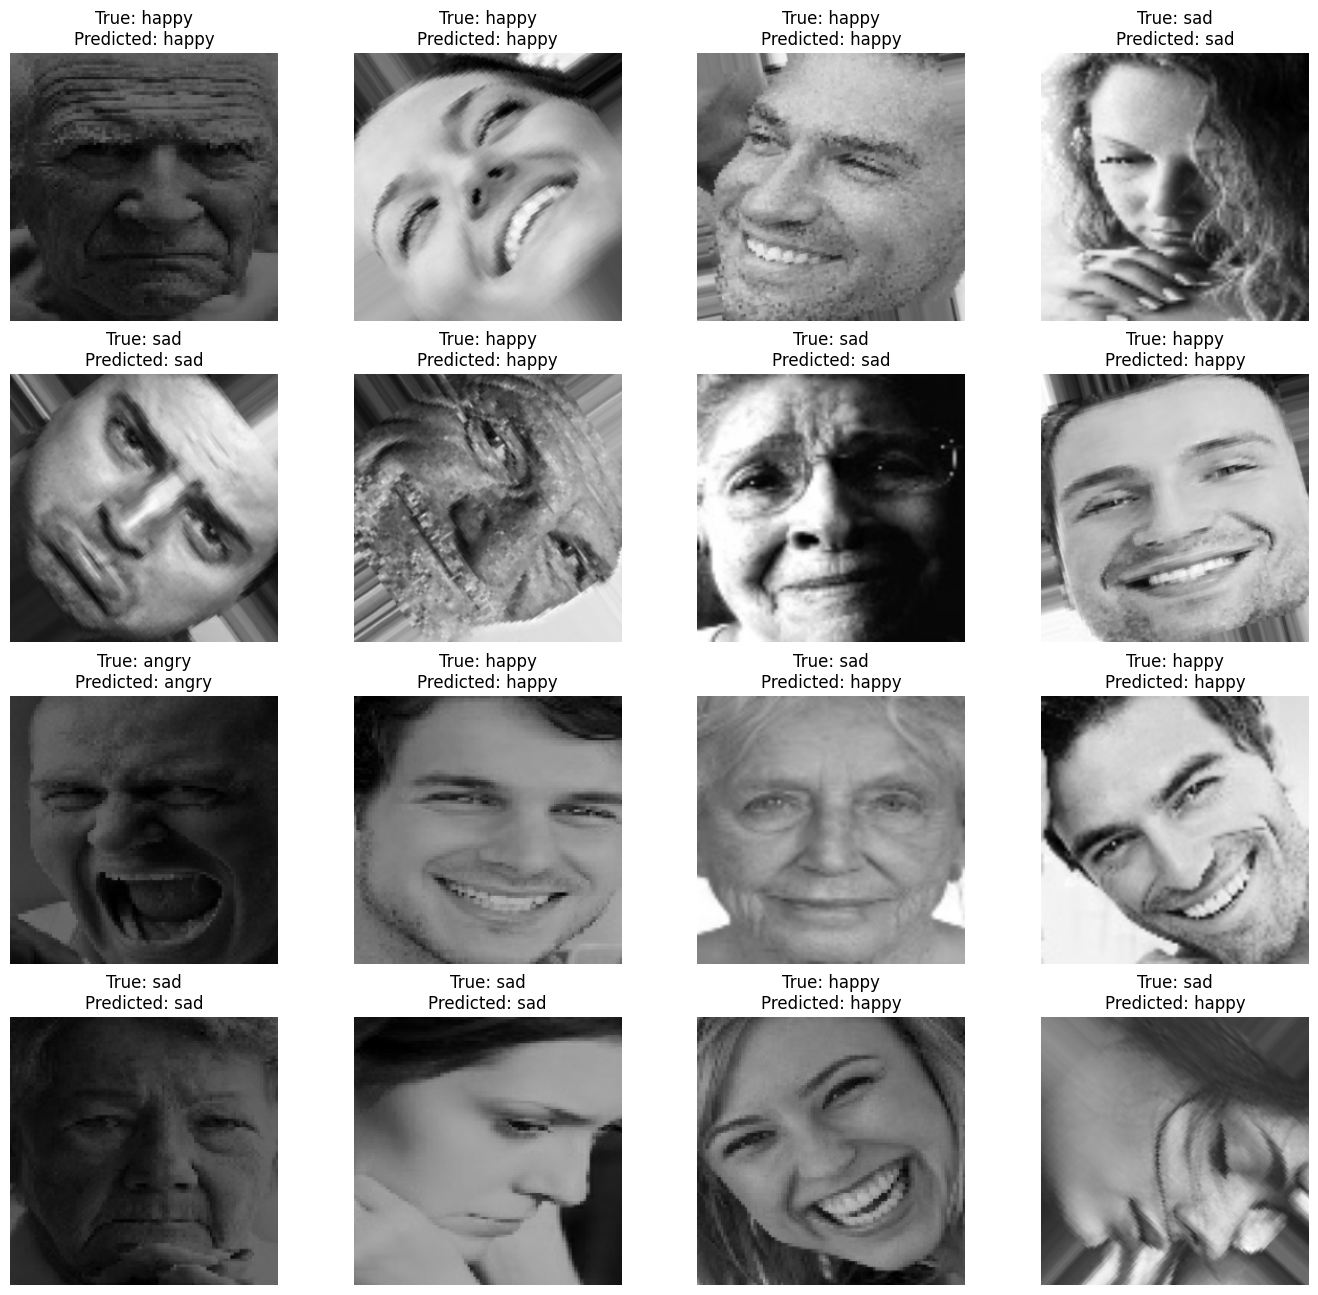

In [ ]:
plt.figure(figsize=(17, 16))

batch_index = 0
for images, labels in validation_dataset.take(16):
    for i in range(len(images)):
        ax = plt.subplot(4, 4, batch_index * len(images) + i + 1)
        plt.imshow(images[i] / 255.)

        true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=-1).numpy()]
        predicted_label = CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model_EfficientNetB4(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0])]

        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis("off")

    batch_index += 1
    if batch_index * len(images) >= 16:
        break


### **Confusion Matrix**

Processing validation data:   0%|          | 0/2278 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:   0%|          | 1/2278 [00:00<07:46,  4.89it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:   0%|          | 2/2278 [00:00<06:59,  5.43it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:   0%|          | 3/2278 [00:00<07:13,  5.25it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:   0%|          | 4/2278 [00:00<06:51,  5.52it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:   0%|          | 5/2278 [00:00<06:22,  5.95it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:   0%|          | 6/2278 [00:01<06:12,  6.10it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:   0%|          | 7/2278 [00:01<06:19,  5.98it/s]

1/1 [==============================] - 0s 76ms/step


Processing validation data:   0%|          | 8/2278 [00:01<06:16,  6.03it/s]

1/1 [==============================] - 0s 112ms/step


Processing validation data:   0%|          | 9/2278 [00:01<06:43,  5.62it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:   0%|          | 10/2278 [00:01<07:21,  5.14it/s]

1/1 [==============================] - 0s 109ms/step


Processing validation data:   0%|          | 11/2278 [00:02<07:18,  5.17it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   1%|          | 13/2278 [00:02<05:26,  6.94it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   1%|          | 15/2278 [00:02<04:26,  8.49it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   1%|          | 16/2278 [00:02<04:35,  8.22it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   1%|          | 18/2278 [00:02<04:04,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   1%|          | 19/2278 [00:02<04:13,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   1%|          | 20/2278 [00:02<04:19,  8.70it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   1%|          | 22/2278 [00:03<03:46,  9.94it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   1%|          | 24/2278 [00:03<03:49,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   1%|          | 25/2278 [00:03<04:05,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:   1%|          | 27/2278 [00:03<04:04,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   1%|          | 28/2278 [00:03<04:13,  8.88it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:   1%|▏         | 29/2278 [00:03<04:34,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:   1%|▏         | 31/2278 [00:04<03:58,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   1%|▏         | 33/2278 [00:04<03:36, 10.38it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   2%|▏         | 35/2278 [00:04<03:27, 10.81it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   2%|▏         | 37/2278 [00:04<03:49,  9.75it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   2%|▏         | 39/2278 [00:04<03:38, 10.25it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   2%|▏         | 41/2278 [00:05<03:40, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   2%|▏         | 43/2278 [00:05<03:41, 10.07it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   2%|▏         | 45/2278 [00:05<03:47,  9.80it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   2%|▏         | 47/2278 [00:05<03:36, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   2%|▏         | 49/2278 [00:05<03:40, 10.10it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:   2%|▏         | 51/2278 [00:06<04:28,  8.30it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:   2%|▏         | 52/2278 [00:06<04:42,  7.87it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:   2%|▏         | 53/2278 [00:06<04:56,  7.50it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:   2%|▏         | 54/2278 [00:06<05:06,  7.25it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:   2%|▏         | 55/2278 [00:06<05:16,  7.03it/s]

1/1 [==============================] - 0s 120ms/step


Processing validation data:   2%|▏         | 56/2278 [00:07<06:19,  5.85it/s]

1/1 [==============================] - 0s 133ms/step


Processing validation data:   3%|▎         | 57/2278 [00:07<07:27,  4.97it/s]

1/1 [==============================] - 0s 99ms/step


Processing validation data:   3%|▎         | 58/2278 [00:07<08:35,  4.31it/s]

1/1 [==============================] - 0s 177ms/step


Processing validation data:   3%|▎         | 59/2278 [00:07<09:55,  3.73it/s]

1/1 [==============================] - 0s 277ms/step


Processing validation data:   3%|▎         | 60/2278 [00:08<12:38,  2.92it/s]

1/1 [==============================] - 0s 130ms/step


Processing validation data:   3%|▎         | 61/2278 [00:08<13:09,  2.81it/s]

1/1 [==============================] - 0s 94ms/step


Processing validation data:   3%|▎         | 62/2278 [00:09<12:48,  2.88it/s]

1/1 [==============================] - 0s 116ms/step


Processing validation data:   3%|▎         | 63/2278 [00:09<11:36,  3.18it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:   3%|▎         | 64/2278 [00:09<10:04,  3.66it/s]

1/1 [==============================] - 0s 111ms/step


Processing validation data:   3%|▎         | 65/2278 [00:09<10:08,  3.63it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:   3%|▎         | 66/2278 [00:10<09:56,  3.71it/s]

1/1 [==============================] - 0s 99ms/step


Processing validation data:   3%|▎         | 67/2278 [00:10<10:52,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:   3%|▎         | 68/2278 [00:10<09:36,  3.83it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:   3%|▎         | 69/2278 [00:10<09:26,  3.90it/s]

1/1 [==============================] - 0s 101ms/step


Processing validation data:   3%|▎         | 70/2278 [00:11<09:57,  3.70it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:   3%|▎         | 71/2278 [00:11<08:52,  4.14it/s]

1/1 [==============================] - 0s 114ms/step


Processing validation data:   3%|▎         | 72/2278 [00:11<09:25,  3.90it/s]

1/1 [==============================] - 0s 97ms/step


Processing validation data:   3%|▎         | 73/2278 [00:11<09:33,  3.85it/s]

1/1 [==============================] - 0s 96ms/step


Processing validation data:   3%|▎         | 74/2278 [00:12<08:39,  4.24it/s]

1/1 [==============================] - 0s 87ms/step


Processing validation data:   3%|▎         | 75/2278 [00:12<09:00,  4.08it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:   3%|▎         | 76/2278 [00:12<09:40,  3.79it/s]

1/1 [==============================] - 0s 98ms/step


Processing validation data:   3%|▎         | 77/2278 [00:12<09:02,  4.06it/s]

1/1 [==============================] - 0s 104ms/step


Processing validation data:   3%|▎         | 78/2278 [00:13<09:35,  3.82it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:   3%|▎         | 79/2278 [00:13<08:42,  4.21it/s]

1/1 [==============================] - 0s 77ms/step


Processing validation data:   4%|▎         | 80/2278 [00:13<08:25,  4.35it/s]

1/1 [==============================] - 0s 80ms/step


Processing validation data:   4%|▎         | 81/2278 [00:13<08:21,  4.38it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:   4%|▎         | 82/2278 [00:14<08:44,  4.19it/s]

1/1 [==============================] - 0s 118ms/step


Processing validation data:   4%|▎         | 83/2278 [00:14<09:45,  3.75it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   4%|▎         | 85/2278 [00:14<06:41,  5.46it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:   4%|▍         | 86/2278 [00:14<06:21,  5.74it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:   4%|▍         | 87/2278 [00:14<06:10,  5.92it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:   4%|▍         | 88/2278 [00:15<06:03,  6.02it/s]

1/1 [==============================] - 0s 102ms/step


Processing validation data:   4%|▍         | 89/2278 [00:15<06:20,  5.75it/s]

1/1 [==============================] - 0s 92ms/step


Processing validation data:   4%|▍         | 90/2278 [00:15<07:57,  4.58it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:   4%|▍         | 91/2278 [00:15<07:28,  4.88it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:   4%|▍         | 92/2278 [00:15<06:53,  5.29it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:   4%|▍         | 93/2278 [00:16<06:31,  5.58it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:   4%|▍         | 94/2278 [00:16<06:28,  5.62it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:   4%|▍         | 95/2278 [00:16<06:03,  6.00it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:   4%|▍         | 96/2278 [00:16<05:44,  6.34it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:   4%|▍         | 97/2278 [00:16<05:47,  6.27it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:   4%|▍         | 98/2278 [00:16<05:49,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:   4%|▍         | 99/2278 [00:17<05:48,  6.25it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:   4%|▍         | 100/2278 [00:17<05:49,  6.24it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:   4%|▍         | 101/2278 [00:17<05:47,  6.26it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:   4%|▍         | 102/2278 [00:17<05:48,  6.24it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:   5%|▍         | 103/2278 [00:17<05:26,  6.65it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   5%|▍         | 104/2278 [00:17<05:22,  6.75it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   5%|▍         | 106/2278 [00:17<04:35,  7.89it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   5%|▍         | 108/2278 [00:18<03:59,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   5%|▍         | 110/2278 [00:18<03:58,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   5%|▍         | 112/2278 [00:18<03:38,  9.91it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   5%|▌         | 114/2278 [00:18<03:37,  9.97it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:   5%|▌         | 115/2278 [00:18<04:01,  8.97it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:   5%|▌         | 116/2278 [00:19<04:27,  8.07it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:   5%|▌         | 117/2278 [00:19<04:26,  8.12it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:   5%|▌         | 118/2278 [00:19<04:45,  7.57it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:   5%|▌         | 119/2278 [00:19<04:35,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:   5%|▌         | 120/2278 [00:19<04:29,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:   5%|▌         | 121/2278 [00:19<04:42,  7.63it/s]

1/1 [==============================] - 0s 76ms/step


Processing validation data:   5%|▌         | 122/2278 [00:19<05:19,  6.74it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:   5%|▌         | 123/2278 [00:20<05:43,  6.28it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:   5%|▌         | 124/2278 [00:20<05:18,  6.76it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:   5%|▌         | 125/2278 [00:20<05:10,  6.92it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:   6%|▌         | 126/2278 [00:20<05:00,  7.16it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:   6%|▌         | 127/2278 [00:20<05:06,  7.01it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:   6%|▌         | 128/2278 [00:20<05:13,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   6%|▌         | 130/2278 [00:20<04:11,  8.53it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   6%|▌         | 132/2278 [00:21<03:44,  9.56it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   6%|▌         | 134/2278 [00:21<03:42,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   6%|▌         | 136/2278 [00:21<03:25, 10.42it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   6%|▌         | 138/2278 [00:21<03:29, 10.24it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   6%|▌         | 140/2278 [00:21<03:15, 10.92it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:   6%|▌         | 142/2278 [00:22<03:25, 10.39it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   6%|▋         | 144/2278 [00:22<03:31, 10.10it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   6%|▋         | 146/2278 [00:22<03:30, 10.11it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   6%|▋         | 148/2278 [00:22<03:16, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   7%|▋         | 150/2278 [00:22<03:08, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   7%|▋         | 152/2278 [00:22<03:03, 11.56it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   7%|▋         | 154/2278 [00:23<03:29, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   7%|▋         | 156/2278 [00:23<03:17, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   7%|▋         | 158/2278 [00:23<03:10, 11.12it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   7%|▋         | 160/2278 [00:23<03:05, 11.45it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   7%|▋         | 162/2278 [00:23<03:05, 11.42it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:   7%|▋         | 164/2278 [00:24<03:14, 10.88it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   7%|▋         | 166/2278 [00:24<03:36,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   7%|▋         | 168/2278 [00:24<03:23, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   7%|▋         | 170/2278 [00:24<03:13, 10.87it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   8%|▊         | 172/2278 [00:24<03:08, 11.18it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   8%|▊         | 174/2278 [00:25<03:17, 10.63it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:   8%|▊         | 176/2278 [00:25<03:14, 10.79it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   8%|▊         | 178/2278 [00:25<03:06, 11.25it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:   8%|▊         | 180/2278 [00:25<03:14, 10.80it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   8%|▊         | 182/2278 [00:25<03:10, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   8%|▊         | 184/2278 [00:25<03:03, 11.38it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   8%|▊         | 186/2278 [00:26<03:13, 10.79it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:   8%|▊         | 188/2278 [00:26<03:35,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   8%|▊         | 190/2278 [00:26<03:36,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   8%|▊         | 192/2278 [00:26<03:23, 10.27it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   9%|▊         | 194/2278 [00:26<03:14, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   9%|▊         | 196/2278 [00:27<03:19, 10.43it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   9%|▊         | 198/2278 [00:27<03:24, 10.18it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   9%|▉         | 200/2278 [00:27<03:14, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   9%|▉         | 202/2278 [00:27<03:07, 11.09it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:   9%|▉         | 204/2278 [00:27<03:26, 10.05it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   9%|▉         | 206/2278 [00:28<03:41,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:   9%|▉         | 207/2278 [00:28<03:47,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:   9%|▉         | 208/2278 [00:28<03:46,  9.14it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:   9%|▉         | 209/2278 [00:28<04:08,  8.32it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   9%|▉         | 210/2278 [00:28<04:14,  8.12it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   9%|▉         | 212/2278 [00:28<03:39,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   9%|▉         | 213/2278 [00:28<03:46,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   9%|▉         | 215/2278 [00:29<03:39,  9.40it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  10%|▉         | 217/2278 [00:29<03:26,  9.99it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  10%|▉         | 219/2278 [00:29<03:15, 10.55it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  10%|▉         | 221/2278 [00:29<03:06, 11.05it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  10%|▉         | 223/2278 [00:29<02:57, 11.55it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  10%|▉         | 225/2278 [00:30<03:05, 11.06it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  10%|▉         | 227/2278 [00:30<03:05, 11.05it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  10%|█         | 229/2278 [00:30<03:18, 10.30it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  10%|█         | 231/2278 [00:30<03:19, 10.25it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  10%|█         | 233/2278 [00:30<03:07, 10.92it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  10%|█         | 235/2278 [00:31<03:41,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  10%|█         | 236/2278 [00:31<03:58,  8.56it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  10%|█         | 237/2278 [00:31<04:06,  8.28it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  10%|█         | 238/2278 [00:31<04:20,  7.84it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  10%|█         | 239/2278 [00:31<04:16,  7.95it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  11%|█         | 240/2278 [00:31<04:25,  7.69it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  11%|█         | 241/2278 [00:31<04:34,  7.42it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  11%|█         | 242/2278 [00:32<04:41,  7.23it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  11%|█         | 243/2278 [00:32<04:36,  7.36it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  11%|█         | 244/2278 [00:32<04:55,  6.89it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  11%|█         | 245/2278 [00:32<04:46,  7.10it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  11%|█         | 246/2278 [00:32<04:55,  6.87it/s]

1/1 [==============================] - 0s 71ms/step


Processing validation data:  11%|█         | 247/2278 [00:32<05:34,  6.07it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  11%|█         | 249/2278 [00:33<04:38,  7.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  11%|█         | 250/2278 [00:33<04:30,  7.49it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  11%|█         | 252/2278 [00:33<03:43,  9.05it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  11%|█         | 253/2278 [00:33<03:59,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  11%|█         | 255/2278 [00:33<03:34,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  11%|█         | 256/2278 [00:33<03:42,  9.07it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  11%|█▏        | 258/2278 [00:33<03:24,  9.89it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  11%|█▏        | 260/2278 [00:34<03:24,  9.86it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  12%|█▏        | 262/2278 [00:34<03:25,  9.80it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  12%|█▏        | 264/2278 [00:34<03:15, 10.32it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  12%|█▏        | 266/2278 [00:34<03:05, 10.85it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  12%|█▏        | 268/2278 [00:34<03:18, 10.15it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 270/2278 [00:35<03:20, 10.02it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 272/2278 [00:35<03:10, 10.53it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  12%|█▏        | 274/2278 [00:35<03:05, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 276/2278 [00:35<02:59, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 278/2278 [00:35<02:55, 11.40it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 280/2278 [00:36<02:53, 11.51it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  12%|█▏        | 282/2278 [00:36<03:04, 10.85it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 284/2278 [00:36<02:56, 11.29it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  13%|█▎        | 286/2278 [00:36<02:55, 11.33it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  13%|█▎        | 288/2278 [00:36<03:03, 10.82it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  13%|█▎        | 290/2278 [00:36<03:18, 10.01it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  13%|█▎        | 292/2278 [00:37<03:26,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  13%|█▎        | 294/2278 [00:37<03:15, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  13%|█▎        | 296/2278 [00:37<03:30,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  13%|█▎        | 297/2278 [00:37<03:39,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  13%|█▎        | 298/2278 [00:37<03:36,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  13%|█▎        | 300/2278 [00:38<03:20,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  13%|█▎        | 301/2278 [00:38<03:32,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  13%|█▎        | 302/2278 [00:38<03:43,  8.85it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  13%|█▎        | 304/2278 [00:38<03:41,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  13%|█▎        | 306/2278 [00:38<03:18,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  14%|█▎        | 308/2278 [00:38<03:09, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  14%|█▎        | 310/2278 [00:39<03:13, 10.17it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  14%|█▎        | 312/2278 [00:39<03:26,  9.53it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  14%|█▍        | 314/2278 [00:39<03:10, 10.30it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  14%|█▍        | 316/2278 [00:39<03:19,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  14%|█▍        | 318/2278 [00:42<15:30,  2.11it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  14%|█▍        | 320/2278 [00:42<11:52,  2.75it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  14%|█▍        | 321/2278 [00:42<10:33,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  14%|█▍        | 322/2278 [00:42<09:04,  3.59it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  14%|█▍        | 324/2278 [00:43<07:19,  4.44it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  14%|█▍        | 325/2278 [00:43<07:03,  4.62it/s]

1/1 [==============================] - 0s 88ms/step


Processing validation data:  14%|█▍        | 326/2278 [00:43<06:45,  4.82it/s]

1/1 [==============================] - 0s 82ms/step


Processing validation data:  14%|█▍        | 327/2278 [00:43<06:47,  4.79it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  14%|█▍        | 328/2278 [00:43<06:10,  5.26it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  14%|█▍        | 329/2278 [00:43<05:56,  5.47it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  14%|█▍        | 330/2278 [00:44<05:32,  5.85it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  15%|█▍        | 331/2278 [00:44<05:20,  6.07it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  15%|█▍        | 332/2278 [00:44<05:27,  5.95it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  15%|█▍        | 333/2278 [00:44<05:15,  6.16it/s]

1/1 [==============================] - 0s 78ms/step


Processing validation data:  15%|█▍        | 334/2278 [00:44<05:17,  6.12it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  15%|█▍        | 335/2278 [00:44<05:29,  5.89it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  15%|█▍        | 336/2278 [00:45<05:06,  6.34it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  15%|█▍        | 338/2278 [00:45<04:25,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  15%|█▍        | 340/2278 [00:45<03:49,  8.45it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  15%|█▌        | 342/2278 [00:45<03:39,  8.82it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  15%|█▌        | 343/2278 [00:45<03:43,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  15%|█▌        | 344/2278 [00:45<03:51,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  15%|█▌        | 346/2278 [00:46<03:31,  9.13it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  15%|█▌        | 347/2278 [00:46<03:42,  8.67it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  15%|█▌        | 349/2278 [00:46<03:26,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  15%|█▌        | 351/2278 [00:46<03:27,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  15%|█▌        | 352/2278 [00:46<03:42,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  16%|█▌        | 354/2278 [00:46<03:27,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  16%|█▌        | 356/2278 [00:47<03:15,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  16%|█▌        | 358/2278 [00:47<03:12,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  16%|█▌        | 360/2278 [00:47<03:07, 10.23it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  16%|█▌        | 362/2278 [00:47<03:16,  9.73it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  16%|█▌        | 363/2278 [00:47<03:28,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  16%|█▌        | 365/2278 [00:48<03:30,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  16%|█▌        | 366/2278 [00:48<03:39,  8.71it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  16%|█▌        | 367/2278 [00:48<03:46,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  16%|█▌        | 368/2278 [00:48<03:52,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  16%|█▌        | 370/2278 [00:48<03:34,  8.89it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  16%|█▋        | 371/2278 [00:48<03:45,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  16%|█▋        | 373/2278 [00:49<03:27,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  16%|█▋        | 375/2278 [00:49<03:29,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  17%|█▋        | 376/2278 [00:49<03:37,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  17%|█▋        | 378/2278 [00:49<03:19,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  17%|█▋        | 379/2278 [00:49<03:36,  8.79it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  17%|█▋        | 380/2278 [00:49<03:47,  8.34it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  17%|█▋        | 381/2278 [00:50<04:12,  7.52it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  17%|█▋        | 383/2278 [00:50<03:56,  8.02it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  17%|█▋        | 385/2278 [00:50<03:33,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  17%|█▋        | 387/2278 [00:50<03:15,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  17%|█▋        | 388/2278 [00:50<03:31,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  17%|█▋        | 389/2278 [00:50<03:42,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  17%|█▋        | 391/2278 [00:51<03:21,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  17%|█▋        | 392/2278 [00:51<03:32,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  17%|█▋        | 393/2278 [00:51<03:42,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  17%|█▋        | 395/2278 [00:51<03:22,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  17%|█▋        | 397/2278 [00:51<03:29,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  17%|█▋        | 398/2278 [00:51<03:38,  8.59it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  18%|█▊        | 399/2278 [00:52<03:33,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  18%|█▊        | 400/2278 [00:52<03:54,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 402/2278 [00:52<03:26,  9.08it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 403/2278 [00:52<03:37,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  18%|█▊        | 405/2278 [00:52<03:19,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  18%|█▊        | 406/2278 [00:52<03:19,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  18%|█▊        | 407/2278 [00:52<03:31,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 409/2278 [00:53<03:14,  9.61it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 411/2278 [00:53<03:05, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  18%|█▊        | 413/2278 [00:53<02:57, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  18%|█▊        | 415/2278 [00:53<02:58, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 417/2278 [00:53<03:06,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  18%|█▊        | 419/2278 [00:54<03:02, 10.21it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  18%|█▊        | 421/2278 [00:54<03:15,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  19%|█▊        | 423/2278 [00:54<03:16,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  19%|█▊        | 425/2278 [00:54<03:07,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  19%|█▊        | 427/2278 [00:54<03:01, 10.21it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  19%|█▉        | 429/2278 [00:55<03:18,  9.33it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  19%|█▉        | 430/2278 [00:55<03:28,  8.86it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  19%|█▉        | 431/2278 [00:55<03:47,  8.13it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  19%|█▉        | 432/2278 [00:55<04:04,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  19%|█▉        | 433/2278 [00:55<04:26,  6.92it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  19%|█▉        | 434/2278 [00:55<04:14,  7.24it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  19%|█▉        | 435/2278 [00:56<04:13,  7.26it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  19%|█▉        | 436/2278 [00:56<04:13,  7.27it/s]

1/1 [==============================] - 0s 84ms/step


Processing validation data:  19%|█▉        | 437/2278 [00:56<04:28,  6.85it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  19%|█▉        | 438/2278 [00:56<05:01,  6.10it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  19%|█▉        | 439/2278 [00:56<04:42,  6.51it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  19%|█▉        | 440/2278 [00:56<04:47,  6.39it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  19%|█▉        | 441/2278 [00:56<04:54,  6.23it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:  19%|█▉        | 442/2278 [00:57<05:01,  6.10it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  19%|█▉        | 444/2278 [00:57<04:01,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  20%|█▉        | 446/2278 [00:57<03:44,  8.16it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  20%|█▉        | 448/2278 [00:57<03:34,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  20%|█▉        | 449/2278 [00:57<03:39,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  20%|█▉        | 451/2278 [00:58<03:27,  8.80it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  20%|█▉        | 453/2278 [00:58<03:11,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  20%|█▉        | 455/2278 [00:58<03:01, 10.02it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  20%|██        | 456/2278 [00:58<03:12,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  20%|██        | 458/2278 [00:58<03:12,  9.44it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  20%|██        | 460/2278 [00:59<03:07,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  20%|██        | 461/2278 [00:59<03:06,  9.73it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  20%|██        | 463/2278 [00:59<02:57, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  20%|██        | 465/2278 [00:59<03:04,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  20%|██        | 466/2278 [00:59<03:15,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  21%|██        | 468/2278 [00:59<03:00, 10.05it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  21%|██        | 469/2278 [00:59<03:17,  9.18it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  21%|██        | 471/2278 [01:00<03:20,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  21%|██        | 472/2278 [01:00<03:29,  8.63it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  21%|██        | 474/2278 [01:00<03:13,  9.32it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  21%|██        | 476/2278 [01:00<03:14,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  21%|██        | 477/2278 [01:00<03:25,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  21%|██        | 478/2278 [01:01<03:35,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  21%|██        | 479/2278 [01:01<03:40,  8.15it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  21%|██        | 481/2278 [01:01<03:30,  8.56it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  21%|██        | 483/2278 [01:01<03:23,  8.83it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  21%|██▏       | 485/2278 [01:01<03:07,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  21%|██▏       | 487/2278 [01:01<03:12,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  21%|██▏       | 488/2278 [01:02<03:20,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  22%|██▏       | 490/2278 [01:02<03:09,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  22%|██▏       | 492/2278 [01:02<02:58,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  22%|██▏       | 493/2278 [01:02<03:08,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  22%|██▏       | 495/2278 [01:02<03:07,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  22%|██▏       | 496/2278 [01:02<03:16,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  22%|██▏       | 498/2278 [01:03<03:04,  9.67it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  22%|██▏       | 499/2278 [01:03<03:20,  8.89it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  22%|██▏       | 500/2278 [01:03<03:26,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  22%|██▏       | 502/2278 [01:03<03:21,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  22%|██▏       | 504/2278 [01:03<03:17,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  22%|██▏       | 505/2278 [01:03<03:13,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  22%|██▏       | 506/2278 [01:04<03:22,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  22%|██▏       | 507/2278 [01:04<03:30,  8.41it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  22%|██▏       | 508/2278 [01:04<03:37,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  22%|██▏       | 510/2278 [01:04<03:13,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  22%|██▏       | 512/2278 [01:04<02:56,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  23%|██▎       | 514/2278 [01:04<03:05,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  23%|██▎       | 515/2278 [01:05<03:09,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  23%|██▎       | 517/2278 [01:05<02:59,  9.78it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  23%|██▎       | 519/2278 [01:05<02:51, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  23%|██▎       | 521/2278 [01:05<03:07,  9.39it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  23%|██▎       | 523/2278 [01:05<03:08,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  23%|██▎       | 525/2278 [01:06<02:55,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  23%|██▎       | 527/2278 [01:06<02:59,  9.75it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  23%|██▎       | 528/2278 [01:06<03:07,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  23%|██▎       | 530/2278 [01:06<02:53, 10.10it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  23%|██▎       | 532/2278 [01:06<02:48, 10.37it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  23%|██▎       | 534/2278 [01:06<02:47, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  24%|██▎       | 536/2278 [01:07<02:54, 10.00it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  24%|██▎       | 538/2278 [01:07<03:10,  9.12it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  24%|██▎       | 539/2278 [01:07<03:27,  8.39it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  24%|██▎       | 540/2278 [01:07<03:29,  8.29it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  24%|██▎       | 541/2278 [01:07<03:45,  7.69it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  24%|██▍       | 542/2278 [01:07<03:53,  7.42it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  24%|██▍       | 543/2278 [01:08<04:06,  7.04it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:  24%|██▍       | 544/2278 [01:08<04:13,  6.83it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  24%|██▍       | 545/2278 [01:08<04:19,  6.67it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  24%|██▍       | 546/2278 [01:08<04:34,  6.31it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  24%|██▍       | 547/2278 [01:08<04:22,  6.58it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  24%|██▍       | 548/2278 [01:08<04:14,  6.79it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  24%|██▍       | 549/2278 [01:09<04:20,  6.64it/s]

1/1 [==============================] - 0s 118ms/step


Processing validation data:  24%|██▍       | 550/2278 [01:09<05:12,  5.52it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  24%|██▍       | 551/2278 [01:09<04:42,  6.11it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  24%|██▍       | 553/2278 [01:09<03:40,  7.81it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  24%|██▍       | 555/2278 [01:09<03:24,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  24%|██▍       | 557/2278 [01:10<03:03,  9.38it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  25%|██▍       | 559/2278 [01:10<02:55,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  25%|██▍       | 561/2278 [01:10<02:49, 10.12it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  25%|██▍       | 563/2278 [01:10<02:41, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  25%|██▍       | 565/2278 [01:10<02:47, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  25%|██▍       | 567/2278 [01:10<02:41, 10.57it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  25%|██▍       | 569/2278 [01:11<02:42, 10.49it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  25%|██▌       | 571/2278 [01:11<02:50, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  25%|██▌       | 573/2278 [01:11<02:56,  9.68it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  25%|██▌       | 575/2278 [01:11<02:46, 10.20it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  25%|██▌       | 577/2278 [01:11<02:54,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  25%|██▌       | 578/2278 [01:12<03:02,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  25%|██▌       | 579/2278 [01:12<03:11,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  26%|██▌       | 581/2278 [01:12<02:59,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  26%|██▌       | 583/2278 [01:12<02:50,  9.93it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  26%|██▌       | 584/2278 [01:12<03:02,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  26%|██▌       | 586/2278 [01:12<02:56,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  26%|██▌       | 588/2278 [01:13<02:48, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  26%|██▌       | 590/2278 [01:13<02:44, 10.27it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  26%|██▌       | 592/2278 [01:13<02:54,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  26%|██▌       | 594/2278 [01:13<02:59,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  26%|██▌       | 595/2278 [01:13<02:58,  9.44it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  26%|██▌       | 597/2278 [01:14<02:49,  9.93it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  26%|██▋       | 599/2278 [01:14<02:41, 10.39it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  26%|██▋       | 601/2278 [01:14<02:42, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  26%|██▋       | 603/2278 [01:14<02:42, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  27%|██▋       | 605/2278 [01:14<02:40, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  27%|██▋       | 607/2278 [01:15<02:47,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  27%|██▋       | 609/2278 [01:15<02:42, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  27%|██▋       | 611/2278 [01:15<02:40, 10.39it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  27%|██▋       | 613/2278 [01:15<02:56,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  27%|██▋       | 614/2278 [01:15<03:10,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  27%|██▋       | 616/2278 [01:16<03:09,  8.78it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  27%|██▋       | 617/2278 [01:16<03:14,  8.54it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  27%|██▋       | 619/2278 [01:16<02:57,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  27%|██▋       | 621/2278 [01:16<02:57,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  27%|██▋       | 623/2278 [01:16<02:48,  9.81it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  27%|██▋       | 625/2278 [01:16<02:40, 10.27it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  28%|██▊       | 627/2278 [01:17<02:37, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  28%|██▊       | 629/2278 [01:17<02:35, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  28%|██▊       | 631/2278 [01:17<02:33, 10.73it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  28%|██▊       | 633/2278 [01:17<02:35, 10.61it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  28%|██▊       | 635/2278 [01:17<02:54,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  28%|██▊       | 636/2278 [01:18<03:01,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  28%|██▊       | 638/2278 [01:18<02:48,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  28%|██▊       | 640/2278 [01:18<02:40, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  28%|██▊       | 642/2278 [01:18<02:39, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  28%|██▊       | 644/2278 [01:18<02:34, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  28%|██▊       | 646/2278 [01:18<02:42, 10.02it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  28%|██▊       | 648/2278 [01:19<02:44,  9.91it/s]

1/1 [==============================] - 0s 98ms/step


Processing validation data:  28%|██▊       | 649/2278 [01:19<03:38,  7.47it/s]

1/1 [==============================] - 0s 231ms/step


Processing validation data:  29%|██▊       | 650/2278 [01:20<07:11,  3.77it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  29%|██▊       | 651/2278 [01:20<07:13,  3.75it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  29%|██▊       | 652/2278 [01:20<06:35,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  29%|██▊       | 653/2278 [01:20<05:49,  4.64it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  29%|██▊       | 654/2278 [01:20<05:18,  5.10it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  29%|██▉       | 655/2278 [01:21<04:47,  5.65it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  29%|██▉       | 656/2278 [01:21<04:22,  6.17it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  29%|██▉       | 657/2278 [01:21<04:11,  6.45it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  29%|██▉       | 658/2278 [01:21<04:17,  6.29it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:  29%|██▉       | 659/2278 [01:21<04:23,  6.14it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  29%|██▉       | 660/2278 [01:21<04:00,  6.73it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  29%|██▉       | 662/2278 [01:22<03:17,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  29%|██▉       | 664/2278 [01:22<02:58,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  29%|██▉       | 666/2278 [01:22<02:47,  9.63it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  29%|██▉       | 667/2278 [01:22<02:53,  9.29it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  29%|██▉       | 668/2278 [01:22<03:05,  8.68it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  29%|██▉       | 669/2278 [01:22<03:02,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  29%|██▉       | 671/2278 [01:22<03:00,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  30%|██▉       | 673/2278 [01:23<02:48,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  30%|██▉       | 675/2278 [01:23<02:38, 10.12it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  30%|██▉       | 677/2278 [01:23<02:46,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  30%|██▉       | 678/2278 [01:23<02:54,  9.16it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  30%|██▉       | 680/2278 [01:23<02:46,  9.61it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  30%|██▉       | 681/2278 [01:24<02:54,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  30%|██▉       | 683/2278 [01:24<02:41,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  30%|███       | 684/2278 [01:24<02:51,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  30%|███       | 686/2278 [01:24<02:42,  9.78it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  30%|███       | 688/2278 [01:24<02:47,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  30%|███       | 689/2278 [01:24<02:46,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  30%|███       | 690/2278 [01:24<02:57,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  30%|███       | 691/2278 [01:25<03:04,  8.60it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  30%|███       | 692/2278 [01:25<03:09,  8.39it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  30%|███       | 694/2278 [01:25<02:47,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 695/2278 [01:25<02:46,  9.52it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 697/2278 [01:25<02:49,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  31%|███       | 699/2278 [01:25<02:41,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  31%|███       | 701/2278 [01:26<02:45,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 702/2278 [01:26<02:54,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 704/2278 [01:26<02:44,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  31%|███       | 705/2278 [01:26<02:52,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  31%|███       | 706/2278 [01:26<02:59,  8.74it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  31%|███       | 707/2278 [01:26<03:08,  8.34it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 708/2278 [01:26<03:03,  8.57it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  31%|███       | 709/2278 [01:27<03:11,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  31%|███       | 711/2278 [01:27<03:02,  8.59it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  31%|███▏      | 713/2278 [01:27<02:55,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  31%|███▏      | 715/2278 [01:27<02:54,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  31%|███▏      | 717/2278 [01:27<02:55,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  32%|███▏      | 718/2278 [01:28<03:00,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  32%|███▏      | 719/2278 [01:28<03:07,  8.32it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  32%|███▏      | 721/2278 [01:28<02:49,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  32%|███▏      | 722/2278 [01:28<02:49,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  32%|███▏      | 724/2278 [01:28<02:52,  8.99it/s]

1/1 [==============================] - 0s 145ms/step


Processing validation data:  32%|███▏      | 725/2278 [01:29<03:52,  6.67it/s]

1/1 [==============================] - 0s 148ms/step


Processing validation data:  32%|███▏      | 726/2278 [01:29<05:42,  4.53it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  32%|███▏      | 727/2278 [01:29<05:21,  4.83it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  32%|███▏      | 728/2278 [01:29<04:50,  5.33it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  32%|███▏      | 729/2278 [01:29<04:27,  5.79it/s]

1/1 [==============================] - 0s 81ms/step


Processing validation data:  32%|███▏      | 731/2278 [01:30<03:56,  6.54it/s]

1/1 [==============================] - 0s 152ms/step


Processing validation data:  32%|███▏      | 732/2278 [01:30<05:08,  5.01it/s]

1/1 [==============================] - 0s 77ms/step


Processing validation data:  32%|███▏      | 733/2278 [01:30<05:29,  4.68it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  32%|███▏      | 734/2278 [01:30<05:23,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  32%|███▏      | 736/2278 [01:31<04:01,  6.38it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  32%|███▏      | 738/2278 [01:31<03:32,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  32%|███▏      | 739/2278 [01:31<03:28,  7.37it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  32%|███▏      | 740/2278 [01:31<03:16,  7.83it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  33%|███▎      | 742/2278 [01:31<02:52,  8.89it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  33%|███▎      | 743/2278 [01:31<03:01,  8.47it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  33%|███▎      | 744/2278 [01:32<03:22,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  33%|███▎      | 745/2278 [01:32<03:20,  7.66it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  33%|███▎      | 746/2278 [01:32<03:23,  7.51it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  33%|███▎      | 747/2278 [01:32<03:36,  7.08it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  33%|███▎      | 748/2278 [01:32<03:43,  6.85it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  33%|███▎      | 749/2278 [01:32<03:55,  6.49it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  33%|███▎      | 750/2278 [01:33<03:48,  6.69it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  33%|███▎      | 751/2278 [01:33<03:59,  6.38it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  33%|███▎      | 752/2278 [01:33<03:48,  6.68it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  33%|███▎      | 753/2278 [01:33<03:42,  6.84it/s]

1/1 [==============================] - 0s 111ms/step


Processing validation data:  33%|███▎      | 754/2278 [01:33<04:23,  5.77it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  33%|███▎      | 755/2278 [01:33<04:26,  5.71it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  33%|███▎      | 756/2278 [01:33<04:08,  6.14it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  33%|███▎      | 757/2278 [01:34<04:09,  6.09it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  33%|███▎      | 758/2278 [01:34<03:40,  6.88it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  33%|███▎      | 759/2278 [01:34<03:35,  7.04it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  33%|███▎      | 760/2278 [01:34<03:32,  7.13it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  33%|███▎      | 761/2278 [01:34<03:29,  7.25it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  33%|███▎      | 762/2278 [01:34<03:28,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  34%|███▎      | 764/2278 [01:35<03:11,  7.91it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  34%|███▎      | 765/2278 [01:35<03:02,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  34%|███▎      | 766/2278 [01:35<03:08,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  34%|███▎      | 767/2278 [01:35<03:17,  7.65it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 769/2278 [01:35<02:53,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 770/2278 [01:35<03:03,  8.24it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  34%|███▍      | 771/2278 [01:35<03:09,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 772/2278 [01:36<03:12,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  34%|███▍      | 773/2278 [01:36<03:14,  7.73it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 775/2278 [01:36<02:49,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 776/2278 [01:36<02:47,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  34%|███▍      | 778/2278 [01:36<02:38,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  34%|███▍      | 780/2278 [01:36<02:42,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  34%|███▍      | 782/2278 [01:37<02:34,  9.71it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  34%|███▍      | 784/2278 [01:37<02:29,  9.97it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  34%|███▍      | 785/2278 [01:37<02:32,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  35%|███▍      | 787/2278 [01:37<02:26, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  35%|███▍      | 789/2278 [01:37<02:21, 10.49it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  35%|███▍      | 791/2278 [01:37<02:40,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  35%|███▍      | 792/2278 [01:38<02:50,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  35%|███▍      | 793/2278 [01:38<02:48,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  35%|███▍      | 794/2278 [01:38<02:46,  8.89it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  35%|███▍      | 795/2278 [01:38<02:53,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  35%|███▍      | 796/2278 [01:38<02:47,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  35%|███▍      | 797/2278 [01:38<02:49,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  35%|███▌      | 799/2278 [01:38<02:36,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  35%|███▌      | 801/2278 [01:39<02:28,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  35%|███▌      | 802/2278 [01:39<02:40,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  35%|███▌      | 803/2278 [01:39<02:38,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  35%|███▌      | 805/2278 [01:39<02:28,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  35%|███▌      | 807/2278 [01:39<02:23, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▌      | 809/2278 [01:39<02:27,  9.93it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  36%|███▌      | 811/2278 [01:40<02:22, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  36%|███▌      | 813/2278 [01:40<02:38,  9.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▌      | 814/2278 [01:40<02:45,  8.87it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  36%|███▌      | 816/2278 [01:40<02:44,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  36%|███▌      | 818/2278 [01:40<02:41,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  36%|███▌      | 820/2278 [01:41<02:29,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▌      | 821/2278 [01:41<02:39,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  36%|███▌      | 823/2278 [01:41<02:42,  8.98it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  36%|███▌      | 825/2278 [01:41<02:30,  9.63it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  36%|███▋      | 827/2278 [01:41<02:22, 10.20it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  36%|███▋      | 829/2278 [01:42<02:26,  9.92it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▋      | 830/2278 [01:42<02:34,  9.35it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  36%|███▋      | 831/2278 [01:42<02:38,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  37%|███▋      | 832/2278 [01:42<02:55,  8.23it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  37%|███▋      | 834/2278 [01:42<02:35,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  37%|███▋      | 836/2278 [01:42<02:35,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  37%|███▋      | 837/2278 [01:42<02:40,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  37%|███▋      | 839/2278 [01:43<02:32,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  37%|███▋      | 840/2278 [01:43<02:39,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  37%|███▋      | 841/2278 [01:43<02:35,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  37%|███▋      | 843/2278 [01:43<02:24,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  37%|███▋      | 845/2278 [01:43<02:18, 10.37it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  37%|███▋      | 847/2278 [01:43<02:23,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  37%|███▋      | 849/2278 [01:44<02:19, 10.21it/s]

1/1 [==============================] - 0s 95ms/step


Processing validation data:  37%|███▋      | 851/2278 [01:44<02:48,  8.48it/s]

1/1 [==============================] - 0s 96ms/step


Processing validation data:  37%|███▋      | 852/2278 [01:44<03:20,  7.11it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  37%|███▋      | 853/2278 [01:44<03:32,  6.72it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  37%|███▋      | 854/2278 [01:45<03:32,  6.71it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  38%|███▊      | 855/2278 [01:45<03:30,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  38%|███▊      | 856/2278 [01:45<03:32,  6.70it/s]

1/1 [==============================] - 0s 73ms/step


Processing validation data:  38%|███▊      | 857/2278 [01:45<03:30,  6.74it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  38%|███▊      | 858/2278 [01:45<03:44,  6.32it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  38%|███▊      | 859/2278 [01:45<03:42,  6.38it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  38%|███▊      | 860/2278 [01:45<03:46,  6.26it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  38%|███▊      | 861/2278 [01:46<03:50,  6.16it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:  38%|███▊      | 862/2278 [01:46<03:49,  6.18it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  38%|███▊      | 863/2278 [01:46<03:41,  6.38it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  38%|███▊      | 865/2278 [01:46<02:58,  7.91it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  38%|███▊      | 866/2278 [01:46<03:04,  7.65it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  38%|███▊      | 867/2278 [01:46<03:06,  7.58it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  38%|███▊      | 868/2278 [01:46<02:55,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  38%|███▊      | 869/2278 [01:47<02:56,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  38%|███▊      | 871/2278 [01:47<02:34,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  38%|███▊      | 873/2278 [01:47<02:34,  9.11it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  38%|███▊      | 875/2278 [01:47<02:22,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  38%|███▊      | 876/2278 [01:47<02:23,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  38%|███▊      | 877/2278 [01:47<02:33,  9.11it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  39%|███▊      | 879/2278 [01:48<02:20,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  39%|███▊      | 880/2278 [01:48<02:30,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  39%|███▊      | 881/2278 [01:48<02:37,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  39%|███▉      | 883/2278 [01:48<02:26,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  39%|███▉      | 885/2278 [01:48<02:19,  9.97it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  39%|███▉      | 887/2278 [01:48<02:19, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  39%|███▉      | 888/2278 [01:49<02:31,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  39%|███▉      | 890/2278 [01:49<02:20,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  39%|███▉      | 892/2278 [01:49<02:25,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  39%|███▉      | 894/2278 [01:49<02:31,  9.15it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  39%|███▉      | 895/2278 [01:49<02:37,  8.77it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  39%|███▉      | 896/2278 [01:49<02:42,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  39%|███▉      | 898/2278 [01:50<02:27,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  40%|███▉      | 900/2278 [01:50<02:21,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  40%|███▉      | 902/2278 [01:50<02:23,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  40%|███▉      | 904/2278 [01:50<02:26,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  40%|███▉      | 905/2278 [01:50<02:33,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  40%|███▉      | 907/2278 [01:51<02:32,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  40%|███▉      | 909/2278 [01:51<02:23,  9.56it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  40%|███▉      | 911/2278 [01:51<02:17,  9.97it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  40%|████      | 912/2278 [01:51<02:19,  9.79it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  40%|████      | 914/2278 [01:51<02:22,  9.59it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  40%|████      | 916/2278 [01:52<02:14, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  40%|████      | 918/2278 [01:52<02:10, 10.43it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  40%|████      | 920/2278 [01:52<02:16,  9.98it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  40%|████      | 922/2278 [01:52<02:21,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  41%|████      | 924/2278 [01:52<02:22,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  41%|████      | 926/2278 [01:53<02:16,  9.93it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  41%|████      | 928/2278 [01:53<02:19,  9.67it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  41%|████      | 930/2278 [01:53<02:23,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  41%|████      | 932/2278 [01:53<02:24,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  41%|████      | 933/2278 [01:53<02:29,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  41%|████      | 934/2278 [01:53<02:34,  8.69it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  41%|████      | 936/2278 [01:54<02:19,  9.60it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  41%|████      | 938/2278 [01:54<02:12, 10.15it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  41%|████▏     | 940/2278 [01:54<02:09, 10.32it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  41%|████▏     | 942/2278 [01:54<02:06, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  41%|████▏     | 944/2278 [01:54<02:04, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  42%|████▏     | 946/2278 [01:55<02:03, 10.80it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  42%|████▏     | 948/2278 [01:55<02:02, 10.88it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  42%|████▏     | 950/2278 [01:55<02:12, 10.04it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  42%|████▏     | 952/2278 [01:55<02:09, 10.23it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  42%|████▏     | 954/2278 [01:55<02:08, 10.31it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  42%|████▏     | 956/2278 [01:56<02:04, 10.62it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  42%|████▏     | 958/2278 [01:56<02:11, 10.03it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  42%|████▏     | 960/2278 [01:56<02:14,  9.83it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  42%|████▏     | 961/2278 [01:56<02:22,  9.25it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  42%|████▏     | 962/2278 [01:56<02:27,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  42%|████▏     | 963/2278 [01:56<02:43,  8.03it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  42%|████▏     | 964/2278 [01:57<02:53,  7.56it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  42%|████▏     | 965/2278 [01:57<03:00,  7.29it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  42%|████▏     | 966/2278 [01:57<02:55,  7.49it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  42%|████▏     | 967/2278 [01:57<03:02,  7.17it/s]

1/1 [==============================] - 0s 104ms/step


Processing validation data:  42%|████▏     | 968/2278 [01:57<03:30,  6.23it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  43%|████▎     | 969/2278 [01:57<03:31,  6.18it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  43%|████▎     | 970/2278 [01:58<03:34,  6.10it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  43%|████▎     | 971/2278 [01:58<03:35,  6.07it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  43%|████▎     | 972/2278 [01:58<03:24,  6.39it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  43%|████▎     | 973/2278 [01:58<03:32,  6.15it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  43%|████▎     | 974/2278 [01:58<03:21,  6.48it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  43%|████▎     | 975/2278 [01:58<03:11,  6.79it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  43%|████▎     | 976/2278 [01:58<03:11,  6.80it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  43%|████▎     | 978/2278 [01:59<02:50,  7.61it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  43%|████▎     | 980/2278 [01:59<02:27,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  43%|████▎     | 982/2278 [01:59<02:17,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  43%|████▎     | 984/2278 [01:59<02:09, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  43%|████▎     | 985/2278 [01:59<02:18,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  43%|████▎     | 986/2278 [01:59<02:21,  9.13it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  43%|████▎     | 988/2278 [02:00<02:10,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  43%|████▎     | 989/2278 [02:00<02:19,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  43%|████▎     | 990/2278 [02:00<02:25,  8.86it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  44%|████▎     | 992/2278 [02:00<02:11,  9.80it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  44%|████▎     | 994/2278 [02:00<02:05, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  44%|████▎     | 995/2278 [02:00<02:15,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  44%|████▎     | 996/2278 [02:00<02:21,  9.07it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  44%|████▍     | 998/2278 [02:01<02:12,  9.68it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  44%|████▍     | 1000/2278 [02:01<02:05, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  44%|████▍     | 1002/2278 [02:01<02:11,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  44%|████▍     | 1003/2278 [02:01<02:10,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  44%|████▍     | 1005/2278 [02:01<02:04, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  44%|████▍     | 1007/2278 [02:02<02:22,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  44%|████▍     | 1009/2278 [02:02<02:15,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  44%|████▍     | 1010/2278 [02:02<02:23,  8.84it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  44%|████▍     | 1012/2278 [02:02<02:14,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  45%|████▍     | 1014/2278 [02:02<02:15,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  45%|████▍     | 1015/2278 [02:02<02:13,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  45%|████▍     | 1017/2278 [02:03<02:05, 10.07it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  45%|████▍     | 1019/2278 [02:03<02:00, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  45%|████▍     | 1021/2278 [02:03<02:14,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▍     | 1022/2278 [02:03<02:21,  8.87it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▍     | 1024/2278 [02:03<02:09,  9.71it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  45%|████▌     | 1026/2278 [02:04<02:11,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▌     | 1027/2278 [02:04<02:21,  8.86it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▌     | 1028/2278 [02:04<02:25,  8.62it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  45%|████▌     | 1030/2278 [02:04<02:14,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  45%|████▌     | 1032/2278 [02:04<02:06,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▌     | 1034/2278 [02:04<02:11,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  45%|████▌     | 1035/2278 [02:05<02:16,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  46%|████▌     | 1037/2278 [02:05<02:05,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  46%|████▌     | 1038/2278 [02:05<02:12,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  46%|████▌     | 1039/2278 [02:05<02:20,  8.79it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  46%|████▌     | 1040/2278 [02:05<02:26,  8.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  46%|████▌     | 1042/2278 [02:05<02:09,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  46%|████▌     | 1044/2278 [02:06<02:04,  9.93it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  46%|████▌     | 1045/2278 [02:06<02:04,  9.91it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  46%|████▌     | 1046/2278 [02:06<02:20,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  46%|████▌     | 1047/2278 [02:06<02:28,  8.31it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  46%|████▌     | 1048/2278 [02:06<02:32,  8.05it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  46%|████▌     | 1049/2278 [02:06<02:34,  7.98it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  46%|████▌     | 1051/2278 [02:06<02:24,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  46%|████▌     | 1052/2278 [02:07<02:27,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  46%|████▋     | 1054/2278 [02:07<02:20,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  46%|████▋     | 1056/2278 [02:07<02:08,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  46%|████▋     | 1057/2278 [02:07<02:17,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  46%|████▋     | 1059/2278 [02:07<02:05,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  47%|████▋     | 1061/2278 [02:07<02:07,  9.52it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  47%|████▋     | 1062/2278 [02:08<02:17,  8.87it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  47%|████▋     | 1064/2278 [02:08<02:05,  9.64it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  47%|████▋     | 1065/2278 [02:08<02:09,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  47%|████▋     | 1066/2278 [02:08<02:13,  9.11it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  47%|████▋     | 1068/2278 [02:08<02:14,  8.98it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  47%|████▋     | 1069/2278 [02:08<02:16,  8.83it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  47%|████▋     | 1070/2278 [02:09<02:37,  7.69it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  47%|████▋     | 1071/2278 [02:09<02:51,  7.05it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  47%|████▋     | 1072/2278 [02:09<02:53,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  47%|████▋     | 1073/2278 [02:09<02:58,  6.74it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  47%|████▋     | 1074/2278 [02:09<02:51,  7.01it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  47%|████▋     | 1075/2278 [02:09<03:01,  6.64it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  47%|████▋     | 1076/2278 [02:09<03:04,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  47%|████▋     | 1077/2278 [02:10<03:00,  6.65it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  47%|████▋     | 1078/2278 [02:10<03:07,  6.39it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  47%|████▋     | 1079/2278 [02:10<03:12,  6.23it/s]

1/1 [==============================] - 0s 87ms/step


Processing validation data:  47%|████▋     | 1080/2278 [02:10<04:02,  4.94it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  47%|████▋     | 1081/2278 [02:10<03:51,  5.18it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  47%|████▋     | 1082/2278 [02:11<03:27,  5.75it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1084/2278 [02:11<02:45,  7.20it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  48%|████▊     | 1086/2278 [02:11<02:31,  7.87it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1088/2278 [02:11<02:22,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  48%|████▊     | 1090/2278 [02:11<02:08,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1092/2278 [02:12<02:01,  9.80it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  48%|████▊     | 1094/2278 [02:12<01:58,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  48%|████▊     | 1096/2278 [02:12<02:02,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  48%|████▊     | 1098/2278 [02:12<01:57, 10.04it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  48%|████▊     | 1100/2278 [02:12<02:03,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  48%|████▊     | 1102/2278 [02:13<02:07,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1104/2278 [02:13<02:03,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▊     | 1106/2278 [02:13<01:57,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  49%|████▊     | 1108/2278 [02:13<02:08,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  49%|████▊     | 1110/2278 [02:13<02:10,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  49%|████▉     | 1111/2278 [02:14<02:09,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  49%|████▉     | 1112/2278 [02:14<02:16,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1113/2278 [02:14<02:12,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1114/2278 [02:14<02:14,  8.66it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  49%|████▉     | 1115/2278 [02:14<02:21,  8.20it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1117/2278 [02:14<02:16,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  49%|████▉     | 1118/2278 [02:14<02:29,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  49%|████▉     | 1119/2278 [02:15<02:32,  7.60it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  49%|████▉     | 1121/2278 [02:15<02:27,  7.85it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1122/2278 [02:15<02:28,  7.77it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1123/2278 [02:15<02:30,  7.70it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▉     | 1125/2278 [02:15<02:11,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  49%|████▉     | 1127/2278 [02:16<02:04,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  50%|████▉     | 1128/2278 [02:16<02:11,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  50%|████▉     | 1130/2278 [02:16<02:03,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  50%|████▉     | 1132/2278 [02:16<02:00,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  50%|████▉     | 1134/2278 [02:16<01:53, 10.05it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  50%|████▉     | 1136/2278 [02:16<01:57,  9.74it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  50%|████▉     | 1137/2278 [02:17<02:03,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  50%|████▉     | 1138/2278 [02:17<02:13,  8.55it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  50%|█████     | 1139/2278 [02:17<02:18,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  50%|█████     | 1141/2278 [02:17<02:04,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  50%|█████     | 1142/2278 [02:17<02:10,  8.72it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  50%|█████     | 1144/2278 [02:17<02:06,  8.93it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  50%|█████     | 1145/2278 [02:18<02:11,  8.64it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  50%|█████     | 1147/2278 [02:18<01:59,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  50%|█████     | 1148/2278 [02:18<01:58,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  50%|█████     | 1149/2278 [02:18<01:58,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  51%|█████     | 1151/2278 [02:18<01:52, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  51%|█████     | 1153/2278 [02:18<01:47, 10.45it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  51%|█████     | 1155/2278 [02:18<01:53,  9.89it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  51%|█████     | 1157/2278 [02:19<01:55,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  51%|█████     | 1158/2278 [02:19<01:58,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  51%|█████     | 1159/2278 [02:19<01:57,  9.52it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  51%|█████     | 1160/2278 [02:19<02:04,  8.96it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  51%|█████     | 1161/2278 [02:19<02:09,  8.63it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  51%|█████     | 1163/2278 [02:19<01:54,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  51%|█████     | 1165/2278 [02:20<01:56,  9.58it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  51%|█████     | 1167/2278 [02:20<01:51,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  51%|█████▏    | 1169/2278 [02:20<01:56,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  51%|█████▏    | 1171/2278 [02:20<01:50, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  51%|█████▏    | 1173/2278 [02:20<01:58,  9.29it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  52%|█████▏    | 1174/2278 [02:21<02:09,  8.53it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  52%|█████▏    | 1175/2278 [02:21<02:22,  7.74it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  52%|█████▏    | 1176/2278 [02:21<02:33,  7.18it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  52%|█████▏    | 1177/2278 [02:21<02:50,  6.46it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  52%|█████▏    | 1178/2278 [02:21<02:50,  6.44it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  52%|█████▏    | 1179/2278 [02:21<02:51,  6.43it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  52%|█████▏    | 1180/2278 [02:22<02:41,  6.82it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  52%|█████▏    | 1181/2278 [02:22<02:47,  6.56it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  52%|█████▏    | 1182/2278 [02:22<02:36,  7.01it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  52%|█████▏    | 1183/2278 [02:22<02:45,  6.61it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  52%|█████▏    | 1184/2278 [02:22<02:46,  6.58it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  52%|█████▏    | 1185/2278 [02:22<02:54,  6.28it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  52%|█████▏    | 1186/2278 [02:22<02:49,  6.44it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  52%|█████▏    | 1187/2278 [02:23<02:54,  6.24it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  52%|█████▏    | 1188/2278 [02:23<02:48,  6.48it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  52%|█████▏    | 1190/2278 [02:23<02:26,  7.43it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  52%|█████▏    | 1191/2278 [02:23<02:34,  7.04it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  52%|█████▏    | 1193/2278 [02:23<02:11,  8.27it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  52%|█████▏    | 1195/2278 [02:24<01:59,  9.05it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  53%|█████▎    | 1197/2278 [02:24<01:55,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  53%|█████▎    | 1198/2278 [02:24<02:02,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  53%|█████▎    | 1199/2278 [02:24<02:08,  8.42it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  53%|█████▎    | 1200/2278 [02:24<02:05,  8.62it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  53%|█████▎    | 1202/2278 [02:24<01:54,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  53%|█████▎    | 1203/2278 [02:24<02:01,  8.81it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  53%|█████▎    | 1204/2278 [02:25<02:07,  8.44it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  53%|█████▎    | 1206/2278 [02:25<02:04,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  53%|█████▎    | 1207/2278 [02:25<02:07,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  53%|█████▎    | 1208/2278 [02:25<02:10,  8.21it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  53%|█████▎    | 1209/2278 [02:25<02:08,  8.34it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  53%|█████▎    | 1210/2278 [02:25<02:20,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  53%|█████▎    | 1211/2278 [02:25<02:13,  7.97it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  53%|█████▎    | 1213/2278 [02:26<01:58,  8.96it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  53%|█████▎    | 1215/2278 [02:26<01:50,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  53%|█████▎    | 1217/2278 [02:26<01:44, 10.14it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  53%|█████▎    | 1218/2278 [02:26<01:54,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▎    | 1220/2278 [02:26<01:47,  9.87it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  54%|█████▎    | 1222/2278 [02:27<01:50,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▎    | 1224/2278 [02:27<01:44, 10.12it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  54%|█████▍    | 1226/2278 [02:27<01:53,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▍    | 1228/2278 [02:27<01:48,  9.67it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  54%|█████▍    | 1230/2278 [02:27<01:50,  9.45it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▍    | 1231/2278 [02:28<01:53,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  54%|█████▍    | 1233/2278 [02:28<01:48,  9.66it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  54%|█████▍    | 1234/2278 [02:28<01:54,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  54%|█████▍    | 1235/2278 [02:28<01:58,  8.80it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  54%|█████▍    | 1237/2278 [02:28<01:52,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▍    | 1238/2278 [02:28<01:52,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▍    | 1239/2278 [02:28<01:57,  8.85it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  54%|█████▍    | 1241/2278 [02:29<01:47,  9.64it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▍    | 1243/2278 [02:29<01:42, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  55%|█████▍    | 1244/2278 [02:29<01:49,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  55%|█████▍    | 1246/2278 [02:29<01:50,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▍    | 1247/2278 [02:29<01:51,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  55%|█████▍    | 1248/2278 [02:29<01:56,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▍    | 1249/2278 [02:29<01:59,  8.59it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  55%|█████▍    | 1250/2278 [02:30<02:11,  7.82it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  55%|█████▍    | 1252/2278 [02:30<02:05,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▌    | 1254/2278 [02:30<01:51,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  55%|█████▌    | 1256/2278 [02:30<01:55,  8.86it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▌    | 1257/2278 [02:30<01:58,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▌    | 1259/2278 [02:31<01:47,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  55%|█████▌    | 1261/2278 [02:31<01:42,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  55%|█████▌    | 1263/2278 [02:31<01:39, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  56%|█████▌    | 1265/2278 [02:31<01:38, 10.31it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  56%|█████▌    | 1267/2278 [02:31<01:38, 10.26it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  56%|█████▌    | 1269/2278 [02:32<01:35, 10.54it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  56%|█████▌    | 1271/2278 [02:32<01:43,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  56%|█████▌    | 1273/2278 [02:32<01:39, 10.14it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  56%|█████▌    | 1275/2278 [02:32<01:37, 10.24it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  56%|█████▌    | 1277/2278 [02:32<01:47,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  56%|█████▌    | 1278/2278 [02:33<01:51,  8.94it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  56%|█████▌    | 1280/2278 [02:33<01:45,  9.45it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  56%|█████▌    | 1281/2278 [02:33<01:51,  8.95it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  56%|█████▋    | 1282/2278 [02:33<02:02,  8.13it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  56%|█████▋    | 1283/2278 [02:33<02:14,  7.39it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  56%|█████▋    | 1284/2278 [02:33<02:16,  7.29it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  56%|█████▋    | 1285/2278 [02:33<02:11,  7.57it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  56%|█████▋    | 1286/2278 [02:34<02:16,  7.29it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  56%|█████▋    | 1287/2278 [02:34<02:26,  6.78it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:  57%|█████▋    | 1288/2278 [02:34<02:53,  5.72it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  57%|█████▋    | 1289/2278 [02:34<02:49,  5.83it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  57%|█████▋    | 1290/2278 [02:34<02:44,  6.02it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  57%|█████▋    | 1291/2278 [02:34<02:33,  6.43it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  57%|█████▋    | 1292/2278 [02:35<02:33,  6.41it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  57%|█████▋    | 1293/2278 [02:35<02:30,  6.55it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  57%|█████▋    | 1294/2278 [02:35<02:34,  6.37it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  57%|█████▋    | 1295/2278 [02:35<02:30,  6.55it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  57%|█████▋    | 1296/2278 [02:35<02:35,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  57%|█████▋    | 1298/2278 [02:35<02:14,  7.31it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  57%|█████▋    | 1300/2278 [02:36<01:56,  8.41it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  57%|█████▋    | 1301/2278 [02:36<01:58,  8.24it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  57%|█████▋    | 1303/2278 [02:36<01:52,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  57%|█████▋    | 1304/2278 [02:36<01:52,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  57%|█████▋    | 1305/2278 [02:36<01:48,  8.94it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  57%|█████▋    | 1307/2278 [02:36<01:42,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  57%|█████▋    | 1308/2278 [02:37<01:49,  8.83it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  57%|█████▋    | 1309/2278 [02:37<01:53,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  58%|█████▊    | 1310/2278 [02:37<01:56,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  58%|█████▊    | 1311/2278 [02:37<02:03,  7.84it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  58%|█████▊    | 1313/2278 [02:37<01:48,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  58%|█████▊    | 1314/2278 [02:37<01:49,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  58%|█████▊    | 1315/2278 [02:37<01:46,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  58%|█████▊    | 1316/2278 [02:38<01:54,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  58%|█████▊    | 1318/2278 [02:38<01:51,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  58%|█████▊    | 1320/2278 [02:38<01:42,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  58%|█████▊    | 1321/2278 [02:38<01:47,  8.90it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  58%|█████▊    | 1322/2278 [02:38<01:52,  8.49it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  58%|█████▊    | 1323/2278 [02:38<01:50,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  58%|█████▊    | 1324/2278 [02:38<01:50,  8.65it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  58%|█████▊    | 1325/2278 [02:39<01:51,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  58%|█████▊    | 1326/2278 [02:39<01:56,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  58%|█████▊    | 1328/2278 [02:39<01:44,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  58%|█████▊    | 1329/2278 [02:39<01:46,  8.94it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  58%|█████▊    | 1330/2278 [02:39<01:43,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  58%|█████▊    | 1331/2278 [02:39<01:50,  8.58it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  59%|█████▊    | 1333/2278 [02:39<01:39,  9.45it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  59%|█████▊    | 1334/2278 [02:40<01:46,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  59%|█████▊    | 1335/2278 [02:40<01:51,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  59%|█████▊    | 1336/2278 [02:40<01:55,  8.19it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  59%|█████▊    | 1338/2278 [02:40<01:42,  9.13it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  59%|█████▉    | 1340/2278 [02:40<01:34,  9.88it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  59%|█████▉    | 1341/2278 [02:40<01:38,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  59%|█████▉    | 1342/2278 [02:40<01:50,  8.44it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  59%|█████▉    | 1344/2278 [02:41<01:48,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  59%|█████▉    | 1345/2278 [02:41<01:50,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  59%|█████▉    | 1346/2278 [02:41<01:53,  8.21it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  59%|█████▉    | 1347/2278 [02:41<01:56,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  59%|█████▉    | 1349/2278 [02:41<01:43,  8.97it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  59%|█████▉    | 1351/2278 [02:41<01:36,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  59%|█████▉    | 1353/2278 [02:42<01:34,  9.77it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  59%|█████▉    | 1354/2278 [02:42<01:40,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  59%|█████▉    | 1355/2278 [02:42<01:43,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  60%|█████▉    | 1357/2278 [02:42<01:35,  9.61it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  60%|█████▉    | 1359/2278 [02:42<01:30, 10.20it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  60%|█████▉    | 1361/2278 [02:42<01:36,  9.53it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  60%|█████▉    | 1362/2278 [02:43<01:38,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  60%|█████▉    | 1363/2278 [02:43<01:37,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  60%|█████▉    | 1365/2278 [02:43<01:40,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  60%|█████▉    | 1366/2278 [02:43<01:44,  8.76it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  60%|██████    | 1368/2278 [02:43<01:34,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  60%|██████    | 1369/2278 [02:43<01:34,  9.63it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  60%|██████    | 1370/2278 [02:43<01:39,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  60%|██████    | 1372/2278 [02:44<01:34,  9.56it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  60%|██████    | 1374/2278 [02:44<01:31,  9.84it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  60%|██████    | 1375/2278 [02:44<01:39,  9.10it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  60%|██████    | 1377/2278 [02:44<01:32,  9.76it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  61%|██████    | 1379/2278 [02:44<01:29, 10.04it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  61%|██████    | 1381/2278 [02:45<01:30,  9.89it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  61%|██████    | 1382/2278 [02:45<01:35,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  61%|██████    | 1384/2278 [02:45<01:32,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  61%|██████    | 1386/2278 [02:45<01:29, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  61%|██████    | 1387/2278 [02:45<01:34,  9.38it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  61%|██████    | 1388/2278 [02:45<01:46,  8.34it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  61%|██████    | 1389/2278 [02:46<01:56,  7.66it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  61%|██████    | 1390/2278 [02:46<01:57,  7.57it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  61%|██████    | 1391/2278 [02:46<02:09,  6.87it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  61%|██████    | 1392/2278 [02:46<02:11,  6.72it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  61%|██████    | 1393/2278 [02:46<02:08,  6.88it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  61%|██████    | 1394/2278 [02:46<02:06,  6.98it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  61%|██████    | 1395/2278 [02:46<02:03,  7.13it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  61%|██████▏   | 1396/2278 [02:47<02:17,  6.41it/s]

1/1 [==============================] - 0s 115ms/step


Processing validation data:  61%|██████▏   | 1397/2278 [02:47<02:33,  5.72it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  61%|██████▏   | 1398/2278 [02:47<02:38,  5.56it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  61%|██████▏   | 1399/2278 [02:47<02:36,  5.62it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  61%|██████▏   | 1400/2278 [02:47<02:33,  5.72it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  62%|██████▏   | 1401/2278 [02:48<02:27,  5.97it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1402/2278 [02:48<02:11,  6.66it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  62%|██████▏   | 1404/2278 [02:48<01:50,  7.88it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1406/2278 [02:48<01:45,  8.27it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1408/2278 [02:48<01:40,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  62%|██████▏   | 1409/2278 [02:48<01:43,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  62%|██████▏   | 1410/2278 [02:49<01:47,  8.09it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1411/2278 [02:49<01:42,  8.45it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  62%|██████▏   | 1412/2278 [02:49<01:38,  8.78it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1413/2278 [02:49<01:35,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  62%|██████▏   | 1414/2278 [02:49<01:41,  8.48it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  62%|██████▏   | 1415/2278 [02:49<01:49,  7.87it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  62%|██████▏   | 1417/2278 [02:49<01:33,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  62%|██████▏   | 1418/2278 [02:49<01:32,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1420/2278 [02:50<01:30,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  62%|██████▏   | 1421/2278 [02:50<01:29,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  62%|██████▏   | 1422/2278 [02:50<01:35,  8.97it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  62%|██████▏   | 1423/2278 [02:50<01:40,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  63%|██████▎   | 1425/2278 [02:50<01:29,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  63%|██████▎   | 1427/2278 [02:50<01:30,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  63%|██████▎   | 1428/2278 [02:51<01:35,  8.95it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  63%|██████▎   | 1429/2278 [02:51<01:32,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  63%|██████▎   | 1431/2278 [02:51<01:28,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  63%|██████▎   | 1432/2278 [02:51<01:29,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  63%|██████▎   | 1433/2278 [02:51<01:34,  8.92it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  63%|██████▎   | 1435/2278 [02:51<01:33,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  63%|██████▎   | 1436/2278 [02:51<01:36,  8.70it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  63%|██████▎   | 1438/2278 [02:52<01:29,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  63%|██████▎   | 1439/2278 [02:52<01:28,  9.44it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  63%|██████▎   | 1440/2278 [02:52<01:34,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  63%|██████▎   | 1441/2278 [02:52<01:32,  9.09it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  63%|██████▎   | 1442/2278 [02:52<01:36,  8.64it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  63%|██████▎   | 1444/2278 [02:52<01:24,  9.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  63%|██████▎   | 1446/2278 [02:52<01:21, 10.24it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  64%|██████▎   | 1448/2278 [02:53<01:30,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  64%|██████▎   | 1450/2278 [02:53<01:24,  9.85it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  64%|██████▎   | 1452/2278 [02:53<01:22, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  64%|██████▍   | 1454/2278 [02:53<01:22,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  64%|██████▍   | 1456/2278 [02:53<01:26,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  64%|██████▍   | 1457/2278 [02:54<01:28,  9.33it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  64%|██████▍   | 1459/2278 [02:54<01:23,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  64%|██████▍   | 1460/2278 [02:54<01:28,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  64%|██████▍   | 1462/2278 [02:54<01:29,  9.07it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  64%|██████▍   | 1464/2278 [02:54<01:27,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  64%|██████▍   | 1465/2278 [02:54<01:32,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  64%|██████▍   | 1466/2278 [02:55<01:37,  8.29it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  64%|██████▍   | 1468/2278 [02:55<01:28,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  65%|██████▍   | 1470/2278 [02:55<01:29,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  65%|██████▍   | 1472/2278 [02:55<01:23,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  65%|██████▍   | 1474/2278 [02:55<01:25,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▍   | 1475/2278 [02:56<01:27,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▍   | 1477/2278 [02:56<01:23,  9.60it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  65%|██████▍   | 1479/2278 [02:56<01:19, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▍   | 1480/2278 [02:56<01:20,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▌   | 1482/2278 [02:56<01:22,  9.61it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  65%|██████▌   | 1484/2278 [02:56<01:20,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  65%|██████▌   | 1485/2278 [02:57<01:26,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▌   | 1487/2278 [02:57<01:20,  9.82it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  65%|██████▌   | 1489/2278 [02:57<01:17, 10.20it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  65%|██████▌   | 1491/2278 [02:57<01:20,  9.74it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  66%|██████▌   | 1493/2278 [02:57<01:23,  9.43it/s]

1/1 [==============================] - 0s 92ms/step


Processing validation data:  66%|██████▌   | 1495/2278 [02:58<01:38,  7.94it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  66%|██████▌   | 1496/2278 [02:58<01:40,  7.81it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  66%|██████▌   | 1497/2278 [02:58<01:41,  7.67it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  66%|██████▌   | 1498/2278 [02:58<01:49,  7.12it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  66%|██████▌   | 1499/2278 [02:58<01:51,  6.97it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  66%|██████▌   | 1500/2278 [02:58<01:49,  7.09it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  66%|██████▌   | 1501/2278 [02:59<01:47,  7.20it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  66%|██████▌   | 1502/2278 [02:59<01:46,  7.27it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  66%|██████▌   | 1503/2278 [02:59<01:51,  6.94it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  66%|██████▌   | 1504/2278 [02:59<01:54,  6.74it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  66%|██████▌   | 1505/2278 [02:59<01:59,  6.48it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  66%|██████▌   | 1506/2278 [02:59<01:54,  6.72it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  66%|██████▌   | 1507/2278 [03:00<01:58,  6.50it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  66%|██████▌   | 1508/2278 [03:00<02:03,  6.25it/s]

1/1 [==============================] - 0s 85ms/step


Processing validation data:  66%|██████▌   | 1509/2278 [03:00<02:17,  5.58it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  66%|██████▋   | 1510/2278 [03:00<02:19,  5.50it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  66%|██████▋   | 1511/2278 [03:00<02:04,  6.17it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  66%|██████▋   | 1513/2278 [03:00<01:39,  7.66it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  67%|██████▋   | 1515/2278 [03:01<01:33,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1516/2278 [03:01<01:34,  8.08it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  67%|██████▋   | 1518/2278 [03:01<01:29,  8.50it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  67%|██████▋   | 1520/2278 [03:01<01:29,  8.50it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  67%|██████▋   | 1521/2278 [03:01<01:30,  8.37it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1522/2278 [03:01<01:31,  8.26it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1524/2278 [03:02<01:21,  9.24it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  67%|██████▋   | 1526/2278 [03:02<01:17,  9.69it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  67%|██████▋   | 1528/2278 [03:02<01:18,  9.58it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  67%|██████▋   | 1529/2278 [03:02<01:19,  9.40it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  67%|██████▋   | 1530/2278 [03:02<01:19,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  67%|██████▋   | 1531/2278 [03:02<01:24,  8.84it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  67%|██████▋   | 1533/2278 [03:03<01:23,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  67%|██████▋   | 1534/2278 [03:03<01:26,  8.57it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  67%|██████▋   | 1536/2278 [03:03<01:18,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  67%|██████▋   | 1537/2278 [03:03<01:23,  8.92it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1538/2278 [03:03<01:21,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  68%|██████▊   | 1539/2278 [03:03<01:19,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1541/2278 [03:03<01:14,  9.89it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1543/2278 [03:04<01:11, 10.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1545/2278 [03:04<01:14,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1546/2278 [03:04<01:19,  9.22it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  68%|██████▊   | 1548/2278 [03:04<01:23,  8.76it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  68%|██████▊   | 1550/2278 [03:04<01:17,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  68%|██████▊   | 1551/2278 [03:05<01:16,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  68%|██████▊   | 1552/2278 [03:05<01:15,  9.58it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  68%|██████▊   | 1554/2278 [03:05<01:11, 10.06it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  68%|██████▊   | 1556/2278 [03:05<01:16,  9.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  68%|██████▊   | 1557/2278 [03:05<01:19,  9.05it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  68%|██████▊   | 1559/2278 [03:05<01:14,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  69%|██████▊   | 1561/2278 [03:06<01:11,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  69%|██████▊   | 1563/2278 [03:06<01:10, 10.19it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  69%|██████▊   | 1565/2278 [03:06<01:14,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  69%|██████▉   | 1567/2278 [03:06<01:10, 10.06it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  69%|██████▉   | 1569/2278 [03:06<01:15,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  69%|██████▉   | 1570/2278 [03:07<01:19,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  69%|██████▉   | 1571/2278 [03:07<01:22,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  69%|██████▉   | 1573/2278 [03:07<01:15,  9.37it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  69%|██████▉   | 1574/2278 [03:07<01:14,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  69%|██████▉   | 1576/2278 [03:07<01:11,  9.88it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  69%|██████▉   | 1578/2278 [03:07<01:08, 10.24it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  69%|██████▉   | 1580/2278 [03:08<01:12,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  69%|██████▉   | 1582/2278 [03:08<01:09,  9.98it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  70%|██████▉   | 1584/2278 [03:08<01:13,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  70%|██████▉   | 1586/2278 [03:08<01:09,  9.96it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  70%|██████▉   | 1588/2278 [03:08<01:07, 10.24it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  70%|██████▉   | 1590/2278 [03:09<01:20,  8.53it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  70%|██████▉   | 1591/2278 [03:09<01:22,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  70%|██████▉   | 1592/2278 [03:09<01:19,  8.59it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  70%|██████▉   | 1594/2278 [03:09<01:13,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  70%|███████   | 1596/2278 [03:09<01:09,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  70%|███████   | 1597/2278 [03:09<01:09,  9.83it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  70%|███████   | 1598/2278 [03:09<01:16,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  70%|███████   | 1600/2278 [03:10<01:11,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  70%|███████   | 1601/2278 [03:10<01:11,  9.41it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  70%|███████   | 1603/2278 [03:10<01:08,  9.90it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  70%|███████   | 1605/2278 [03:10<01:10,  9.57it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  71%|███████   | 1606/2278 [03:10<01:13,  9.16it/s]

1/1 [==============================] - 0s 78ms/step


Processing validation data:  71%|███████   | 1607/2278 [03:11<01:24,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


Processing validation data:  71%|███████   | 1608/2278 [03:11<01:33,  7.14it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  71%|███████   | 1609/2278 [03:11<01:50,  6.03it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  71%|███████   | 1610/2278 [03:11<01:49,  6.10it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  71%|███████   | 1611/2278 [03:11<01:50,  6.03it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  71%|███████   | 1612/2278 [03:11<01:44,  6.40it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  71%|███████   | 1613/2278 [03:12<01:43,  6.40it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  71%|███████   | 1614/2278 [03:12<01:48,  6.13it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  71%|███████   | 1615/2278 [03:12<01:43,  6.38it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  71%|███████   | 1616/2278 [03:12<01:46,  6.24it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  71%|███████   | 1617/2278 [03:12<01:39,  6.62it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  71%|███████   | 1618/2278 [03:12<01:41,  6.49it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  71%|███████   | 1619/2278 [03:12<01:38,  6.69it/s]

1/1 [==============================] - 0s 70ms/step


Processing validation data:  71%|███████   | 1620/2278 [03:13<01:45,  6.23it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  71%|███████   | 1622/2278 [03:13<01:25,  7.68it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  71%|███████   | 1623/2278 [03:13<01:28,  7.39it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  71%|███████▏  | 1625/2278 [03:13<01:16,  8.51it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  71%|███████▏  | 1627/2278 [03:13<01:10,  9.27it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  71%|███████▏  | 1628/2278 [03:13<01:09,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  72%|███████▏  | 1630/2278 [03:14<01:07,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  72%|███████▏  | 1631/2278 [03:14<01:11,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  72%|███████▏  | 1633/2278 [03:14<01:11,  9.08it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  72%|███████▏  | 1635/2278 [03:14<01:05,  9.80it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  72%|███████▏  | 1637/2278 [03:14<01:03, 10.04it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  72%|███████▏  | 1639/2278 [03:15<01:01, 10.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  72%|███████▏  | 1641/2278 [03:15<01:01, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  72%|███████▏  | 1643/2278 [03:15<01:01, 10.32it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  72%|███████▏  | 1645/2278 [03:15<01:05,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  72%|███████▏  | 1646/2278 [03:15<01:10,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  72%|███████▏  | 1648/2278 [03:16<01:05,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  72%|███████▏  | 1649/2278 [03:16<01:05,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  72%|███████▏  | 1650/2278 [03:16<01:06,  9.46it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1652/2278 [03:16<01:04,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1653/2278 [03:16<01:03,  9.79it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  73%|███████▎  | 1655/2278 [03:16<01:07,  9.25it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1657/2278 [03:16<01:07,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  73%|███████▎  | 1658/2278 [03:17<01:10,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  73%|███████▎  | 1659/2278 [03:17<01:08,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  73%|███████▎  | 1660/2278 [03:17<01:12,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  73%|███████▎  | 1662/2278 [03:17<01:11,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  73%|███████▎  | 1663/2278 [03:17<01:11,  8.65it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1664/2278 [03:17<01:20,  7.67it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1665/2278 [03:18<01:19,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  73%|███████▎  | 1666/2278 [03:18<01:14,  8.17it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  73%|███████▎  | 1667/2278 [03:18<01:15,  8.08it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  73%|███████▎  | 1668/2278 [03:18<01:17,  7.85it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1670/2278 [03:18<01:12,  8.38it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  73%|███████▎  | 1671/2278 [03:18<01:14,  8.17it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1673/2278 [03:18<01:07,  8.90it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  73%|███████▎  | 1674/2278 [03:19<01:07,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▎  | 1675/2278 [03:19<01:06,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  74%|███████▎  | 1676/2278 [03:19<01:11,  8.44it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  74%|███████▎  | 1678/2278 [03:19<01:08,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▎  | 1679/2278 [03:19<01:10,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  74%|███████▍  | 1681/2278 [03:19<01:05,  9.15it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  74%|███████▍  | 1682/2278 [03:19<01:11,  8.31it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1683/2278 [03:20<01:09,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  74%|███████▍  | 1685/2278 [03:20<01:09,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1687/2278 [03:20<01:07,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  74%|███████▍  | 1689/2278 [03:20<01:06,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1690/2278 [03:20<01:08,  8.62it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1692/2278 [03:21<01:07,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  74%|███████▍  | 1694/2278 [03:21<01:07,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  74%|███████▍  | 1696/2278 [03:21<01:02,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  74%|███████▍  | 1697/2278 [03:21<01:01,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  75%|███████▍  | 1699/2278 [03:21<01:03,  9.15it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  75%|███████▍  | 1701/2278 [03:22<01:02,  9.26it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  75%|███████▍  | 1702/2278 [03:22<01:03,  9.00it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  75%|███████▍  | 1703/2278 [03:22<01:03,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  75%|███████▍  | 1704/2278 [03:22<01:03,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  75%|███████▍  | 1706/2278 [03:22<01:04,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  75%|███████▍  | 1708/2278 [03:22<00:59,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  75%|███████▌  | 1709/2278 [03:22<01:05,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  75%|███████▌  | 1711/2278 [03:23<01:04,  8.77it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  75%|███████▌  | 1712/2278 [03:23<01:11,  7.95it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  75%|███████▌  | 1713/2278 [03:23<01:16,  7.43it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  75%|███████▌  | 1714/2278 [03:23<01:19,  7.06it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  75%|███████▌  | 1715/2278 [03:23<01:17,  7.29it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  75%|███████▌  | 1716/2278 [03:24<01:25,  6.59it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  75%|███████▌  | 1717/2278 [03:24<01:26,  6.47it/s]

1/1 [==============================] - 0s 85ms/step


Processing validation data:  75%|███████▌  | 1718/2278 [03:24<01:40,  5.60it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:  75%|███████▌  | 1719/2278 [03:24<01:36,  5.78it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  76%|███████▌  | 1720/2278 [03:24<01:36,  5.80it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  76%|███████▌  | 1721/2278 [03:24<01:34,  5.90it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  76%|███████▌  | 1722/2278 [03:25<01:33,  5.96it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  76%|███████▌  | 1723/2278 [03:25<01:30,  6.17it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  76%|███████▌  | 1724/2278 [03:25<01:31,  6.06it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  76%|███████▌  | 1725/2278 [03:25<01:31,  6.05it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  76%|███████▌  | 1727/2278 [03:25<01:12,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  76%|███████▌  | 1728/2278 [03:25<01:12,  7.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  76%|███████▌  | 1730/2278 [03:26<01:02,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  76%|███████▌  | 1731/2278 [03:26<01:05,  8.35it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  76%|███████▌  | 1732/2278 [03:26<01:07,  8.11it/s]

1/1 [==============================] - 0s 60ms/step


Processing validation data:  76%|███████▌  | 1734/2278 [03:26<01:05,  8.27it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  76%|███████▌  | 1736/2278 [03:26<01:00,  9.03it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  76%|███████▋  | 1738/2278 [03:26<00:59,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  76%|███████▋  | 1740/2278 [03:27<00:55,  9.73it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  76%|███████▋  | 1741/2278 [03:27<00:54,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  77%|███████▋  | 1743/2278 [03:27<00:52, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  77%|███████▋  | 1745/2278 [03:27<00:52, 10.09it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1747/2278 [03:27<00:51, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1749/2278 [03:27<00:50, 10.51it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1751/2278 [03:28<00:53,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  77%|███████▋  | 1752/2278 [03:28<00:56,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1754/2278 [03:28<00:54,  9.69it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  77%|███████▋  | 1755/2278 [03:28<00:59,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1756/2278 [03:28<01:02,  8.38it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1758/2278 [03:29<00:55,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  77%|███████▋  | 1760/2278 [03:29<00:53,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  77%|███████▋  | 1762/2278 [03:29<00:51,  9.99it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  77%|███████▋  | 1763/2278 [03:29<00:54,  9.42it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  77%|███████▋  | 1764/2278 [03:29<00:54,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  78%|███████▊  | 1766/2278 [03:29<00:52,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  78%|███████▊  | 1768/2278 [03:30<00:50, 10.07it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  78%|███████▊  | 1769/2278 [03:30<00:54,  9.35it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  78%|███████▊  | 1771/2278 [03:30<00:51,  9.77it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  78%|███████▊  | 1773/2278 [03:30<00:50,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  78%|███████▊  | 1774/2278 [03:30<00:54,  9.29it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  78%|███████▊  | 1775/2278 [03:30<00:55,  9.00it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  78%|███████▊  | 1776/2278 [03:30<00:58,  8.59it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  78%|███████▊  | 1778/2278 [03:31<00:53,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  78%|███████▊  | 1779/2278 [03:31<00:53,  9.26it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  78%|███████▊  | 1781/2278 [03:31<00:51,  9.73it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  78%|███████▊  | 1782/2278 [03:31<00:50,  9.74it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  78%|███████▊  | 1783/2278 [03:31<00:50,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  78%|███████▊  | 1784/2278 [03:31<00:51,  9.63it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  78%|███████▊  | 1786/2278 [03:31<00:48, 10.11it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  78%|███████▊  | 1788/2278 [03:32<00:47, 10.29it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  79%|███████▊  | 1790/2278 [03:32<00:46, 10.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  79%|███████▊  | 1792/2278 [03:32<00:46, 10.43it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  79%|███████▉  | 1794/2278 [03:32<00:48,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  79%|███████▉  | 1796/2278 [03:32<00:50,  9.56it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  79%|███████▉  | 1797/2278 [03:33<00:54,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  79%|███████▉  | 1798/2278 [03:33<00:56,  8.43it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  79%|███████▉  | 1800/2278 [03:33<00:56,  8.46it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  79%|███████▉  | 1802/2278 [03:33<00:55,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  79%|███████▉  | 1803/2278 [03:33<00:58,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  79%|███████▉  | 1804/2278 [03:33<01:00,  7.86it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  79%|███████▉  | 1805/2278 [03:34<01:01,  7.72it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  79%|███████▉  | 1807/2278 [03:34<00:54,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  79%|███████▉  | 1808/2278 [03:34<00:52,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  79%|███████▉  | 1809/2278 [03:34<00:52,  8.97it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  79%|███████▉  | 1811/2278 [03:34<00:49,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  80%|███████▉  | 1812/2278 [03:34<00:53,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  80%|███████▉  | 1814/2278 [03:35<00:49,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  80%|███████▉  | 1815/2278 [03:35<00:57,  8.06it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  80%|███████▉  | 1817/2278 [03:35<00:51,  8.87it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  80%|███████▉  | 1819/2278 [03:35<00:55,  8.21it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  80%|███████▉  | 1820/2278 [03:35<00:59,  7.71it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  80%|███████▉  | 1821/2278 [03:35<01:00,  7.60it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  80%|███████▉  | 1822/2278 [03:36<01:04,  7.06it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  80%|████████  | 1823/2278 [03:36<01:02,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  80%|████████  | 1824/2278 [03:36<01:05,  6.97it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  80%|████████  | 1825/2278 [03:36<01:02,  7.23it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  80%|████████  | 1826/2278 [03:36<01:00,  7.45it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  80%|████████  | 1827/2278 [03:36<01:04,  7.01it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  80%|████████  | 1828/2278 [03:37<01:07,  6.67it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  80%|████████  | 1829/2278 [03:37<01:08,  6.51it/s]

1/1 [==============================] - 0s 95ms/step


Processing validation data:  80%|████████  | 1830/2278 [03:37<01:14,  6.03it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  80%|████████  | 1831/2278 [03:37<01:16,  5.87it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  80%|████████  | 1832/2278 [03:37<01:10,  6.30it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  80%|████████  | 1833/2278 [03:37<01:11,  6.24it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  81%|████████  | 1834/2278 [03:38<01:08,  6.50it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  81%|████████  | 1835/2278 [03:38<01:07,  6.54it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  81%|████████  | 1836/2278 [03:38<01:06,  6.63it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  81%|████████  | 1838/2278 [03:38<00:55,  7.98it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  81%|████████  | 1840/2278 [03:38<00:48,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  81%|████████  | 1842/2278 [03:38<00:45,  9.63it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  81%|████████  | 1843/2278 [03:38<00:45,  9.54it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  81%|████████  | 1844/2278 [03:39<00:46,  9.32it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  81%|████████  | 1845/2278 [03:39<00:49,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  81%|████████  | 1846/2278 [03:39<00:48,  8.94it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  81%|████████  | 1848/2278 [03:39<00:49,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  81%|████████  | 1849/2278 [03:39<00:48,  8.92it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  81%|████████▏ | 1851/2278 [03:39<00:44,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  81%|████████▏ | 1852/2278 [03:39<00:47,  8.91it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  81%|████████▏ | 1853/2278 [03:40<00:49,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  81%|████████▏ | 1854/2278 [03:40<00:47,  8.84it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  81%|████████▏ | 1855/2278 [03:40<00:48,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  81%|████████▏ | 1856/2278 [03:40<00:46,  9.03it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  82%|████████▏ | 1857/2278 [03:40<00:45,  9.26it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  82%|████████▏ | 1859/2278 [03:40<00:43,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  82%|████████▏ | 1861/2278 [03:40<00:41, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  82%|████████▏ | 1862/2278 [03:41<00:42,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  82%|████████▏ | 1863/2278 [03:41<00:42,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  82%|████████▏ | 1864/2278 [03:41<00:46,  8.81it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  82%|████████▏ | 1865/2278 [03:41<00:49,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  82%|████████▏ | 1867/2278 [03:41<00:46,  8.85it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  82%|████████▏ | 1868/2278 [03:41<00:51,  7.98it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  82%|████████▏ | 1870/2278 [03:41<00:45,  8.95it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  82%|████████▏ | 1871/2278 [03:42<00:45,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  82%|████████▏ | 1873/2278 [03:42<00:43,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  82%|████████▏ | 1875/2278 [03:42<00:44,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  82%|████████▏ | 1876/2278 [03:42<00:45,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  82%|████████▏ | 1878/2278 [03:42<00:42,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  82%|████████▏ | 1879/2278 [03:42<00:44,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  83%|████████▎ | 1880/2278 [03:43<00:43,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  83%|████████▎ | 1881/2278 [03:43<00:46,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  83%|████████▎ | 1882/2278 [03:43<00:48,  8.13it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  83%|████████▎ | 1883/2278 [03:43<00:49,  8.00it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  83%|████████▎ | 1885/2278 [03:43<00:43,  8.99it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  83%|████████▎ | 1887/2278 [03:43<00:45,  8.57it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  83%|████████▎ | 1889/2278 [03:44<00:43,  8.98it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  83%|████████▎ | 1891/2278 [03:44<00:41,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  83%|████████▎ | 1892/2278 [03:44<00:40,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  83%|████████▎ | 1893/2278 [03:44<00:43,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  83%|████████▎ | 1895/2278 [03:44<00:40,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  83%|████████▎ | 1897/2278 [03:44<00:41,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  83%|████████▎ | 1898/2278 [03:45<00:41,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  83%|████████▎ | 1899/2278 [03:45<00:43,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  83%|████████▎ | 1900/2278 [03:45<00:46,  8.20it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  83%|████████▎ | 1902/2278 [03:45<00:40,  9.22it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  84%|████████▎ | 1903/2278 [03:45<00:42,  8.76it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▎ | 1905/2278 [03:45<00:39,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  84%|████████▎ | 1906/2278 [03:46<00:42,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  84%|████████▎ | 1907/2278 [03:46<00:41,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▍ | 1908/2278 [03:46<00:41,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▍ | 1909/2278 [03:46<00:45,  8.06it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  84%|████████▍ | 1911/2278 [03:46<00:40,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▍ | 1913/2278 [03:46<00:38,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  84%|████████▍ | 1915/2278 [03:46<00:39,  9.19it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  84%|████████▍ | 1916/2278 [03:47<00:41,  8.78it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▍ | 1917/2278 [03:47<00:43,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  84%|████████▍ | 1918/2278 [03:47<00:45,  7.96it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  84%|████████▍ | 1920/2278 [03:47<00:39,  8.96it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  84%|████████▍ | 1922/2278 [03:47<00:36,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  84%|████████▍ | 1924/2278 [03:47<00:35, 10.00it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  85%|████████▍ | 1925/2278 [03:48<00:35,  9.89it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  85%|████████▍ | 1926/2278 [03:48<00:40,  8.68it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  85%|████████▍ | 1927/2278 [03:48<00:46,  7.62it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  85%|████████▍ | 1928/2278 [03:48<00:45,  7.70it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  85%|████████▍ | 1929/2278 [03:48<00:44,  7.78it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  85%|████████▍ | 1930/2278 [03:48<00:47,  7.39it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  85%|████████▍ | 1931/2278 [03:48<00:47,  7.28it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  85%|████████▍ | 1932/2278 [03:49<00:49,  7.01it/s]

1/1 [==============================] - 0s 66ms/step


Processing validation data:  85%|████████▍ | 1933/2278 [03:49<00:50,  6.85it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  85%|████████▍ | 1934/2278 [03:49<00:51,  6.72it/s]

1/1 [==============================] - 0s 71ms/step


Processing validation data:  85%|████████▍ | 1935/2278 [03:49<00:52,  6.52it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  85%|████████▍ | 1936/2278 [03:49<00:53,  6.42it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  85%|████████▌ | 1937/2278 [03:49<00:54,  6.31it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  85%|████████▌ | 1938/2278 [03:50<00:55,  6.17it/s]

1/1 [==============================] - 0s 76ms/step


Processing validation data:  85%|████████▌ | 1939/2278 [03:50<00:56,  6.03it/s]

1/1 [==============================] - 0s 83ms/step


Processing validation data:  85%|████████▌ | 1940/2278 [03:50<01:02,  5.38it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  85%|████████▌ | 1941/2278 [03:50<01:00,  5.58it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  85%|████████▌ | 1942/2278 [03:50<00:55,  6.02it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  85%|████████▌ | 1943/2278 [03:50<00:50,  6.59it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  85%|████████▌ | 1945/2278 [03:51<00:42,  7.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  85%|████████▌ | 1947/2278 [03:51<00:37,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  86%|████████▌ | 1948/2278 [03:51<00:37,  8.83it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  86%|████████▌ | 1950/2278 [03:51<00:34,  9.53it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  86%|████████▌ | 1952/2278 [03:51<00:32,  9.99it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  86%|████████▌ | 1954/2278 [03:51<00:31, 10.13it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  86%|████████▌ | 1956/2278 [03:52<00:33,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  86%|████████▌ | 1958/2278 [03:52<00:33,  9.48it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  86%|████████▌ | 1959/2278 [03:52<00:35,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  86%|████████▌ | 1960/2278 [03:52<00:36,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  86%|████████▌ | 1961/2278 [03:52<00:37,  8.40it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  86%|████████▌ | 1963/2278 [03:52<00:35,  8.98it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  86%|████████▌ | 1964/2278 [03:53<00:34,  9.17it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  86%|████████▋ | 1965/2278 [03:53<00:36,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  86%|████████▋ | 1966/2278 [03:53<00:37,  8.38it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  86%|████████▋ | 1967/2278 [03:53<00:38,  8.05it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  86%|████████▋ | 1969/2278 [03:53<00:33,  9.15it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  87%|████████▋ | 1971/2278 [03:53<00:31,  9.70it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  87%|████████▋ | 1972/2278 [03:53<00:31,  9.61it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  87%|████████▋ | 1973/2278 [03:54<00:31,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  87%|████████▋ | 1974/2278 [03:54<00:34,  8.91it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  87%|████████▋ | 1976/2278 [03:54<00:33,  8.91it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  87%|████████▋ | 1978/2278 [03:54<00:32,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  87%|████████▋ | 1979/2278 [03:54<00:32,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  87%|████████▋ | 1980/2278 [03:54<00:32,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  87%|████████▋ | 1981/2278 [03:54<00:31,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  87%|████████▋ | 1983/2278 [03:55<00:29,  9.86it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  87%|████████▋ | 1984/2278 [03:55<00:29,  9.86it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  87%|████████▋ | 1986/2278 [03:55<00:31,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  87%|████████▋ | 1988/2278 [03:55<00:29,  9.96it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  87%|████████▋ | 1989/2278 [03:55<00:31,  9.31it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  87%|████████▋ | 1990/2278 [03:55<00:30,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  87%|████████▋ | 1992/2278 [03:56<00:29,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  87%|████████▋ | 1993/2278 [03:56<00:28,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  88%|████████▊ | 1995/2278 [03:56<00:28,  9.95it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  88%|████████▊ | 1996/2278 [03:56<00:28,  9.84it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  88%|████████▊ | 1997/2278 [03:56<00:31,  9.06it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  88%|████████▊ | 1999/2278 [03:56<00:33,  8.40it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  88%|████████▊ | 2001/2278 [03:57<00:30,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  88%|████████▊ | 2003/2278 [03:57<00:28,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2004/2278 [03:57<00:28,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2006/2278 [03:57<00:28,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2008/2278 [03:57<00:29,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  88%|████████▊ | 2009/2278 [03:57<00:30,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  88%|████████▊ | 2010/2278 [03:58<00:31,  8.51it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2012/2278 [03:58<00:28,  9.18it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2014/2278 [03:58<00:29,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2015/2278 [03:58<00:28,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  88%|████████▊ | 2016/2278 [03:58<00:30,  8.51it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  89%|████████▊ | 2017/2278 [03:58<00:29,  8.76it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  89%|████████▊ | 2018/2278 [03:59<00:32,  8.06it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  89%|████████▊ | 2019/2278 [03:59<00:30,  8.47it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  89%|████████▊ | 2020/2278 [03:59<00:29,  8.76it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  89%|████████▉ | 2022/2278 [03:59<00:26,  9.50it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  89%|████████▉ | 2023/2278 [03:59<00:28,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  89%|████████▉ | 2024/2278 [03:59<00:30,  8.37it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  89%|████████▉ | 2026/2278 [03:59<00:26,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  89%|████████▉ | 2028/2278 [04:00<00:25,  9.94it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  89%|████████▉ | 2029/2278 [04:00<00:25,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  89%|████████▉ | 2030/2278 [04:00<00:27,  9.05it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  89%|████████▉ | 2032/2278 [04:00<00:25,  9.81it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  89%|████████▉ | 2034/2278 [04:00<00:24,  9.96it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  89%|████████▉ | 2035/2278 [04:00<00:24,  9.84it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  89%|████████▉ | 2036/2278 [04:00<00:26,  9.16it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  89%|████████▉ | 2037/2278 [04:01<00:27,  8.67it/s]

1/1 [==============================] - 0s 94ms/step


Processing validation data:  89%|████████▉ | 2038/2278 [04:01<00:33,  7.22it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  90%|████████▉ | 2039/2278 [04:01<00:35,  6.67it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  90%|████████▉ | 2040/2278 [04:01<00:33,  7.09it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  90%|████████▉ | 2041/2278 [04:01<00:35,  6.65it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  90%|████████▉ | 2042/2278 [04:01<00:36,  6.50it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  90%|████████▉ | 2043/2278 [04:02<00:35,  6.68it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  90%|████████▉ | 2044/2278 [04:02<00:34,  6.81it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  90%|████████▉ | 2045/2278 [04:02<00:36,  6.36it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  90%|████████▉ | 2046/2278 [04:02<00:35,  6.55it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  90%|████████▉ | 2047/2278 [04:02<00:36,  6.36it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  90%|████████▉ | 2048/2278 [04:02<00:36,  6.24it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  90%|████████▉ | 2049/2278 [04:02<00:36,  6.22it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  90%|████████▉ | 2050/2278 [04:03<00:36,  6.31it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  90%|█████████ | 2051/2278 [04:03<00:37,  6.07it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:  90%|█████████ | 2052/2278 [04:03<00:37,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  90%|█████████ | 2053/2278 [04:03<00:37,  5.93it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  90%|█████████ | 2054/2278 [04:03<00:35,  6.37it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  90%|█████████ | 2056/2278 [04:03<00:28,  7.92it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  90%|█████████ | 2057/2278 [04:04<00:26,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  90%|█████████ | 2059/2278 [04:04<00:25,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  90%|█████████ | 2061/2278 [04:04<00:23,  9.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████ | 2062/2278 [04:04<00:22,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  91%|█████████ | 2064/2278 [04:04<00:23,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  91%|█████████ | 2065/2278 [04:04<00:24,  8.82it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████ | 2067/2278 [04:05<00:22,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  91%|█████████ | 2068/2278 [04:05<00:21,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  91%|█████████ | 2070/2278 [04:05<00:20,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  91%|█████████ | 2071/2278 [04:05<00:21,  9.74it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  91%|█████████ | 2072/2278 [04:05<00:22,  8.97it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  91%|█████████ | 2073/2278 [04:05<00:23,  8.87it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████ | 2074/2278 [04:05<00:22,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  91%|█████████ | 2076/2278 [04:06<00:20,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  91%|█████████ | 2077/2278 [04:06<00:21,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  91%|█████████ | 2078/2278 [04:06<00:23,  8.61it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████▏| 2080/2278 [04:06<00:21,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████▏| 2081/2278 [04:06<00:21,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  91%|█████████▏| 2083/2278 [04:06<00:19,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  91%|█████████▏| 2084/2278 [04:06<00:21,  8.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  92%|█████████▏| 2085/2278 [04:07<00:22,  8.59it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2087/2278 [04:07<00:20,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  92%|█████████▏| 2088/2278 [04:07<00:21,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  92%|█████████▏| 2089/2278 [04:07<00:22,  8.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2090/2278 [04:07<00:23,  8.10it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  92%|█████████▏| 2091/2278 [04:07<00:23,  8.09it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  92%|█████████▏| 2092/2278 [04:07<00:22,  8.13it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  92%|█████████▏| 2093/2278 [04:08<00:21,  8.56it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  92%|█████████▏| 2094/2278 [04:08<00:20,  8.88it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  92%|█████████▏| 2095/2278 [04:08<00:22,  8.21it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2097/2278 [04:08<00:21,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2099/2278 [04:08<00:19,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2100/2278 [04:08<00:19,  9.36it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2102/2278 [04:08<00:18,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  92%|█████████▏| 2103/2278 [04:09<00:18,  9.69it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  92%|█████████▏| 2104/2278 [04:09<00:18,  9.29it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  92%|█████████▏| 2105/2278 [04:09<00:18,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  92%|█████████▏| 2106/2278 [04:09<00:18,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  92%|█████████▏| 2107/2278 [04:09<00:18,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  93%|█████████▎| 2108/2278 [04:09<00:20,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  93%|█████████▎| 2110/2278 [04:09<00:18,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  93%|█████████▎| 2111/2278 [04:10<00:19,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  93%|█████████▎| 2113/2278 [04:10<00:19,  8.51it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  93%|█████████▎| 2114/2278 [04:10<00:19,  8.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  93%|█████████▎| 2116/2278 [04:10<00:18,  8.89it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  93%|█████████▎| 2117/2278 [04:10<00:17,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  93%|█████████▎| 2118/2278 [04:10<00:19,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  93%|█████████▎| 2119/2278 [04:10<00:19,  7.99it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  93%|█████████▎| 2121/2278 [04:11<00:17,  8.95it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  93%|█████████▎| 2122/2278 [04:11<00:18,  8.42it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  93%|█████████▎| 2124/2278 [04:11<00:17,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  93%|█████████▎| 2125/2278 [04:11<00:18,  8.31it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  93%|█████████▎| 2127/2278 [04:11<00:17,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  93%|█████████▎| 2128/2278 [04:12<00:17,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  93%|█████████▎| 2129/2278 [04:12<00:19,  7.73it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  94%|█████████▎| 2131/2278 [04:12<00:16,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  94%|█████████▎| 2133/2278 [04:12<00:15,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  94%|█████████▎| 2134/2278 [04:12<00:15,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  94%|█████████▍| 2136/2278 [04:12<00:14,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  94%|█████████▍| 2137/2278 [04:12<00:14,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  94%|█████████▍| 2138/2278 [04:13<00:15,  9.32it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  94%|█████████▍| 2139/2278 [04:13<00:15,  8.74it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  94%|█████████▍| 2141/2278 [04:13<00:14,  9.51it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  94%|█████████▍| 2142/2278 [04:13<00:15,  8.98it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  94%|█████████▍| 2143/2278 [04:13<00:16,  8.26it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  94%|█████████▍| 2144/2278 [04:13<00:17,  7.85it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  94%|█████████▍| 2145/2278 [04:13<00:16,  7.83it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  94%|█████████▍| 2146/2278 [04:14<00:17,  7.42it/s]

1/1 [==============================] - 0s 110ms/step


Processing validation data:  94%|█████████▍| 2147/2278 [04:14<00:21,  6.17it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  94%|█████████▍| 2148/2278 [04:14<00:22,  5.77it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  94%|█████████▍| 2149/2278 [04:14<00:22,  5.79it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  94%|█████████▍| 2150/2278 [04:14<00:21,  5.97it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  94%|█████████▍| 2151/2278 [04:14<00:20,  6.34it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  94%|█████████▍| 2152/2278 [04:15<00:21,  5.74it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  95%|█████████▍| 2153/2278 [04:15<00:21,  5.86it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  95%|█████████▍| 2154/2278 [04:15<00:19,  6.23it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  95%|█████████▍| 2155/2278 [04:15<00:20,  6.10it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  95%|█████████▍| 2156/2278 [04:15<00:19,  6.40it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  95%|█████████▍| 2157/2278 [04:15<00:18,  6.50it/s]

1/1 [==============================] - 0s 66ms/step


Processing validation data:  95%|█████████▍| 2158/2278 [04:16<00:19,  6.01it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  95%|█████████▍| 2159/2278 [04:16<00:18,  6.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  95%|█████████▍| 2160/2278 [04:16<00:16,  7.31it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  95%|█████████▍| 2161/2278 [04:16<00:15,  7.42it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  95%|█████████▍| 2162/2278 [04:16<00:16,  6.99it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  95%|█████████▍| 2163/2278 [04:16<00:16,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  95%|█████████▌| 2165/2278 [04:16<00:13,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  95%|█████████▌| 2166/2278 [04:17<00:12,  8.70it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  95%|█████████▌| 2167/2278 [04:17<00:12,  8.83it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  95%|█████████▌| 2169/2278 [04:17<00:11,  9.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  95%|█████████▌| 2170/2278 [04:17<00:12,  8.67it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  95%|█████████▌| 2171/2278 [04:17<00:12,  8.34it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  95%|█████████▌| 2173/2278 [04:17<00:11,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  95%|█████████▌| 2174/2278 [04:17<00:11,  9.28it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  95%|█████████▌| 2175/2278 [04:18<00:11,  9.24it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  96%|█████████▌| 2176/2278 [04:18<00:11,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  96%|█████████▌| 2177/2278 [04:18<00:12,  8.39it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  96%|█████████▌| 2179/2278 [04:18<00:10,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  96%|█████████▌| 2180/2278 [04:18<00:10,  9.19it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  96%|█████████▌| 2181/2278 [04:18<00:11,  8.36it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  96%|█████████▌| 2182/2278 [04:18<00:11,  8.60it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  96%|█████████▌| 2183/2278 [04:19<00:11,  8.13it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  96%|█████████▌| 2185/2278 [04:19<00:10,  8.94it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  96%|█████████▌| 2186/2278 [04:19<00:10,  9.12it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  96%|█████████▌| 2187/2278 [04:19<00:10,  8.41it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  96%|█████████▌| 2188/2278 [04:19<00:10,  8.61it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  96%|█████████▌| 2189/2278 [04:19<00:10,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  96%|█████████▌| 2190/2278 [04:19<00:09,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  96%|█████████▌| 2191/2278 [04:19<00:09,  9.12it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  96%|█████████▌| 2192/2278 [04:20<00:10,  8.34it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  96%|█████████▋| 2193/2278 [04:20<00:10,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  96%|█████████▋| 2194/2278 [04:20<00:10,  7.71it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  96%|█████████▋| 2196/2278 [04:20<00:09,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  96%|█████████▋| 2197/2278 [04:20<00:09,  8.24it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  97%|█████████▋| 2199/2278 [04:20<00:09,  8.43it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  97%|█████████▋| 2200/2278 [04:21<00:09,  7.83it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  97%|█████████▋| 2201/2278 [04:21<00:10,  7.69it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  97%|█████████▋| 2202/2278 [04:21<00:09,  8.05it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2203/2278 [04:21<00:09,  8.33it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  97%|█████████▋| 2204/2278 [04:21<00:09,  7.92it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2205/2278 [04:21<00:09,  7.73it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  97%|█████████▋| 2206/2278 [04:21<00:09,  7.53it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2208/2278 [04:22<00:08,  7.93it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  97%|█████████▋| 2209/2278 [04:22<00:08,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2210/2278 [04:22<00:08,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  97%|█████████▋| 2211/2278 [04:22<00:08,  7.69it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2213/2278 [04:22<00:08,  7.99it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2214/2278 [04:22<00:08,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  97%|█████████▋| 2215/2278 [04:22<00:08,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  97%|█████████▋| 2216/2278 [04:23<00:08,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  97%|█████████▋| 2218/2278 [04:23<00:07,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  97%|█████████▋| 2220/2278 [04:23<00:06,  8.58it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  97%|█████████▋| 2221/2278 [04:23<00:06,  8.71it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  98%|█████████▊| 2223/2278 [04:23<00:05,  9.37it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  98%|█████████▊| 2224/2278 [04:23<00:05,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  98%|█████████▊| 2226/2278 [04:24<00:05,  9.08it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  98%|█████████▊| 2228/2278 [04:24<00:05,  8.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  98%|█████████▊| 2230/2278 [04:24<00:05,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  98%|█████████▊| 2232/2278 [04:24<00:04,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  98%|█████████▊| 2233/2278 [04:24<00:04,  9.63it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  98%|█████████▊| 2234/2278 [04:25<00:04,  9.57it/s]

1/1 [==============================] - 0s 58ms/step


Processing validation data:  98%|█████████▊| 2235/2278 [04:25<00:04,  9.06it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  98%|█████████▊| 2236/2278 [04:25<00:05,  8.04it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  98%|█████████▊| 2238/2278 [04:25<00:04,  8.31it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  98%|█████████▊| 2239/2278 [04:25<00:04,  8.12it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  98%|█████████▊| 2241/2278 [04:25<00:04,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  98%|█████████▊| 2242/2278 [04:25<00:03,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  99%|█████████▊| 2244/2278 [04:26<00:03,  9.62it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  99%|█████████▊| 2245/2278 [04:26<00:03,  8.92it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  99%|█████████▊| 2246/2278 [04:26<00:03,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  99%|█████████▊| 2247/2278 [04:26<00:03,  7.88it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  99%|█████████▊| 2248/2278 [04:26<00:04,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  99%|█████████▊| 2249/2278 [04:26<00:04,  7.00it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  99%|█████████▉| 2250/2278 [04:27<00:03,  7.02it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  99%|█████████▉| 2251/2278 [04:27<00:04,  6.37it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  99%|█████████▉| 2252/2278 [04:27<00:04,  6.17it/s]

1/1 [==============================] - 0s 61ms/step


Processing validation data:  99%|█████████▉| 2253/2278 [04:27<00:04,  5.73it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  99%|█████████▉| 2254/2278 [04:27<00:03,  6.00it/s]

1/1 [==============================] - 0s 66ms/step


Processing validation data:  99%|█████████▉| 2255/2278 [04:27<00:03,  6.05it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:  99%|█████████▉| 2256/2278 [04:28<00:03,  6.24it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  99%|█████████▉| 2257/2278 [04:28<00:03,  6.04it/s]

1/1 [==============================] - 0s 56ms/step


Processing validation data:  99%|█████████▉| 2258/2278 [04:28<00:03,  6.33it/s]

1/1 [==============================] - 0s 75ms/step


Processing validation data:  99%|█████████▉| 2259/2278 [04:28<00:03,  6.05it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  99%|█████████▉| 2260/2278 [04:28<00:02,  6.08it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  99%|█████████▉| 2261/2278 [04:28<00:02,  6.28it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  99%|█████████▉| 2262/2278 [04:29<00:02,  6.43it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  99%|█████████▉| 2263/2278 [04:29<00:02,  6.60it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  99%|█████████▉| 2265/2278 [04:29<00:01,  7.91it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  99%|█████████▉| 2266/2278 [04:29<00:01,  7.61it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data: 100%|█████████▉| 2267/2278 [04:29<00:01,  7.47it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data: 100%|█████████▉| 2268/2278 [04:29<00:01,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data: 100%|█████████▉| 2269/2278 [04:29<00:01,  7.58it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data: 100%|█████████▉| 2271/2278 [04:30<00:00,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data: 100%|█████████▉| 2272/2278 [04:30<00:00,  8.03it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data: 100%|█████████▉| 2274/2278 [04:30<00:00,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data: 100%|█████████▉| 2276/2278 [04:30<00:00,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data: 100%|█████████▉| 2277/2278 [04:30<00:00,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data: 100%|██████████| 2278/2278 [05:21<00:00,  7.08it/s]


Text(0.5, 58.7222222222222, 'Predicted label')

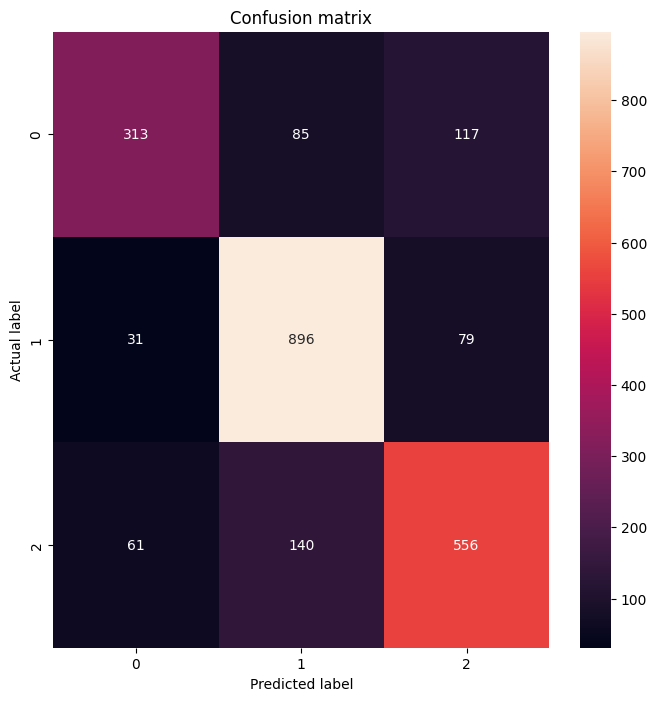

In [ ]:
predicted = []
true_labels = []
from tqdm import tqdm
for images, labels in tqdm(validation_dataset, desc="Processing validation data"):
    preds = pretrained_model_EfficientNetB4.predict(images)
    predicted.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

pred = np.array(predicted)
lab = np.array(true_labels)

cm = confusion_matrix(lab, pred)

wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                           y_true=lab,
                                                           preds=pred,
                                                           class_names=CONFIGURATION["CLASS_NAMES"])})

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


## **pretrained_model_MobileNetV2**

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(pretrained_model_EfficientNetB4(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model_EfficientNetB4(im), axis = -1).numpy()[0]])

tf.Tensor([[0.19824715 0.0349333  0.76681954]], shape=(1, 3), dtype=float32)
sad


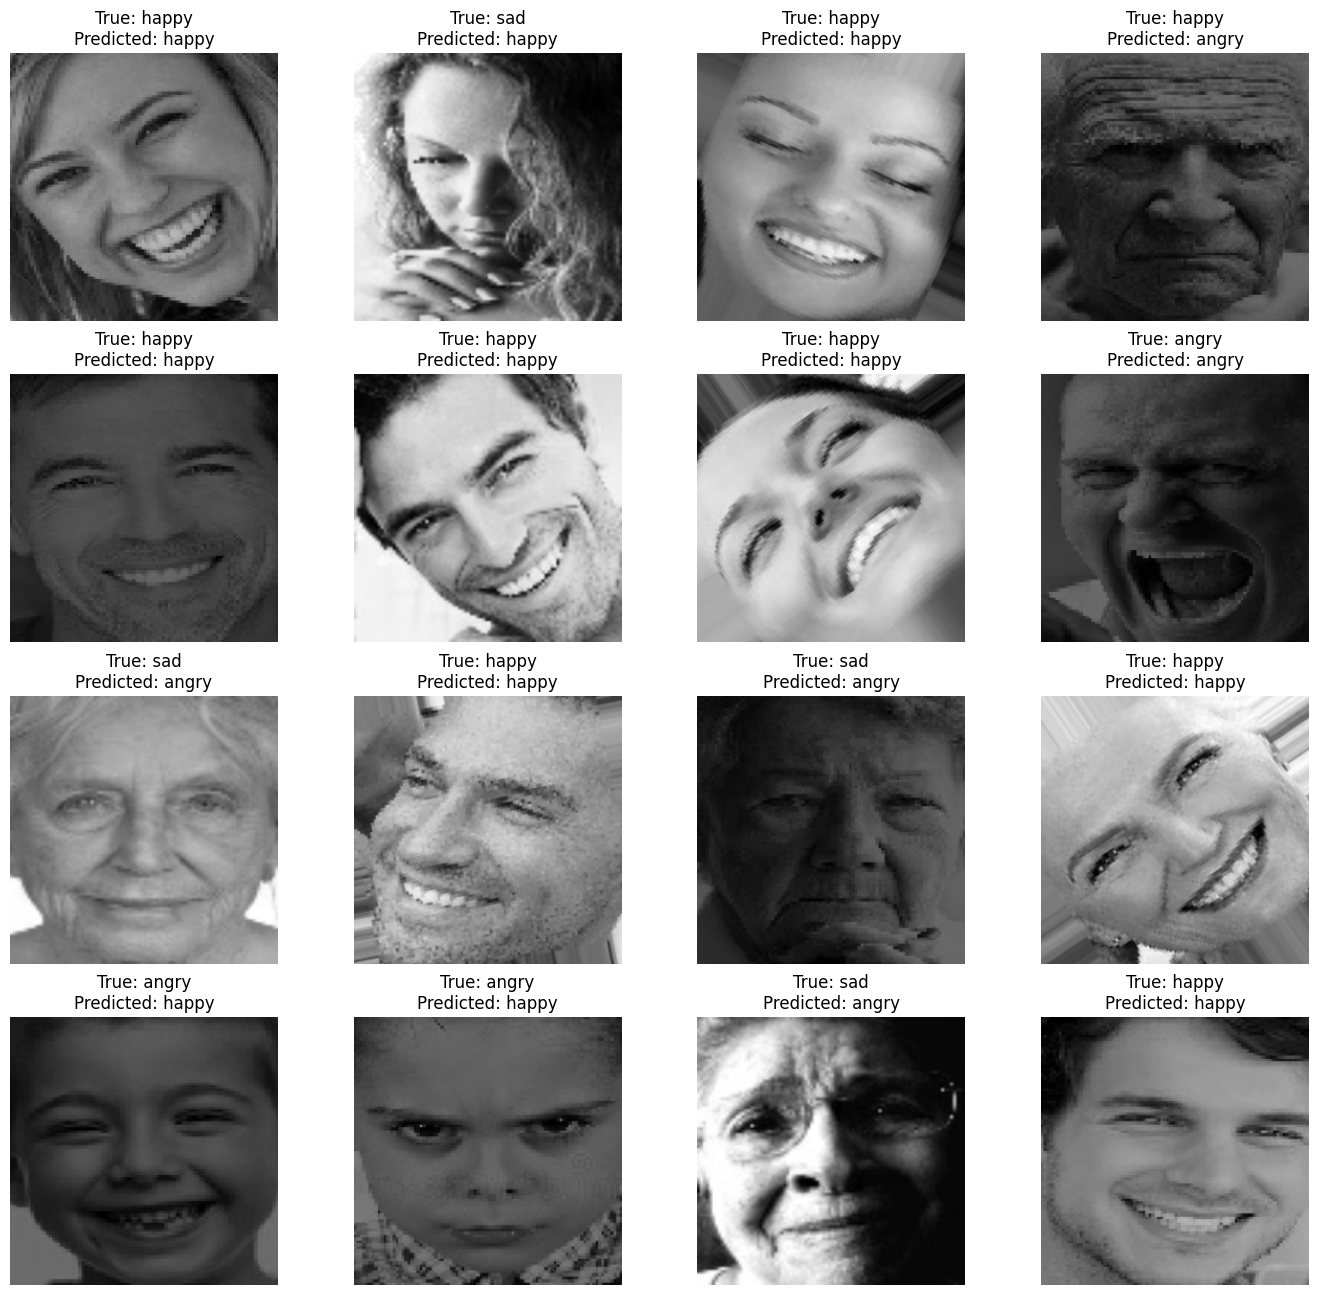

In [ ]:
plt.figure(figsize=(17, 16))

batch_index = 0
for images, labels in validation_dataset.take(16):
    for i in range(len(images)):
        ax = plt.subplot(4, 4, batch_index * len(images) + i + 1)
        plt.imshow(images[i] / 255.)

        true_label = CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=-1).numpy()]
        predicted_label = CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model_MobileNetV2(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0])]

        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis("off")

    batch_index += 1
    if batch_index * len(images) >= 16:
        break


### **Confusion matrix**

Processing validation data:   0%|          | 0/2278 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   0%|          | 1/2278 [00:00<05:16,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   0%|          | 3/2278 [00:00<03:32, 10.73it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   0%|          | 5/2278 [00:00<03:11, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   0%|          | 7/2278 [00:00<03:02, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   0%|          | 9/2278 [00:00<02:48, 13.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:   0%|          | 11/2278 [00:00<02:50, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   1%|          | 13/2278 [00:01<03:02, 12.38it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   1%|          | 15/2278 [00:01<03:04, 12.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   1%|          | 17/2278 [00:01<03:07, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   1%|          | 19/2278 [00:01<03:08, 12.01it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   1%|          | 21/2278 [00:01<03:05, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   1%|          | 23/2278 [00:01<03:04, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:   1%|          | 25/2278 [00:02<03:04, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   1%|          | 27/2278 [00:02<03:03, 12.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   1%|▏         | 29/2278 [00:02<03:00, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   1%|▏         | 31/2278 [00:02<03:00, 12.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   1%|▏         | 33/2278 [00:02<02:59, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   2%|▏         | 35/2278 [00:02<02:56, 12.69it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   2%|▏         | 37/2278 [00:02<02:56, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   2%|▏         | 39/2278 [00:03<03:14, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   2%|▏         | 41/2278 [00:03<03:08, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   2%|▏         | 43/2278 [00:03<03:11, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   2%|▏         | 45/2278 [00:03<03:04, 12.11it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   2%|▏         | 47/2278 [00:03<03:02, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   2%|▏         | 49/2278 [00:04<02:58, 12.51it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   2%|▏         | 51/2278 [00:04<03:00, 12.32it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   2%|▏         | 53/2278 [00:04<02:58, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   2%|▏         | 55/2278 [00:04<02:54, 12.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 57/2278 [00:04<02:54, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   3%|▎         | 59/2278 [00:04<02:55, 12.67it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 61/2278 [00:04<02:52, 12.89it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   3%|▎         | 63/2278 [00:05<02:48, 13.12it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   3%|▎         | 65/2278 [00:05<02:51, 12.92it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   3%|▎         | 67/2278 [00:05<02:51, 12.93it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:   3%|▎         | 69/2278 [00:05<02:49, 13.07it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 71/2278 [00:05<02:44, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 73/2278 [00:05<02:46, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 75/2278 [00:05<02:45, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   3%|▎         | 77/2278 [00:06<02:43, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   3%|▎         | 79/2278 [00:06<02:44, 13.33it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:   4%|▎         | 81/2278 [00:06<02:43, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:   4%|▎         | 83/2278 [00:06<02:45, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▎         | 85/2278 [00:06<02:46, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▍         | 87/2278 [00:06<02:46, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▍         | 89/2278 [00:07<02:42, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▍         | 91/2278 [00:07<02:41, 13.56it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   4%|▍         | 93/2278 [00:07<02:43, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   4%|▍         | 95/2278 [00:07<02:49, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   4%|▍         | 97/2278 [00:07<02:49, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▍         | 99/2278 [00:07<02:43, 13.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   4%|▍         | 101/2278 [00:07<02:43, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   5%|▍         | 103/2278 [00:08<02:40, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   5%|▍         | 105/2278 [00:08<02:46, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   5%|▍         | 107/2278 [00:08<02:41, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   5%|▍         | 109/2278 [00:08<02:43, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   5%|▍         | 111/2278 [00:08<02:43, 13.28it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:   5%|▍         | 113/2278 [00:08<02:47, 12.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:   5%|▌         | 115/2278 [00:09<03:11, 11.32it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:   5%|▌         | 117/2278 [00:09<03:19, 10.85it/s]

1/1 [==============================] - 0s 98ms/step


Processing validation data:   5%|▌         | 119/2278 [00:09<03:52,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:   5%|▌         | 120/2278 [00:09<03:53,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   5%|▌         | 122/2278 [00:09<03:45,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   5%|▌         | 123/2278 [00:09<03:43,  9.62it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:   5%|▌         | 124/2278 [00:10<03:45,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:   5%|▌         | 125/2278 [00:10<03:52,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   6%|▌         | 126/2278 [00:10<03:50,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:   6%|▌         | 127/2278 [00:10<03:47,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   6%|▌         | 128/2278 [00:10<03:51,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:   6%|▌         | 129/2278 [00:10<03:49,  9.38it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:   6%|▌         | 130/2278 [00:10<04:19,  8.27it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:   6%|▌         | 131/2278 [00:10<04:10,  8.57it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:   6%|▌         | 132/2278 [00:11<04:13,  8.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   6%|▌         | 134/2278 [00:11<03:28, 10.28it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   6%|▌         | 136/2278 [00:11<03:07, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   6%|▌         | 138/2278 [00:11<02:51, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   6%|▌         | 140/2278 [00:11<02:45, 12.91it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:   6%|▌         | 142/2278 [00:11<03:04, 11.55it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   6%|▋         | 144/2278 [00:11<02:50, 12.48it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   6%|▋         | 146/2278 [00:12<02:49, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   6%|▋         | 148/2278 [00:12<02:44, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   7%|▋         | 150/2278 [00:12<02:48, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   7%|▋         | 152/2278 [00:12<02:41, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   7%|▋         | 154/2278 [00:12<02:36, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   7%|▋         | 156/2278 [00:12<02:35, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   7%|▋         | 158/2278 [00:12<02:38, 13.37it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   7%|▋         | 160/2278 [00:13<02:38, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   7%|▋         | 162/2278 [00:13<02:34, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   7%|▋         | 164/2278 [00:13<02:29, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   7%|▋         | 166/2278 [00:13<02:30, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   7%|▋         | 168/2278 [00:13<02:36, 13.47it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:   7%|▋         | 170/2278 [00:13<02:47, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   8%|▊         | 172/2278 [00:14<02:44, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   8%|▊         | 174/2278 [00:14<02:41, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   8%|▊         | 176/2278 [00:14<02:38, 13.28it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   8%|▊         | 178/2278 [00:14<02:41, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   8%|▊         | 180/2278 [00:14<02:41, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   8%|▊         | 182/2278 [00:14<02:40, 13.05it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:   8%|▊         | 184/2278 [00:14<02:41, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   8%|▊         | 186/2278 [00:15<02:45, 12.67it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   8%|▊         | 188/2278 [00:15<02:45, 12.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   8%|▊         | 190/2278 [00:15<02:41, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   8%|▊         | 192/2278 [00:15<02:37, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:   9%|▊         | 194/2278 [00:15<02:38, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   9%|▊         | 196/2278 [00:15<02:43, 12.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   9%|▊         | 198/2278 [00:16<02:51, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   9%|▉         | 200/2278 [00:16<02:52, 12.06it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:   9%|▉         | 202/2278 [00:16<02:55, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:   9%|▉         | 204/2278 [00:16<02:53, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   9%|▉         | 206/2278 [00:16<02:47, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:   9%|▉         | 208/2278 [00:16<02:44, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:   9%|▉         | 210/2278 [00:17<02:36, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   9%|▉         | 212/2278 [00:17<02:35, 13.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:   9%|▉         | 214/2278 [00:17<02:33, 13.42it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:   9%|▉         | 216/2278 [00:17<02:28, 13.85it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  10%|▉         | 218/2278 [00:17<02:23, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  10%|▉         | 220/2278 [00:17<02:24, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  10%|▉         | 222/2278 [00:17<02:29, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  10%|▉         | 224/2278 [00:18<02:31, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  10%|▉         | 226/2278 [00:18<02:41, 12.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  10%|█         | 228/2278 [00:18<02:38, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  10%|█         | 230/2278 [00:18<02:36, 13.06it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  10%|█         | 232/2278 [00:18<02:37, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  10%|█         | 234/2278 [00:18<02:33, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  10%|█         | 236/2278 [00:18<02:32, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  10%|█         | 238/2278 [00:19<02:31, 13.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█         | 240/2278 [00:19<02:29, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  11%|█         | 242/2278 [00:19<02:31, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█         | 244/2278 [00:19<02:28, 13.73it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█         | 246/2278 [00:19<02:26, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  11%|█         | 248/2278 [00:19<02:27, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  11%|█         | 250/2278 [00:19<02:34, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█         | 252/2278 [00:20<02:30, 13.44it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  11%|█         | 254/2278 [00:20<02:41, 12.51it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  11%|█         | 256/2278 [00:20<02:35, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█▏        | 258/2278 [00:20<02:36, 12.90it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  11%|█▏        | 260/2278 [00:20<02:36, 12.90it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  12%|█▏        | 262/2278 [00:20<02:33, 13.16it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  12%|█▏        | 264/2278 [00:21<02:43, 12.31it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  12%|█▏        | 266/2278 [00:21<02:59, 11.22it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  12%|█▏        | 268/2278 [00:21<03:08, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  12%|█▏        | 270/2278 [00:21<03:07, 10.74it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 272/2278 [00:21<03:07, 10.70it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  12%|█▏        | 274/2278 [00:22<03:15, 10.23it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  12%|█▏        | 276/2278 [00:22<03:19, 10.04it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  12%|█▏        | 278/2278 [00:22<03:55,  8.51it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  12%|█▏        | 279/2278 [00:22<03:51,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  12%|█▏        | 280/2278 [00:22<03:47,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  12%|█▏        | 281/2278 [00:22<03:46,  8.81it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  12%|█▏        | 282/2278 [00:23<03:57,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  12%|█▏        | 283/2278 [00:23<04:00,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  12%|█▏        | 284/2278 [00:23<03:54,  8.50it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  13%|█▎        | 286/2278 [00:23<03:19,  9.97it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  13%|█▎        | 288/2278 [00:23<02:57, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  13%|█▎        | 290/2278 [00:23<02:45, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  13%|█▎        | 292/2278 [00:23<02:41, 12.31it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  13%|█▎        | 294/2278 [00:24<02:40, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  13%|█▎        | 296/2278 [00:24<02:37, 12.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  13%|█▎        | 298/2278 [00:24<02:33, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  13%|█▎        | 300/2278 [00:24<02:33, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  13%|█▎        | 302/2278 [00:24<02:39, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  13%|█▎        | 304/2278 [00:24<02:38, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  13%|█▎        | 306/2278 [00:25<02:35, 12.65it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  14%|█▎        | 308/2278 [00:25<02:32, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  14%|█▎        | 310/2278 [00:25<02:27, 13.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  14%|█▎        | 312/2278 [00:25<02:28, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  14%|█▍        | 314/2278 [00:25<02:30, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  14%|█▍        | 316/2278 [00:25<02:29, 13.16it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  14%|█▍        | 318/2278 [00:25<02:24, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  14%|█▍        | 320/2278 [00:26<02:26, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  14%|█▍        | 322/2278 [00:26<02:29, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  14%|█▍        | 324/2278 [00:26<02:25, 13.38it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  14%|█▍        | 326/2278 [00:26<02:25, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  14%|█▍        | 328/2278 [00:26<02:24, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  14%|█▍        | 330/2278 [00:26<02:39, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  15%|█▍        | 332/2278 [00:27<02:37, 12.36it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  15%|█▍        | 334/2278 [00:27<02:39, 12.18it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  15%|█▍        | 336/2278 [00:27<02:37, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  15%|█▍        | 338/2278 [00:27<02:36, 12.44it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  15%|█▍        | 340/2278 [00:27<02:37, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  15%|█▌        | 342/2278 [00:27<02:34, 12.57it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  15%|█▌        | 344/2278 [00:28<02:36, 12.36it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  15%|█▌        | 346/2278 [00:28<02:37, 12.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  15%|█▌        | 348/2278 [00:28<02:40, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  15%|█▌        | 350/2278 [00:28<02:37, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  15%|█▌        | 352/2278 [00:28<02:34, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▌        | 354/2278 [00:28<02:26, 13.12it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  16%|█▌        | 356/2278 [00:28<02:37, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  16%|█▌        | 358/2278 [00:29<02:34, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  16%|█▌        | 360/2278 [00:29<02:28, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  16%|█▌        | 362/2278 [00:29<02:25, 13.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▌        | 364/2278 [00:29<02:22, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▌        | 366/2278 [00:29<02:21, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▌        | 368/2278 [00:29<02:20, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▌        | 370/2278 [00:29<02:19, 13.71it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  16%|█▋        | 372/2278 [00:30<02:19, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  16%|█▋        | 374/2278 [00:30<02:21, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  17%|█▋        | 376/2278 [00:30<02:22, 13.30it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  17%|█▋        | 378/2278 [00:30<02:20, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  17%|█▋        | 380/2278 [00:30<02:22, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 382/2278 [00:30<02:23, 13.24it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  17%|█▋        | 384/2278 [00:31<02:27, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 386/2278 [00:31<02:33, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 388/2278 [00:31<02:29, 12.64it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 390/2278 [00:31<02:28, 12.69it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  17%|█▋        | 392/2278 [00:31<02:22, 13.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 394/2278 [00:31<02:26, 12.85it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 396/2278 [00:31<02:24, 13.02it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  17%|█▋        | 398/2278 [00:32<02:20, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  18%|█▊        | 400/2278 [00:32<02:20, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  18%|█▊        | 402/2278 [00:32<02:23, 13.09it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  18%|█▊        | 404/2278 [00:32<02:21, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  18%|█▊        | 406/2278 [00:32<02:21, 13.26it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  18%|█▊        | 408/2278 [00:32<02:19, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  18%|█▊        | 410/2278 [00:33<02:18, 13.52it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  18%|█▊        | 412/2278 [00:33<02:32, 12.23it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  18%|█▊        | 414/2278 [00:33<02:49, 10.99it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  18%|█▊        | 416/2278 [00:33<02:57, 10.49it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  18%|█▊        | 418/2278 [00:33<03:01, 10.26it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  18%|█▊        | 420/2278 [00:34<03:02, 10.16it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  19%|█▊        | 422/2278 [00:34<03:07,  9.88it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  19%|█▊        | 424/2278 [00:34<03:11,  9.67it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  19%|█▊        | 425/2278 [00:34<03:10,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  19%|█▊        | 426/2278 [00:34<03:11,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  19%|█▊        | 427/2278 [00:34<03:18,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  19%|█▉        | 428/2278 [00:34<03:17,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  19%|█▉        | 429/2278 [00:35<03:18,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  19%|█▉        | 430/2278 [00:35<03:26,  8.93it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  19%|█▉        | 431/2278 [00:36<15:18,  2.01it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  19%|█▉        | 433/2278 [00:36<09:39,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  19%|█▉        | 435/2278 [00:37<06:53,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  19%|█▉        | 437/2278 [00:37<05:20,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  19%|█▉        | 439/2278 [00:37<04:27,  6.88it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  19%|█▉        | 441/2278 [00:37<04:00,  7.64it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  19%|█▉        | 443/2278 [00:37<03:37,  8.43it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  20%|█▉        | 445/2278 [00:37<03:19,  9.20it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  20%|█▉        | 447/2278 [00:38<03:04,  9.92it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  20%|█▉        | 449/2278 [00:38<02:58, 10.27it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  20%|█▉        | 451/2278 [00:38<02:54, 10.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  20%|█▉        | 453/2278 [00:38<02:50, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  20%|█▉        | 455/2278 [00:38<02:48, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  20%|██        | 457/2278 [00:38<02:48, 10.83it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  20%|██        | 459/2278 [00:39<02:46, 10.92it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  20%|██        | 461/2278 [00:39<02:43, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  20%|██        | 463/2278 [00:39<02:41, 11.27it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  20%|██        | 465/2278 [00:39<02:47, 10.84it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  21%|██        | 467/2278 [00:39<02:58, 10.16it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  21%|██        | 469/2278 [00:40<02:52, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  21%|██        | 471/2278 [00:40<02:44, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  21%|██        | 473/2278 [00:40<02:43, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  21%|██        | 475/2278 [00:40<02:40, 11.24it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  21%|██        | 477/2278 [00:40<02:36, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  21%|██        | 479/2278 [00:40<02:30, 11.96it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  21%|██        | 481/2278 [00:41<02:26, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  21%|██        | 483/2278 [00:41<02:26, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  21%|██▏       | 485/2278 [00:41<02:28, 12.04it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  21%|██▏       | 487/2278 [00:41<02:32, 11.78it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  21%|██▏       | 489/2278 [00:41<02:30, 11.92it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  22%|██▏       | 491/2278 [00:41<02:39, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  22%|██▏       | 493/2278 [00:42<02:40, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  22%|██▏       | 495/2278 [00:42<02:37, 11.30it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  22%|██▏       | 497/2278 [00:42<02:42, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  22%|██▏       | 499/2278 [00:42<02:36, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  22%|██▏       | 501/2278 [00:42<02:28, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  22%|██▏       | 503/2278 [00:43<02:31, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  22%|██▏       | 505/2278 [00:43<02:26, 12.09it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  22%|██▏       | 507/2278 [00:43<02:26, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  22%|██▏       | 509/2278 [00:43<02:25, 12.16it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  22%|██▏       | 511/2278 [00:43<02:27, 11.99it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  23%|██▎       | 513/2278 [00:43<02:29, 11.79it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  23%|██▎       | 515/2278 [00:44<02:30, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  23%|██▎       | 517/2278 [00:44<02:35, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  23%|██▎       | 519/2278 [00:44<02:31, 11.61it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  23%|██▎       | 521/2278 [00:44<02:35, 11.33it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  23%|██▎       | 523/2278 [00:44<02:33, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  23%|██▎       | 525/2278 [00:44<02:31, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  23%|██▎       | 527/2278 [00:45<02:27, 11.84it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  23%|██▎       | 529/2278 [00:45<02:30, 11.64it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  23%|██▎       | 531/2278 [00:45<02:35, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  23%|██▎       | 533/2278 [00:45<02:32, 11.45it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  23%|██▎       | 535/2278 [00:45<02:46, 10.45it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  24%|██▎       | 537/2278 [00:46<02:59,  9.73it/s]

1/1 [==============================] - 0s 91ms/step


Processing validation data:  24%|██▎       | 538/2278 [00:46<03:30,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  24%|██▎       | 539/2278 [00:46<03:40,  7.88it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  24%|██▎       | 540/2278 [00:46<03:37,  8.01it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  24%|██▎       | 541/2278 [00:46<03:35,  8.05it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  24%|██▍       | 542/2278 [00:46<03:30,  8.26it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  24%|██▍       | 543/2278 [00:46<03:23,  8.54it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  24%|██▍       | 544/2278 [00:46<03:21,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  24%|██▍       | 545/2278 [00:47<03:41,  7.82it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  24%|██▍       | 546/2278 [00:47<03:42,  7.79it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  24%|██▍       | 547/2278 [00:47<03:41,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  24%|██▍       | 548/2278 [00:47<03:40,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  24%|██▍       | 549/2278 [00:47<03:41,  7.81it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  24%|██▍       | 550/2278 [00:47<03:38,  7.91it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  24%|██▍       | 551/2278 [00:47<03:35,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  24%|██▍       | 553/2278 [00:48<02:59,  9.59it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  24%|██▍       | 555/2278 [00:48<02:42, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  24%|██▍       | 557/2278 [00:48<02:50, 10.11it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  25%|██▍       | 559/2278 [00:48<02:41, 10.67it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  25%|██▍       | 561/2278 [00:48<02:36, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  25%|██▍       | 563/2278 [00:48<02:30, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  25%|██▍       | 565/2278 [00:49<02:25, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  25%|██▍       | 567/2278 [00:49<02:25, 11.75it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  25%|██▍       | 569/2278 [00:49<02:25, 11.76it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  25%|██▌       | 571/2278 [00:49<02:19, 12.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  25%|██▌       | 573/2278 [00:49<02:18, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  25%|██▌       | 575/2278 [00:49<02:21, 12.05it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  25%|██▌       | 577/2278 [00:50<02:21, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  25%|██▌       | 579/2278 [00:50<02:21, 12.05it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  26%|██▌       | 581/2278 [00:50<02:20, 12.12it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  26%|██▌       | 583/2278 [00:50<02:37, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  26%|██▌       | 585/2278 [00:50<02:36, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  26%|██▌       | 587/2278 [00:50<02:32, 11.05it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  26%|██▌       | 589/2278 [00:51<02:26, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  26%|██▌       | 591/2278 [00:51<02:25, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  26%|██▌       | 593/2278 [00:51<02:26, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  26%|██▌       | 595/2278 [00:51<02:27, 11.43it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  26%|██▌       | 597/2278 [00:51<02:21, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  26%|██▋       | 599/2278 [00:51<02:20, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  26%|██▋       | 601/2278 [00:52<02:19, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  26%|██▋       | 603/2278 [00:52<02:20, 11.92it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  27%|██▋       | 605/2278 [00:52<02:17, 12.12it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  27%|██▋       | 607/2278 [00:52<02:26, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  27%|██▋       | 609/2278 [00:52<02:23, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 611/2278 [00:53<02:24, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  27%|██▋       | 613/2278 [00:53<02:20, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 615/2278 [00:53<02:17, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 617/2278 [00:53<02:13, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 619/2278 [00:53<02:09, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 621/2278 [00:53<02:12, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 623/2278 [00:53<02:13, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  27%|██▋       | 625/2278 [00:54<02:12, 12.50it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  28%|██▊       | 627/2278 [00:54<02:10, 12.63it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  28%|██▊       | 629/2278 [00:54<02:11, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  28%|██▊       | 631/2278 [00:54<02:14, 12.26it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  28%|██▊       | 633/2278 [00:54<02:21, 11.66it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  28%|██▊       | 635/2278 [00:54<02:19, 11.79it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  28%|██▊       | 637/2278 [00:55<02:15, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  28%|██▊       | 639/2278 [00:55<02:15, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  28%|██▊       | 641/2278 [00:55<02:13, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  28%|██▊       | 643/2278 [00:55<02:10, 12.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  28%|██▊       | 645/2278 [00:55<02:09, 12.61it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  28%|██▊       | 647/2278 [00:55<02:06, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  28%|██▊       | 649/2278 [00:56<02:12, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  29%|██▊       | 651/2278 [00:56<02:13, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  29%|██▊       | 653/2278 [00:56<02:15, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  29%|██▉       | 655/2278 [00:56<02:11, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  29%|██▉       | 657/2278 [00:56<02:10, 12.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  29%|██▉       | 659/2278 [00:56<02:11, 12.29it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  29%|██▉       | 661/2278 [00:57<02:19, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  29%|██▉       | 663/2278 [00:57<02:16, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  29%|██▉       | 665/2278 [00:57<02:13, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  29%|██▉       | 667/2278 [00:57<02:13, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  29%|██▉       | 669/2278 [00:57<02:12, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  29%|██▉       | 671/2278 [00:57<02:12, 12.17it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  30%|██▉       | 673/2278 [00:58<02:27, 10.88it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  30%|██▉       | 675/2278 [00:58<02:40,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  30%|██▉       | 677/2278 [00:58<02:45,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  30%|██▉       | 678/2278 [00:58<02:45,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  30%|██▉       | 679/2278 [00:58<02:47,  9.53it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  30%|██▉       | 680/2278 [00:58<02:48,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  30%|██▉       | 681/2278 [00:59<02:52,  9.28it/s]

1/1 [==============================] - 0s 69ms/step


Processing validation data:  30%|██▉       | 682/2278 [00:59<03:30,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  30%|██▉       | 683/2278 [00:59<03:29,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  30%|███       | 684/2278 [00:59<03:29,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  30%|███       | 685/2278 [00:59<03:20,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  30%|███       | 686/2278 [00:59<03:17,  8.04it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  30%|███       | 687/2278 [00:59<03:16,  8.10it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  30%|███       | 688/2278 [00:59<03:12,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  30%|███       | 689/2278 [01:00<03:15,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  30%|███       | 690/2278 [01:00<03:13,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  30%|███       | 691/2278 [01:00<03:08,  8.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  30%|███       | 693/2278 [01:00<02:43,  9.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  31%|███       | 695/2278 [01:00<02:24, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███       | 697/2278 [01:00<02:16, 11.61it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  31%|███       | 699/2278 [01:00<02:09, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  31%|███       | 701/2278 [01:01<02:04, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  31%|███       | 703/2278 [01:01<02:10, 12.10it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  31%|███       | 705/2278 [01:01<02:15, 11.64it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███       | 707/2278 [01:01<02:12, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███       | 709/2278 [01:01<02:08, 12.17it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  31%|███       | 711/2278 [01:01<02:13, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███▏      | 713/2278 [01:02<02:10, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███▏      | 715/2278 [01:02<02:09, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  31%|███▏      | 717/2278 [01:02<02:09, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 719/2278 [01:02<02:08, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 721/2278 [01:02<02:08, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 723/2278 [01:02<02:08, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 725/2278 [01:03<02:08, 12.11it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  32%|███▏      | 727/2278 [01:03<02:08, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 729/2278 [01:03<02:09, 11.99it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  32%|███▏      | 731/2278 [01:03<02:24, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  32%|███▏      | 733/2278 [01:03<02:18, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  32%|███▏      | 735/2278 [01:03<02:11, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 737/2278 [01:04<02:06, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  32%|███▏      | 739/2278 [01:04<02:07, 12.11it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  33%|███▎      | 741/2278 [01:04<02:05, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  33%|███▎      | 743/2278 [01:04<02:02, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  33%|███▎      | 745/2278 [01:04<01:59, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  33%|███▎      | 747/2278 [01:04<02:02, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  33%|███▎      | 749/2278 [01:05<02:02, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  33%|███▎      | 751/2278 [01:05<02:01, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  33%|███▎      | 753/2278 [01:05<02:01, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  33%|███▎      | 755/2278 [01:05<01:58, 12.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  33%|███▎      | 757/2278 [01:05<02:09, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  33%|███▎      | 759/2278 [01:05<02:08, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  33%|███▎      | 761/2278 [01:06<02:04, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  33%|███▎      | 763/2278 [01:06<01:59, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  34%|███▎      | 765/2278 [01:06<02:05, 12.09it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  34%|███▎      | 767/2278 [01:06<02:05, 12.08it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  34%|███▍      | 769/2278 [01:06<02:02, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  34%|███▍      | 771/2278 [01:06<02:00, 12.48it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  34%|███▍      | 773/2278 [01:07<01:58, 12.68it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  34%|███▍      | 775/2278 [01:07<02:00, 12.48it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  34%|███▍      | 777/2278 [01:07<01:59, 12.58it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  34%|███▍      | 779/2278 [01:07<01:58, 12.67it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  34%|███▍      | 781/2278 [01:07<01:58, 12.63it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  34%|███▍      | 783/2278 [01:07<02:04, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  34%|███▍      | 785/2278 [01:08<02:04, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  35%|███▍      | 787/2278 [01:08<02:04, 12.02it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  35%|███▍      | 789/2278 [01:08<02:11, 11.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  35%|███▍      | 791/2278 [01:08<02:06, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  35%|███▍      | 793/2278 [01:08<02:04, 11.88it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  35%|███▍      | 795/2278 [01:08<02:02, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  35%|███▍      | 797/2278 [01:09<02:00, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  35%|███▌      | 799/2278 [01:09<01:57, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  35%|███▌      | 801/2278 [01:09<02:00, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  35%|███▌      | 803/2278 [01:09<02:01, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  35%|███▌      | 805/2278 [01:09<01:57, 12.49it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  35%|███▌      | 807/2278 [01:09<01:56, 12.61it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  36%|███▌      | 809/2278 [01:10<02:10, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  36%|███▌      | 811/2278 [01:10<02:08, 11.44it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  36%|███▌      | 813/2278 [01:10<02:06, 11.54it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  36%|███▌      | 815/2278 [01:10<02:19, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  36%|███▌      | 817/2278 [01:10<02:22, 10.24it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  36%|███▌      | 819/2278 [01:11<02:37,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  36%|███▌      | 820/2278 [01:11<02:35,  9.36it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  36%|███▌      | 821/2278 [01:11<02:36,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  36%|███▌      | 822/2278 [01:11<02:35,  9.39it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  36%|███▌      | 823/2278 [01:11<02:39,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  36%|███▌      | 824/2278 [01:11<02:40,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  36%|███▌      | 825/2278 [01:11<02:41,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  36%|███▋      | 826/2278 [01:11<02:42,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▋      | 827/2278 [01:11<02:42,  8.93it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  36%|███▋      | 828/2278 [01:12<03:04,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  36%|███▋      | 829/2278 [01:12<03:18,  7.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  36%|███▋      | 830/2278 [01:12<03:06,  7.76it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  36%|███▋      | 831/2278 [01:12<03:10,  7.58it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  37%|███▋      | 832/2278 [01:12<03:07,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  37%|███▋      | 833/2278 [01:12<02:59,  8.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 835/2278 [01:12<02:35,  9.28it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 837/2278 [01:13<02:22, 10.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 839/2278 [01:13<02:12, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 841/2278 [01:13<02:06, 11.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 843/2278 [01:13<02:00, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 845/2278 [01:13<01:59, 12.03it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  37%|███▋      | 847/2278 [01:13<02:02, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  37%|███▋      | 849/2278 [01:14<02:01, 11.80it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  37%|███▋      | 851/2278 [01:14<02:00, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  37%|███▋      | 853/2278 [01:14<02:07, 11.18it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  38%|███▊      | 855/2278 [01:14<02:05, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  38%|███▊      | 857/2278 [01:14<02:03, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  38%|███▊      | 859/2278 [01:14<02:01, 11.66it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  38%|███▊      | 861/2278 [01:15<01:59, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  38%|███▊      | 863/2278 [01:15<01:57, 12.04it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  38%|███▊      | 865/2278 [01:15<02:00, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  38%|███▊      | 867/2278 [01:15<02:01, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  38%|███▊      | 869/2278 [01:15<02:01, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  38%|███▊      | 871/2278 [01:15<02:00, 11.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  38%|███▊      | 873/2278 [01:16<01:57, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  38%|███▊      | 875/2278 [01:16<01:56, 12.01it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  38%|███▊      | 877/2278 [01:16<02:04, 11.23it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  39%|███▊      | 879/2278 [01:16<02:03, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  39%|███▊      | 881/2278 [01:16<01:56, 11.95it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  39%|███▉      | 883/2278 [01:17<01:56, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  39%|███▉      | 885/2278 [01:17<01:53, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  39%|███▉      | 887/2278 [01:17<01:51, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  39%|███▉      | 889/2278 [01:17<01:49, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  39%|███▉      | 891/2278 [01:17<01:49, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  39%|███▉      | 893/2278 [01:17<01:48, 12.80it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  39%|███▉      | 895/2278 [01:17<01:46, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  39%|███▉      | 897/2278 [01:18<01:48, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  39%|███▉      | 899/2278 [01:18<01:46, 12.94it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  40%|███▉      | 901/2278 [01:18<01:47, 12.80it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  40%|███▉      | 903/2278 [01:18<01:47, 12.81it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  40%|███▉      | 905/2278 [01:18<01:55, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  40%|███▉      | 907/2278 [01:18<01:51, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  40%|███▉      | 909/2278 [01:19<01:49, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  40%|███▉      | 911/2278 [01:19<01:49, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  40%|████      | 913/2278 [01:19<01:50, 12.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  40%|████      | 915/2278 [01:19<01:48, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  40%|████      | 917/2278 [01:19<01:49, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  40%|████      | 919/2278 [01:19<01:51, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  40%|████      | 921/2278 [01:20<01:52, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  41%|████      | 923/2278 [01:20<01:50, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  41%|████      | 925/2278 [01:20<01:50, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  41%|████      | 927/2278 [01:20<01:47, 12.60it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  41%|████      | 929/2278 [01:20<01:53, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  41%|████      | 931/2278 [01:20<01:59, 11.25it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  41%|████      | 933/2278 [01:21<01:55, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  41%|████      | 935/2278 [01:21<01:51, 12.02it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  41%|████      | 937/2278 [01:21<01:47, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  41%|████      | 939/2278 [01:21<01:47, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  41%|████▏     | 941/2278 [01:21<01:47, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  41%|████▏     | 943/2278 [01:21<01:48, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  41%|████▏     | 945/2278 [01:22<01:47, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  42%|████▏     | 947/2278 [01:22<01:48, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  42%|████▏     | 949/2278 [01:22<01:47, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  42%|████▏     | 951/2278 [01:22<01:47, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  42%|████▏     | 953/2278 [01:22<01:43, 12.82it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  42%|████▏     | 955/2278 [01:22<01:45, 12.53it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  42%|████▏     | 957/2278 [01:23<02:11, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  42%|████▏     | 959/2278 [01:23<02:19,  9.48it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  42%|████▏     | 961/2278 [01:23<02:14,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  42%|████▏     | 963/2278 [01:23<02:15,  9.70it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  42%|████▏     | 965/2278 [01:23<02:18,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  42%|████▏     | 967/2278 [01:24<02:15,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  42%|████▏     | 968/2278 [01:24<02:17,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  43%|████▎     | 969/2278 [01:24<02:16,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  43%|████▎     | 970/2278 [01:24<02:18,  9.44it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  43%|████▎     | 971/2278 [01:24<02:21,  9.26it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  43%|████▎     | 972/2278 [01:24<02:23,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  43%|████▎     | 973/2278 [01:24<02:27,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  43%|████▎     | 974/2278 [01:24<02:42,  8.04it/s]

1/1 [==============================] - 0s 65ms/step


Processing validation data:  43%|████▎     | 975/2278 [01:25<03:01,  7.18it/s]

1/1 [==============================] - 0s 62ms/step


Processing validation data:  43%|████▎     | 976/2278 [01:25<03:21,  6.46it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  43%|████▎     | 977/2278 [01:25<03:10,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  43%|████▎     | 979/2278 [01:25<02:32,  8.54it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  43%|████▎     | 981/2278 [01:25<02:13,  9.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  43%|████▎     | 983/2278 [01:25<02:07, 10.12it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  43%|████▎     | 985/2278 [01:26<02:00, 10.74it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  43%|████▎     | 987/2278 [01:26<01:56, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  43%|████▎     | 989/2278 [01:26<01:52, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  44%|████▎     | 991/2278 [01:26<01:50, 11.61it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  44%|████▎     | 993/2278 [01:26<02:00, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  44%|████▎     | 995/2278 [01:27<01:56, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  44%|████▍     | 997/2278 [01:27<01:51, 11.46it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  44%|████▍     | 999/2278 [01:27<01:52, 11.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  44%|████▍     | 1001/2278 [01:27<01:51, 11.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  44%|████▍     | 1003/2278 [01:27<01:49, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  44%|████▍     | 1005/2278 [01:27<01:46, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  44%|████▍     | 1007/2278 [01:28<01:45, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  44%|████▍     | 1009/2278 [01:28<01:43, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  44%|████▍     | 1011/2278 [01:28<01:44, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  44%|████▍     | 1013/2278 [01:28<01:40, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  45%|████▍     | 1015/2278 [01:28<01:39, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  45%|████▍     | 1017/2278 [01:28<01:38, 12.85it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  45%|████▍     | 1019/2278 [01:28<01:39, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  45%|████▍     | 1021/2278 [01:29<01:39, 12.69it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  45%|████▍     | 1023/2278 [01:29<01:40, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  45%|████▍     | 1025/2278 [01:29<01:37, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  45%|████▌     | 1027/2278 [01:29<01:43, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  45%|████▌     | 1029/2278 [01:29<01:43, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  45%|████▌     | 1031/2278 [01:29<01:41, 12.31it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  45%|████▌     | 1033/2278 [01:30<01:44, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  45%|████▌     | 1035/2278 [01:30<01:41, 12.21it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  46%|████▌     | 1037/2278 [01:30<01:40, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  46%|████▌     | 1039/2278 [01:30<01:41, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  46%|████▌     | 1041/2278 [01:30<01:37, 12.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  46%|████▌     | 1043/2278 [01:30<01:37, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  46%|████▌     | 1045/2278 [01:31<01:36, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  46%|████▌     | 1047/2278 [01:31<01:40, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  46%|████▌     | 1049/2278 [01:31<01:38, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  46%|████▌     | 1051/2278 [01:31<01:37, 12.52it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  46%|████▌     | 1053/2278 [01:31<01:43, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  46%|████▋     | 1055/2278 [01:31<01:40, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  46%|████▋     | 1057/2278 [01:32<01:42, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  46%|████▋     | 1059/2278 [01:32<01:41, 12.00it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  47%|████▋     | 1061/2278 [01:32<01:40, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  47%|████▋     | 1063/2278 [01:32<01:39, 12.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  47%|████▋     | 1065/2278 [01:32<01:39, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  47%|████▋     | 1067/2278 [01:32<01:35, 12.68it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  47%|████▋     | 1069/2278 [01:33<01:37, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  47%|████▋     | 1071/2278 [01:33<01:39, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  47%|████▋     | 1073/2278 [01:33<01:39, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  47%|████▋     | 1075/2278 [01:33<01:37, 12.37it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  47%|████▋     | 1077/2278 [01:33<01:39, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  47%|████▋     | 1079/2278 [01:33<01:47, 11.13it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  47%|████▋     | 1081/2278 [01:34<01:42, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  48%|████▊     | 1083/2278 [01:34<01:43, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  48%|████▊     | 1085/2278 [01:34<01:39, 11.94it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  48%|████▊     | 1087/2278 [01:34<01:36, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  48%|████▊     | 1089/2278 [01:34<01:35, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  48%|████▊     | 1091/2278 [01:34<01:32, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  48%|████▊     | 1093/2278 [01:35<01:32, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  48%|████▊     | 1095/2278 [01:35<01:34, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  48%|████▊     | 1097/2278 [01:35<01:34, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  48%|████▊     | 1099/2278 [01:35<01:34, 12.52it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1101/2278 [01:35<01:47, 10.93it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  48%|████▊     | 1103/2278 [01:35<01:51, 10.52it/s]

1/1 [==============================] - 0s 74ms/step


Processing validation data:  49%|████▊     | 1105/2278 [01:36<02:12,  8.83it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  49%|████▊     | 1106/2278 [01:36<02:14,  8.75it/s]

1/1 [==============================] - 0s 50ms/step


Processing validation data:  49%|████▊     | 1107/2278 [01:36<02:25,  8.07it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  49%|████▊     | 1108/2278 [01:36<02:23,  8.18it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  49%|████▊     | 1109/2278 [01:36<02:21,  8.28it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  49%|████▊     | 1110/2278 [01:36<02:18,  8.46it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  49%|████▉     | 1111/2278 [01:36<02:12,  8.78it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  49%|████▉     | 1112/2278 [01:37<02:12,  8.79it/s]

1/1 [==============================] - 0s 63ms/step


Processing validation data:  49%|████▉     | 1113/2278 [01:37<02:19,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  49%|████▉     | 1114/2278 [01:37<02:21,  8.25it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  49%|████▉     | 1115/2278 [01:37<02:13,  8.69it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  49%|████▉     | 1116/2278 [01:37<02:12,  8.74it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  49%|████▉     | 1117/2278 [01:37<02:10,  8.91it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  49%|████▉     | 1118/2278 [01:37<02:11,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  49%|████▉     | 1119/2278 [01:37<02:18,  8.39it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  49%|████▉     | 1120/2278 [01:38<02:15,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  49%|████▉     | 1121/2278 [01:38<02:18,  8.38it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  49%|████▉     | 1122/2278 [01:38<02:17,  8.39it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  49%|████▉     | 1123/2278 [01:38<02:17,  8.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  49%|████▉     | 1125/2278 [01:38<02:02,  9.43it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  49%|████▉     | 1127/2278 [01:38<01:50, 10.44it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  50%|████▉     | 1129/2278 [01:38<01:44, 10.96it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  50%|████▉     | 1131/2278 [01:39<01:39, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  50%|████▉     | 1133/2278 [01:39<01:37, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  50%|████▉     | 1135/2278 [01:39<01:35, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  50%|████▉     | 1137/2278 [01:39<01:32, 12.32it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  50%|█████     | 1139/2278 [01:39<01:33, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  50%|█████     | 1141/2278 [01:39<01:30, 12.50it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  50%|█████     | 1143/2278 [01:40<01:30, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  50%|█████     | 1145/2278 [01:40<01:29, 12.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  50%|█████     | 1147/2278 [01:40<01:32, 12.17it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  50%|█████     | 1149/2278 [01:40<01:39, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  51%|█████     | 1151/2278 [01:40<01:37, 11.51it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████     | 1153/2278 [01:40<01:33, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  51%|█████     | 1155/2278 [01:41<01:31, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████     | 1157/2278 [01:41<01:30, 12.37it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  51%|█████     | 1159/2278 [01:41<01:31, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  51%|█████     | 1161/2278 [01:41<01:28, 12.57it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████     | 1163/2278 [01:41<01:27, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████     | 1165/2278 [01:41<01:29, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████     | 1167/2278 [01:41<01:27, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  51%|█████▏    | 1169/2278 [01:42<01:28, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  51%|█████▏    | 1171/2278 [01:42<01:26, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  51%|█████▏    | 1173/2278 [01:42<01:28, 12.49it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  52%|█████▏    | 1175/2278 [01:42<01:41, 10.91it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  52%|█████▏    | 1177/2278 [01:42<01:39, 11.10it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  52%|█████▏    | 1179/2278 [01:43<01:33, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  52%|█████▏    | 1181/2278 [01:43<01:32, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  52%|█████▏    | 1183/2278 [01:43<01:30, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  52%|█████▏    | 1185/2278 [01:43<01:30, 12.10it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  52%|█████▏    | 1187/2278 [01:43<01:29, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  52%|█████▏    | 1189/2278 [01:43<01:29, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  52%|█████▏    | 1191/2278 [01:43<01:28, 12.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  52%|█████▏    | 1193/2278 [01:44<01:29, 12.18it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  52%|█████▏    | 1195/2278 [01:44<01:30, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1197/2278 [01:44<01:29, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1199/2278 [01:44<01:26, 12.43it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  53%|█████▎    | 1201/2278 [01:44<01:32, 11.68it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1203/2278 [01:44<01:31, 11.74it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1205/2278 [01:45<01:27, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  53%|█████▎    | 1207/2278 [01:45<01:25, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1209/2278 [01:45<01:24, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  53%|█████▎    | 1211/2278 [01:45<01:23, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  53%|█████▎    | 1213/2278 [01:45<01:24, 12.64it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  53%|█████▎    | 1215/2278 [01:45<01:22, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  53%|█████▎    | 1217/2278 [01:46<01:26, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  54%|█████▎    | 1219/2278 [01:46<01:27, 12.07it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▎    | 1221/2278 [01:46<01:32, 11.48it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  54%|█████▎    | 1223/2278 [01:46<01:29, 11.83it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  54%|█████▍    | 1225/2278 [01:46<01:25, 12.34it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  54%|█████▍    | 1227/2278 [01:46<01:28, 11.89it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  54%|█████▍    | 1229/2278 [01:47<01:32, 11.28it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  54%|█████▍    | 1231/2278 [01:47<01:29, 11.73it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  54%|█████▍    | 1233/2278 [01:47<01:28, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  54%|█████▍    | 1235/2278 [01:47<01:25, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  54%|█████▍    | 1237/2278 [01:47<01:23, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  54%|█████▍    | 1239/2278 [01:47<01:25, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  54%|█████▍    | 1241/2278 [01:48<01:24, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  55%|█████▍    | 1243/2278 [01:48<01:24, 12.29it/s]

1/1 [==============================] - 0s 59ms/step


Processing validation data:  55%|█████▍    | 1245/2278 [01:48<01:37, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  55%|█████▍    | 1247/2278 [01:48<01:42, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▍    | 1249/2278 [01:49<01:52,  9.14it/s]

1/1 [==============================] - 0s 67ms/step


Processing validation data:  55%|█████▍    | 1250/2278 [01:49<02:00,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▍    | 1251/2278 [01:49<02:16,  7.51it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  55%|█████▍    | 1252/2278 [01:49<02:16,  7.51it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  55%|█████▌    | 1253/2278 [01:49<02:13,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▌    | 1254/2278 [01:49<02:08,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  55%|█████▌    | 1255/2278 [01:49<02:07,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  55%|█████▌    | 1256/2278 [01:49<02:04,  8.23it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  55%|█████▌    | 1257/2278 [01:50<02:04,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▌    | 1258/2278 [01:50<02:02,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  55%|█████▌    | 1259/2278 [01:50<02:01,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  55%|█████▌    | 1260/2278 [01:50<02:03,  8.21it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  55%|█████▌    | 1261/2278 [01:50<02:06,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  55%|█████▌    | 1262/2278 [01:50<02:07,  7.99it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  55%|█████▌    | 1263/2278 [01:50<02:07,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  55%|█████▌    | 1264/2278 [01:50<01:59,  8.49it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  56%|█████▌    | 1266/2278 [01:51<01:44,  9.72it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  56%|█████▌    | 1268/2278 [01:51<01:33, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  56%|█████▌    | 1270/2278 [01:51<01:35, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  56%|█████▌    | 1272/2278 [01:51<01:29, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  56%|█████▌    | 1274/2278 [01:51<01:26, 11.57it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  56%|█████▌    | 1276/2278 [01:51<01:26, 11.54it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  56%|█████▌    | 1278/2278 [01:52<01:23, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  56%|█████▌    | 1280/2278 [01:52<01:21, 12.27it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  56%|█████▋    | 1282/2278 [01:52<01:21, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  56%|█████▋    | 1284/2278 [01:52<01:21, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  56%|█████▋    | 1286/2278 [01:52<01:22, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1288/2278 [01:52<01:20, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  57%|█████▋    | 1290/2278 [01:53<01:18, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  57%|█████▋    | 1292/2278 [01:53<01:17, 12.71it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1294/2278 [01:53<01:17, 12.70it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  57%|█████▋    | 1296/2278 [01:53<01:23, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  57%|█████▋    | 1298/2278 [01:53<01:23, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  57%|█████▋    | 1300/2278 [01:53<01:21, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1302/2278 [01:54<01:19, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1304/2278 [01:54<01:18, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1306/2278 [01:54<01:17, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  57%|█████▋    | 1308/2278 [01:54<01:15, 12.79it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  58%|█████▊    | 1310/2278 [01:54<01:15, 12.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1312/2278 [01:54<01:18, 12.29it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  58%|█████▊    | 1314/2278 [01:54<01:17, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  58%|█████▊    | 1316/2278 [01:55<01:16, 12.52it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1318/2278 [01:55<01:15, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  58%|█████▊    | 1320/2278 [01:55<01:16, 12.47it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  58%|█████▊    | 1322/2278 [01:55<01:20, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1324/2278 [01:55<01:22, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1326/2278 [01:55<01:19, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1328/2278 [01:56<01:19, 11.94it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1330/2278 [01:56<01:19, 11.93it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  58%|█████▊    | 1332/2278 [01:56<01:17, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  59%|█████▊    | 1334/2278 [01:56<01:14, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  59%|█████▊    | 1336/2278 [01:56<01:15, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  59%|█████▊    | 1338/2278 [01:56<01:16, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  59%|█████▉    | 1340/2278 [01:57<01:14, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  59%|█████▉    | 1342/2278 [01:57<01:15, 12.45it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  59%|█████▉    | 1344/2278 [01:57<01:15, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  59%|█████▉    | 1346/2278 [01:57<01:14, 12.47it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  59%|█████▉    | 1348/2278 [01:57<01:24, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  59%|█████▉    | 1350/2278 [01:58<01:26, 10.77it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  59%|█████▉    | 1352/2278 [01:58<01:23, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  59%|█████▉    | 1354/2278 [01:58<01:18, 11.81it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  60%|█████▉    | 1356/2278 [01:58<01:16, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  60%|█████▉    | 1358/2278 [01:58<01:15, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  60%|█████▉    | 1360/2278 [01:58<01:15, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  60%|█████▉    | 1362/2278 [01:58<01:13, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  60%|█████▉    | 1364/2278 [01:59<01:11, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  60%|█████▉    | 1366/2278 [01:59<01:11, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  60%|██████    | 1368/2278 [01:59<01:12, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  60%|██████    | 1370/2278 [01:59<01:12, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  60%|██████    | 1372/2278 [01:59<01:11, 12.62it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  60%|██████    | 1374/2278 [01:59<01:15, 11.94it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  60%|██████    | 1376/2278 [02:00<01:20, 11.20it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  60%|██████    | 1378/2278 [02:00<01:17, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  61%|██████    | 1380/2278 [02:00<01:16, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  61%|██████    | 1382/2278 [02:00<01:15, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  61%|██████    | 1384/2278 [02:00<01:16, 11.75it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  61%|██████    | 1386/2278 [02:01<01:27, 10.19it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  61%|██████    | 1388/2278 [02:01<01:33,  9.47it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  61%|██████    | 1389/2278 [02:01<01:36,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  61%|██████    | 1390/2278 [02:01<01:36,  9.19it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  61%|██████    | 1391/2278 [02:01<01:35,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  61%|██████    | 1392/2278 [02:01<01:39,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  61%|██████    | 1393/2278 [02:01<01:45,  8.39it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  61%|██████    | 1394/2278 [02:02<01:45,  8.34it/s]

1/1 [==============================] - 0s 73ms/step


Processing validation data:  61%|██████    | 1395/2278 [02:02<02:07,  6.94it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  61%|██████▏   | 1396/2278 [02:02<02:07,  6.90it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  61%|██████▏   | 1397/2278 [02:02<02:01,  7.26it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  61%|██████▏   | 1398/2278 [02:02<01:55,  7.62it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  61%|██████▏   | 1399/2278 [02:02<01:47,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  61%|██████▏   | 1400/2278 [02:02<01:47,  8.18it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  62%|██████▏   | 1401/2278 [02:02<01:50,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  62%|██████▏   | 1402/2278 [02:03<01:50,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  62%|██████▏   | 1403/2278 [02:03<01:51,  7.84it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  62%|██████▏   | 1404/2278 [02:03<01:48,  8.04it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  62%|██████▏   | 1405/2278 [02:03<01:45,  8.24it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  62%|██████▏   | 1407/2278 [02:03<01:27,  9.99it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  62%|██████▏   | 1409/2278 [02:03<01:21, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  62%|██████▏   | 1411/2278 [02:03<01:18, 11.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  62%|██████▏   | 1413/2278 [02:04<01:17, 11.19it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  62%|██████▏   | 1415/2278 [02:04<01:13, 11.76it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  62%|██████▏   | 1417/2278 [02:04<01:17, 11.16it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  62%|██████▏   | 1419/2278 [02:04<01:14, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  62%|██████▏   | 1421/2278 [02:04<01:13, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  62%|██████▏   | 1423/2278 [02:04<01:11, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  63%|██████▎   | 1425/2278 [02:05<01:12, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  63%|██████▎   | 1427/2278 [02:05<01:09, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  63%|██████▎   | 1429/2278 [02:05<01:07, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  63%|██████▎   | 1431/2278 [02:05<01:08, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  63%|██████▎   | 1433/2278 [02:05<01:06, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  63%|██████▎   | 1435/2278 [02:05<01:06, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  63%|██████▎   | 1437/2278 [02:06<01:07, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  63%|██████▎   | 1439/2278 [02:06<01:08, 12.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  63%|██████▎   | 1441/2278 [02:06<01:08, 12.29it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  63%|██████▎   | 1443/2278 [02:06<01:15, 11.04it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  63%|██████▎   | 1445/2278 [02:06<01:13, 11.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  64%|██████▎   | 1447/2278 [02:06<01:11, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  64%|██████▎   | 1449/2278 [02:07<01:11, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  64%|██████▎   | 1451/2278 [02:07<01:09, 11.91it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  64%|██████▍   | 1453/2278 [02:07<01:08, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  64%|██████▍   | 1455/2278 [02:07<01:10, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  64%|██████▍   | 1457/2278 [02:07<01:10, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  64%|██████▍   | 1459/2278 [02:07<01:10, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  64%|██████▍   | 1461/2278 [02:08<01:09, 11.68it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  64%|██████▍   | 1463/2278 [02:08<01:08, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  64%|██████▍   | 1465/2278 [02:08<01:06, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  64%|██████▍   | 1467/2278 [02:08<01:05, 12.45it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  64%|██████▍   | 1469/2278 [02:08<01:10, 11.56it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  65%|██████▍   | 1471/2278 [02:08<01:08, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▍   | 1473/2278 [02:09<01:06, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▍   | 1475/2278 [02:09<01:05, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▍   | 1477/2278 [02:09<01:06, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▍   | 1479/2278 [02:09<01:05, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  65%|██████▌   | 1481/2278 [02:09<01:05, 12.26it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  65%|██████▌   | 1483/2278 [02:09<01:04, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▌   | 1485/2278 [02:10<01:05, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  65%|██████▌   | 1487/2278 [02:10<01:05, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  65%|██████▌   | 1489/2278 [02:10<01:04, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  65%|██████▌   | 1491/2278 [02:10<01:02, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  66%|██████▌   | 1493/2278 [02:10<01:02, 12.56it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  66%|██████▌   | 1495/2278 [02:10<01:08, 11.47it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  66%|██████▌   | 1497/2278 [02:11<01:07, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  66%|██████▌   | 1499/2278 [02:11<01:06, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  66%|██████▌   | 1501/2278 [02:11<01:04, 12.03it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  66%|██████▌   | 1503/2278 [02:11<01:03, 12.16it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  66%|██████▌   | 1505/2278 [02:11<01:04, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  66%|██████▌   | 1507/2278 [02:11<01:03, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  66%|██████▌   | 1509/2278 [02:12<01:03, 12.06it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  66%|██████▋   | 1511/2278 [02:12<01:03, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  66%|██████▋   | 1513/2278 [02:12<01:04, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  67%|██████▋   | 1515/2278 [02:12<01:03, 12.09it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  67%|██████▋   | 1517/2278 [02:12<01:03, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  67%|██████▋   | 1519/2278 [02:12<01:06, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  67%|██████▋   | 1521/2278 [02:13<01:13, 10.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  67%|██████▋   | 1523/2278 [02:13<01:09, 10.80it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  67%|██████▋   | 1525/2278 [02:13<01:11, 10.60it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  67%|██████▋   | 1527/2278 [02:13<01:14, 10.14it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1529/2278 [02:14<01:17,  9.64it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  67%|██████▋   | 1530/2278 [02:14<01:21,  9.19it/s]

1/1 [==============================] - 0s 53ms/step


Processing validation data:  67%|██████▋   | 1531/2278 [02:14<01:23,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  67%|██████▋   | 1532/2278 [02:14<01:23,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  67%|██████▋   | 1534/2278 [02:14<01:19,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1535/2278 [02:14<01:18,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  67%|██████▋   | 1536/2278 [02:14<01:17,  9.53it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  67%|██████▋   | 1537/2278 [02:14<01:17,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  68%|██████▊   | 1539/2278 [02:15<01:26,  8.56it/s]

1/1 [==============================] - 0s 55ms/step


Processing validation data:  68%|██████▊   | 1540/2278 [02:15<01:31,  8.08it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  68%|██████▊   | 1541/2278 [02:15<01:32,  7.96it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  68%|██████▊   | 1542/2278 [02:15<01:28,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  68%|██████▊   | 1543/2278 [02:15<01:26,  8.50it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  68%|██████▊   | 1544/2278 [02:15<01:26,  8.48it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  68%|██████▊   | 1545/2278 [02:15<01:35,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  68%|██████▊   | 1546/2278 [02:16<01:39,  7.34it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  68%|██████▊   | 1547/2278 [02:16<01:33,  7.82it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  68%|██████▊   | 1548/2278 [02:16<01:28,  8.26it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  68%|██████▊   | 1549/2278 [02:16<01:24,  8.60it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  68%|██████▊   | 1551/2278 [02:16<01:11, 10.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  68%|██████▊   | 1553/2278 [02:16<01:08, 10.64it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  68%|██████▊   | 1555/2278 [02:16<01:02, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  68%|██████▊   | 1557/2278 [02:17<01:03, 11.31it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  68%|██████▊   | 1559/2278 [02:17<01:00, 11.80it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  69%|██████▊   | 1561/2278 [02:17<01:00, 11.87it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  69%|██████▊   | 1563/2278 [02:17<01:04, 11.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  69%|██████▊   | 1565/2278 [02:17<01:02, 11.38it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  69%|██████▉   | 1567/2278 [02:17<01:02, 11.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  69%|██████▉   | 1569/2278 [02:18<01:00, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  69%|██████▉   | 1571/2278 [02:18<00:59, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  69%|██████▉   | 1573/2278 [02:18<00:59, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  69%|██████▉   | 1575/2278 [02:18<00:57, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  69%|██████▉   | 1577/2278 [02:18<00:58, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  69%|██████▉   | 1579/2278 [02:18<00:56, 12.44it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  69%|██████▉   | 1581/2278 [02:19<00:56, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  69%|██████▉   | 1583/2278 [02:19<00:56, 12.32it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  70%|██████▉   | 1585/2278 [02:19<00:57, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|██████▉   | 1587/2278 [02:19<00:55, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  70%|██████▉   | 1589/2278 [02:19<00:59, 11.57it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  70%|██████▉   | 1591/2278 [02:19<00:58, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  70%|██████▉   | 1593/2278 [02:20<00:57, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|███████   | 1595/2278 [02:20<00:57, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  70%|███████   | 1597/2278 [02:20<00:56, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|███████   | 1599/2278 [02:20<00:56, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|███████   | 1601/2278 [02:20<00:54, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|███████   | 1603/2278 [02:20<00:54, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  70%|███████   | 1605/2278 [02:21<00:53, 12.48it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  71%|███████   | 1607/2278 [02:21<00:54, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████   | 1609/2278 [02:21<00:53, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████   | 1611/2278 [02:21<00:54, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████   | 1613/2278 [02:21<00:53, 12.37it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  71%|███████   | 1615/2278 [02:21<00:58, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  71%|███████   | 1617/2278 [02:22<00:56, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████   | 1619/2278 [02:22<00:56, 11.59it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  71%|███████   | 1621/2278 [02:22<00:55, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████   | 1623/2278 [02:22<00:55, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████▏  | 1625/2278 [02:22<00:54, 11.89it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  71%|███████▏  | 1627/2278 [02:22<00:52, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  72%|███████▏  | 1629/2278 [02:23<00:52, 12.45it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  72%|███████▏  | 1631/2278 [02:23<00:55, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1633/2278 [02:23<00:54, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1635/2278 [02:23<00:54, 11.90it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  72%|███████▏  | 1637/2278 [02:23<00:53, 12.09it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  72%|███████▏  | 1639/2278 [02:23<00:51, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1641/2278 [02:24<00:57, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1643/2278 [02:24<00:55, 11.35it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  72%|███████▏  | 1645/2278 [02:24<00:54, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1647/2278 [02:24<00:55, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  72%|███████▏  | 1649/2278 [02:24<00:54, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  72%|███████▏  | 1651/2278 [02:24<00:54, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  73%|███████▎  | 1653/2278 [02:25<00:54, 11.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  73%|███████▎  | 1655/2278 [02:25<00:52, 11.77it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  73%|███████▎  | 1657/2278 [02:25<00:51, 11.98it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  73%|███████▎  | 1659/2278 [02:25<00:52, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  73%|███████▎  | 1661/2278 [02:25<00:52, 11.77it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  73%|███████▎  | 1663/2278 [02:25<00:50, 12.19it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  73%|███████▎  | 1665/2278 [02:26<00:53, 11.53it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  73%|███████▎  | 1667/2278 [02:26<00:59, 10.23it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  73%|███████▎  | 1669/2278 [02:26<01:04,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  73%|███████▎  | 1670/2278 [02:26<01:04,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  73%|███████▎  | 1671/2278 [02:26<01:03,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  73%|███████▎  | 1672/2278 [02:26<01:04,  9.34it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  73%|███████▎  | 1673/2278 [02:27<01:08,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  73%|███████▎  | 1674/2278 [02:27<01:10,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▎  | 1675/2278 [02:27<01:08,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  74%|███████▎  | 1676/2278 [02:27<01:06,  9.00it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  74%|███████▎  | 1677/2278 [02:27<01:08,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  74%|███████▎  | 1678/2278 [02:27<01:08,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  74%|███████▎  | 1680/2278 [02:27<01:12,  8.29it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  74%|███████▍  | 1681/2278 [02:28<01:10,  8.52it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1682/2278 [02:28<01:08,  8.67it/s]

1/1 [==============================] - 0s 64ms/step


Processing validation data:  74%|███████▍  | 1683/2278 [02:28<01:14,  8.03it/s]

1/1 [==============================] - 0s 68ms/step


Processing validation data:  74%|███████▍  | 1684/2278 [02:28<01:23,  7.10it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  74%|███████▍  | 1685/2278 [02:28<01:17,  7.67it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  74%|███████▍  | 1686/2278 [02:28<01:16,  7.71it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  74%|███████▍  | 1687/2278 [02:28<01:16,  7.71it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  74%|███████▍  | 1688/2278 [02:28<01:16,  7.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  74%|███████▍  | 1690/2278 [02:29<01:02,  9.36it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  74%|███████▍  | 1692/2278 [02:29<00:56, 10.37it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  74%|███████▍  | 1694/2278 [02:29<00:52, 11.06it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  74%|███████▍  | 1696/2278 [02:29<00:51, 11.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▍  | 1698/2278 [02:29<00:51, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  75%|███████▍  | 1700/2278 [02:29<00:50, 11.55it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▍  | 1702/2278 [02:30<00:48, 11.95it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  75%|███████▍  | 1704/2278 [02:30<00:48, 11.82it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  75%|███████▍  | 1706/2278 [02:30<00:47, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▍  | 1708/2278 [02:30<00:51, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  75%|███████▌  | 1710/2278 [02:30<00:50, 11.25it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▌  | 1712/2278 [02:31<00:49, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  75%|███████▌  | 1714/2278 [02:31<00:48, 11.53it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▌  | 1716/2278 [02:31<00:47, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  75%|███████▌  | 1718/2278 [02:31<00:46, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  76%|███████▌  | 1720/2278 [02:31<00:45, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  76%|███████▌  | 1722/2278 [02:31<00:45, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  76%|███████▌  | 1724/2278 [02:31<00:45, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  76%|███████▌  | 1726/2278 [02:32<00:45, 12.07it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  76%|███████▌  | 1728/2278 [02:32<00:44, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  76%|███████▌  | 1730/2278 [02:32<00:44, 12.28it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  76%|███████▌  | 1732/2278 [02:32<00:45, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  76%|███████▌  | 1734/2278 [02:32<00:48, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  76%|███████▌  | 1736/2278 [02:33<00:47, 11.34it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  76%|███████▋  | 1738/2278 [02:33<00:48, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  76%|███████▋  | 1740/2278 [02:33<00:47, 11.28it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  76%|███████▋  | 1742/2278 [02:33<00:47, 11.22it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  77%|███████▋  | 1744/2278 [02:33<00:45, 11.77it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  77%|███████▋  | 1746/2278 [02:33<00:46, 11.37it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  77%|███████▋  | 1748/2278 [02:34<00:45, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  77%|███████▋  | 1750/2278 [02:34<00:43, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  77%|███████▋  | 1752/2278 [02:34<00:43, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  77%|███████▋  | 1754/2278 [02:34<00:43, 12.05it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  77%|███████▋  | 1756/2278 [02:34<00:42, 12.37it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  77%|███████▋  | 1758/2278 [02:34<00:46, 11.27it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  77%|███████▋  | 1760/2278 [02:35<00:45, 11.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  77%|███████▋  | 1762/2278 [02:35<00:44, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  77%|███████▋  | 1764/2278 [02:35<00:43, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  78%|███████▊  | 1766/2278 [02:35<00:42, 11.91it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  78%|███████▊  | 1768/2278 [02:35<00:42, 12.08it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  78%|███████▊  | 1770/2278 [02:35<00:42, 11.96it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  78%|███████▊  | 1772/2278 [02:36<00:43, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  78%|███████▊  | 1774/2278 [02:36<00:43, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  78%|███████▊  | 1776/2278 [02:36<00:43, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  78%|███████▊  | 1778/2278 [02:36<00:42, 11.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  78%|███████▊  | 1780/2278 [02:36<00:42, 11.81it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  78%|███████▊  | 1782/2278 [02:36<00:42, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  78%|███████▊  | 1784/2278 [02:37<00:45, 10.83it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  78%|███████▊  | 1786/2278 [02:37<00:43, 11.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  78%|███████▊  | 1788/2278 [02:37<00:42, 11.41it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  79%|███████▊  | 1790/2278 [02:37<00:41, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  79%|███████▊  | 1792/2278 [02:37<00:41, 11.79it/s]

1/1 [==============================] - 0s 29ms/step


Processing validation data:  79%|███████▉  | 1794/2278 [02:38<00:41, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  79%|███████▉  | 1796/2278 [02:38<00:40, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  79%|███████▉  | 1798/2278 [02:38<00:40, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  79%|███████▉  | 1800/2278 [02:38<00:39, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  79%|███████▉  | 1802/2278 [02:38<00:39, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  79%|███████▉  | 1804/2278 [02:38<00:38, 12.37it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  79%|███████▉  | 1806/2278 [02:39<00:41, 11.33it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  79%|███████▉  | 1808/2278 [02:39<00:48,  9.70it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  79%|███████▉  | 1810/2278 [02:39<00:54,  8.60it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  79%|███████▉  | 1811/2278 [02:39<00:53,  8.69it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  80%|███████▉  | 1812/2278 [02:39<00:55,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  80%|███████▉  | 1813/2278 [02:39<00:55,  8.38it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  80%|███████▉  | 1814/2278 [02:40<00:56,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  80%|███████▉  | 1815/2278 [02:40<00:56,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  80%|███████▉  | 1816/2278 [02:40<00:55,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  80%|███████▉  | 1817/2278 [02:40<00:54,  8.42it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  80%|███████▉  | 1818/2278 [02:40<00:55,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  80%|███████▉  | 1819/2278 [02:40<00:53,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  80%|███████▉  | 1820/2278 [02:40<00:53,  8.54it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  80%|███████▉  | 1821/2278 [02:40<00:53,  8.62it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  80%|███████▉  | 1822/2278 [02:41<00:52,  8.67it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  80%|████████  | 1823/2278 [02:41<00:53,  8.48it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  80%|████████  | 1824/2278 [02:41<00:53,  8.44it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  80%|████████  | 1825/2278 [02:41<00:55,  8.20it/s]

1/1 [==============================] - 0s 76ms/step


Processing validation data:  80%|████████  | 1826/2278 [02:41<01:00,  7.43it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  80%|████████  | 1827/2278 [02:41<01:04,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  80%|████████  | 1828/2278 [02:41<00:59,  7.59it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  80%|████████  | 1830/2278 [02:41<00:47,  9.36it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  80%|████████  | 1832/2278 [02:42<00:44, 10.00it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  81%|████████  | 1834/2278 [02:42<00:41, 10.59it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████  | 1836/2278 [02:42<00:40, 10.98it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████  | 1838/2278 [02:42<00:38, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████  | 1840/2278 [02:42<00:36, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  81%|████████  | 1842/2278 [02:42<00:37, 11.78it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  81%|████████  | 1844/2278 [02:43<00:37, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████  | 1846/2278 [02:43<00:37, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████  | 1848/2278 [02:43<00:37, 11.52it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  81%|████████  | 1850/2278 [02:43<00:36, 11.75it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  81%|████████▏ | 1852/2278 [02:43<00:38, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  81%|████████▏ | 1854/2278 [02:44<00:37, 11.45it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  81%|████████▏ | 1856/2278 [02:44<00:36, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  82%|████████▏ | 1858/2278 [02:44<00:35, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  82%|████████▏ | 1860/2278 [02:44<00:35, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  82%|████████▏ | 1862/2278 [02:44<00:35, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  82%|████████▏ | 1864/2278 [02:44<00:34, 12.15it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  82%|████████▏ | 1866/2278 [02:45<00:33, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  82%|████████▏ | 1868/2278 [02:45<00:32, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  82%|████████▏ | 1870/2278 [02:45<00:33, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  82%|████████▏ | 1872/2278 [02:45<00:33, 12.05it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  82%|████████▏ | 1874/2278 [02:45<00:33, 12.01it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  82%|████████▏ | 1876/2278 [02:45<00:33, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  82%|████████▏ | 1878/2278 [02:46<00:36, 11.09it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  83%|████████▎ | 1880/2278 [02:46<00:36, 10.90it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  83%|████████▎ | 1882/2278 [02:46<00:35, 11.26it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  83%|████████▎ | 1884/2278 [02:46<00:34, 11.47it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  83%|████████▎ | 1886/2278 [02:46<00:33, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  83%|████████▎ | 1888/2278 [02:46<00:34, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  83%|████████▎ | 1890/2278 [02:47<00:34, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  83%|████████▎ | 1892/2278 [02:47<00:34, 11.25it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  83%|████████▎ | 1894/2278 [02:47<00:33, 11.39it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  83%|████████▎ | 1896/2278 [02:47<00:32, 11.71it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  83%|████████▎ | 1898/2278 [02:47<00:33, 11.24it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  83%|████████▎ | 1900/2278 [02:48<00:33, 11.21it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  83%|████████▎ | 1902/2278 [02:48<00:35, 10.74it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  84%|████████▎ | 1904/2278 [02:48<00:34, 10.95it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  84%|████████▎ | 1906/2278 [02:48<00:32, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  84%|████████▍ | 1908/2278 [02:48<00:31, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  84%|████████▍ | 1910/2278 [02:48<00:30, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  84%|████████▍ | 1912/2278 [02:49<00:31, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  84%|████████▍ | 1914/2278 [02:49<00:30, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  84%|████████▍ | 1916/2278 [02:49<00:31, 11.57it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  84%|████████▍ | 1918/2278 [02:49<00:30, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  84%|████████▍ | 1920/2278 [02:49<00:29, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  84%|████████▍ | 1922/2278 [02:49<00:30, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  84%|████████▍ | 1924/2278 [02:50<00:29, 12.21it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  85%|████████▍ | 1926/2278 [02:50<00:30, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  85%|████████▍ | 1928/2278 [02:50<00:32, 10.62it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▍ | 1930/2278 [02:50<00:31, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  85%|████████▍ | 1932/2278 [02:50<00:30, 11.39it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▍ | 1934/2278 [02:50<00:30, 11.41it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▍ | 1936/2278 [02:51<00:29, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▌ | 1938/2278 [02:51<00:28, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▌ | 1940/2278 [02:51<00:28, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▌ | 1942/2278 [02:51<00:27, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  85%|████████▌ | 1944/2278 [02:51<00:27, 12.16it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  85%|████████▌ | 1946/2278 [02:52<00:30, 10.96it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  86%|████████▌ | 1948/2278 [02:52<00:32, 10.02it/s]

1/1 [==============================] - 0s 57ms/step


Processing validation data:  86%|████████▌ | 1950/2278 [02:52<00:36,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  86%|████████▌ | 1951/2278 [02:52<00:39,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  86%|████████▌ | 1952/2278 [02:52<00:39,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  86%|████████▌ | 1953/2278 [02:52<00:39,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  86%|████████▌ | 1954/2278 [02:53<00:38,  8.31it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  86%|████████▌ | 1955/2278 [02:53<00:37,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  86%|████████▌ | 1956/2278 [02:53<00:38,  8.26it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  86%|████████▌ | 1957/2278 [02:53<00:37,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  86%|████████▌ | 1958/2278 [02:53<00:39,  8.16it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  86%|████████▌ | 1959/2278 [02:53<00:38,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


Processing validation data:  86%|████████▌ | 1960/2278 [02:53<00:39,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  86%|████████▌ | 1961/2278 [02:53<00:39,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  86%|████████▌ | 1962/2278 [02:54<00:39,  7.94it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  86%|████████▌ | 1963/2278 [02:54<00:38,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  86%|████████▌ | 1964/2278 [02:54<00:38,  8.12it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  86%|████████▋ | 1965/2278 [02:54<00:37,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  86%|████████▋ | 1966/2278 [02:54<00:37,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


Processing validation data:  86%|████████▋ | 1967/2278 [02:54<00:40,  7.70it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  86%|████████▋ | 1968/2278 [02:54<00:42,  7.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  86%|████████▋ | 1970/2278 [02:54<00:33,  9.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  87%|████████▋ | 1971/2278 [02:55<00:32,  9.34it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  87%|████████▋ | 1973/2278 [02:55<00:29, 10.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1975/2278 [02:55<00:27, 11.10it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1977/2278 [02:55<00:25, 11.85it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  87%|████████▋ | 1979/2278 [02:55<00:25, 11.69it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1981/2278 [02:55<00:24, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1983/2278 [02:56<00:25, 11.69it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1985/2278 [02:56<00:24, 12.02it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1987/2278 [02:56<00:23, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  87%|████████▋ | 1989/2278 [02:56<00:24, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  87%|████████▋ | 1991/2278 [02:56<00:24, 11.67it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  87%|████████▋ | 1993/2278 [02:56<00:25, 11.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  88%|████████▊ | 1995/2278 [02:57<00:24, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  88%|████████▊ | 1997/2278 [02:57<00:23, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  88%|████████▊ | 1999/2278 [02:57<00:23, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  88%|████████▊ | 2001/2278 [02:57<00:22, 12.11it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  88%|████████▊ | 2003/2278 [02:57<00:23, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  88%|████████▊ | 2005/2278 [02:57<00:23, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  88%|████████▊ | 2007/2278 [02:58<00:22, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  88%|████████▊ | 2009/2278 [02:58<00:22, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  88%|████████▊ | 2011/2278 [02:58<00:22, 11.88it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  88%|████████▊ | 2013/2278 [02:58<00:22, 11.86it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  88%|████████▊ | 2015/2278 [02:58<00:22, 11.71it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  89%|████████▊ | 2017/2278 [02:58<00:22, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  89%|████████▊ | 2019/2278 [02:59<00:23, 10.98it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  89%|████████▊ | 2021/2278 [02:59<00:23, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  89%|████████▉ | 2023/2278 [02:59<00:22, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  89%|████████▉ | 2025/2278 [02:59<00:22, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  89%|████████▉ | 2027/2278 [02:59<00:22, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  89%|████████▉ | 2029/2278 [02:59<00:21, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  89%|████████▉ | 2031/2278 [03:00<00:21, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  89%|████████▉ | 2033/2278 [03:00<00:21, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  89%|████████▉ | 2035/2278 [03:00<00:20, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  89%|████████▉ | 2037/2278 [03:00<00:20, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  90%|████████▉ | 2039/2278 [03:00<00:20, 11.70it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|████████▉ | 2041/2278 [03:01<00:20, 11.68it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  90%|████████▉ | 2043/2278 [03:01<00:20, 11.26it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|████████▉ | 2045/2278 [03:01<00:21, 10.83it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  90%|████████▉ | 2047/2278 [03:01<00:20, 11.50it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|████████▉ | 2049/2278 [03:01<00:19, 11.50it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  90%|█████████ | 2051/2278 [03:01<00:19, 11.67it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  90%|█████████ | 2053/2278 [03:02<00:19, 11.62it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|█████████ | 2055/2278 [03:02<00:18, 11.78it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|█████████ | 2057/2278 [03:02<00:18, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  90%|█████████ | 2059/2278 [03:02<00:18, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  90%|█████████ | 2061/2278 [03:02<00:18, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  91%|█████████ | 2063/2278 [03:02<00:18, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  91%|█████████ | 2065/2278 [03:03<00:18, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  91%|█████████ | 2067/2278 [03:03<00:17, 11.82it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  91%|█████████ | 2069/2278 [03:03<00:18, 11.11it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  91%|█████████ | 2071/2278 [03:03<00:18, 11.43it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  91%|█████████ | 2073/2278 [03:03<00:17, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  91%|█████████ | 2075/2278 [03:03<00:18, 11.19it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  91%|█████████ | 2077/2278 [03:04<00:17, 11.30it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  91%|█████████▏| 2079/2278 [03:04<00:17, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  91%|█████████▏| 2081/2278 [03:04<00:17, 11.46it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  91%|█████████▏| 2083/2278 [03:04<00:16, 11.94it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  92%|█████████▏| 2085/2278 [03:04<00:17, 10.77it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  92%|█████████▏| 2087/2278 [03:05<00:19,  9.65it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  92%|█████████▏| 2089/2278 [03:05<00:19,  9.46it/s]

1/1 [==============================] - 0s 98ms/step


Processing validation data:  92%|█████████▏| 2091/2278 [03:05<00:22,  8.38it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  92%|█████████▏| 2092/2278 [03:05<00:22,  8.25it/s]

1/1 [==============================] - 0s 54ms/step


Processing validation data:  92%|█████████▏| 2093/2278 [03:05<00:24,  7.61it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2094/2278 [03:06<00:23,  7.89it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2095/2278 [03:06<00:23,  7.90it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2096/2278 [03:06<00:22,  8.01it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  92%|█████████▏| 2097/2278 [03:06<00:21,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  92%|█████████▏| 2098/2278 [03:06<00:22,  8.00it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  92%|█████████▏| 2099/2278 [03:06<00:21,  8.22it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  92%|█████████▏| 2100/2278 [03:06<00:21,  8.37it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  92%|█████████▏| 2101/2278 [03:06<00:21,  8.31it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  92%|█████████▏| 2102/2278 [03:07<00:21,  8.23it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  92%|█████████▏| 2103/2278 [03:07<00:21,  8.17it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  92%|█████████▏| 2104/2278 [03:07<00:20,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


Processing validation data:  92%|█████████▏| 2105/2278 [03:07<00:20,  8.52it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  92%|█████████▏| 2106/2278 [03:07<00:20,  8.34it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  92%|█████████▏| 2107/2278 [03:07<00:20,  8.22it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  93%|█████████▎| 2109/2278 [03:07<00:19,  8.47it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  93%|█████████▎| 2111/2278 [03:08<00:17,  9.54it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  93%|█████████▎| 2113/2278 [03:08<00:15, 10.43it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2115/2278 [03:08<00:14, 11.14it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  93%|█████████▎| 2117/2278 [03:08<00:14, 11.38it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2119/2278 [03:08<00:13, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2121/2278 [03:08<00:13, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  93%|█████████▎| 2123/2278 [03:08<00:12, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2125/2278 [03:09<00:13, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2127/2278 [03:09<00:12, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  93%|█████████▎| 2129/2278 [03:09<00:12, 12.12it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  94%|█████████▎| 2131/2278 [03:09<00:11, 12.45it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  94%|█████████▎| 2133/2278 [03:09<00:11, 12.21it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  94%|█████████▎| 2135/2278 [03:10<00:12, 11.01it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  94%|█████████▍| 2137/2278 [03:10<00:12, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  94%|█████████▍| 2139/2278 [03:10<00:12, 11.19it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  94%|█████████▍| 2141/2278 [03:10<00:11, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  94%|█████████▍| 2143/2278 [03:10<00:11, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  94%|█████████▍| 2145/2278 [03:10<00:11, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  94%|█████████▍| 2147/2278 [03:11<00:11, 11.63it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  94%|█████████▍| 2149/2278 [03:11<00:11, 11.34it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  94%|█████████▍| 2151/2278 [03:11<00:11, 11.45it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  95%|█████████▍| 2153/2278 [03:11<00:10, 11.70it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  95%|█████████▍| 2155/2278 [03:11<00:10, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  95%|█████████▍| 2157/2278 [03:11<00:10, 12.02it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  95%|█████████▍| 2159/2278 [03:12<00:10, 11.18it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  95%|█████████▍| 2161/2278 [03:12<00:11, 10.54it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  95%|█████████▍| 2163/2278 [03:12<00:10, 10.73it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  95%|█████████▌| 2165/2278 [03:12<00:10, 11.22it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  95%|█████████▌| 2167/2278 [03:12<00:09, 11.35it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  95%|█████████▌| 2169/2278 [03:13<00:09, 11.11it/s]

1/1 [==============================] - 0s 27ms/step


Processing validation data:  95%|█████████▌| 2171/2278 [03:13<00:09, 11.18it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  95%|█████████▌| 2173/2278 [03:13<00:09, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  95%|█████████▌| 2175/2278 [03:13<00:08, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  96%|█████████▌| 2177/2278 [03:13<00:08, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▌| 2179/2278 [03:13<00:08, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  96%|█████████▌| 2181/2278 [03:14<00:08, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  96%|█████████▌| 2183/2278 [03:14<00:07, 12.10it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  96%|█████████▌| 2185/2278 [03:14<00:08, 10.74it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▌| 2187/2278 [03:14<00:08, 11.02it/s]

1/1 [==============================] - 0s 21ms/step


Processing validation data:  96%|█████████▌| 2189/2278 [03:14<00:07, 11.29it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▌| 2191/2278 [03:14<00:07, 11.66it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▋| 2193/2278 [03:15<00:07, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▋| 2195/2278 [03:15<00:07, 11.51it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  96%|█████████▋| 2197/2278 [03:15<00:06, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  97%|█████████▋| 2199/2278 [03:15<00:06, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  97%|█████████▋| 2201/2278 [03:15<00:06, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  97%|█████████▋| 2203/2278 [03:15<00:06, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  97%|█████████▋| 2205/2278 [03:16<00:06, 11.81it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  97%|█████████▋| 2207/2278 [03:16<00:05, 11.91it/s]

1/1 [==============================] - 0s 34ms/step


Processing validation data:  97%|█████████▋| 2209/2278 [03:16<00:06, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  97%|█████████▋| 2211/2278 [03:16<00:06, 11.02it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  97%|█████████▋| 2213/2278 [03:16<00:05, 11.32it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  97%|█████████▋| 2215/2278 [03:17<00:05, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


Processing validation data:  97%|█████████▋| 2217/2278 [03:17<00:05, 11.30it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  97%|█████████▋| 2219/2278 [03:17<00:05, 11.12it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  97%|█████████▋| 2221/2278 [03:17<00:04, 11.47it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  98%|█████████▊| 2223/2278 [03:17<00:05, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


Processing validation data:  98%|█████████▊| 2225/2278 [03:18<00:05,  9.76it/s]

1/1 [==============================] - 0s 35ms/step


Processing validation data:  98%|█████████▊| 2227/2278 [03:18<00:05,  9.23it/s]

1/1 [==============================] - 0s 46ms/step


Processing validation data:  98%|█████████▊| 2228/2278 [03:18<00:06,  8.25it/s]

1/1 [==============================] - 0s 43ms/step


Processing validation data:  98%|█████████▊| 2229/2278 [03:18<00:05,  8.20it/s]

1/1 [==============================] - 0s 44ms/step


Processing validation data:  98%|█████████▊| 2230/2278 [03:18<00:06,  7.92it/s]

1/1 [==============================] - 0s 38ms/step


Processing validation data:  98%|█████████▊| 2231/2278 [03:18<00:06,  7.59it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  98%|█████████▊| 2232/2278 [03:18<00:05,  7.82it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  98%|█████████▊| 2233/2278 [03:19<00:05,  7.97it/s]

1/1 [==============================] - 0s 31ms/step


Processing validation data:  98%|█████████▊| 2234/2278 [03:19<00:05,  8.28it/s]

1/1 [==============================] - 0s 32ms/step


Processing validation data:  98%|█████████▊| 2235/2278 [03:19<00:04,  8.66it/s]

1/1 [==============================] - 0s 40ms/step


Processing validation data:  98%|█████████▊| 2236/2278 [03:19<00:04,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  98%|█████████▊| 2237/2278 [03:19<00:04,  8.59it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  98%|█████████▊| 2238/2278 [03:19<00:04,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


Processing validation data:  98%|█████████▊| 2239/2278 [03:19<00:04,  8.50it/s]

1/1 [==============================] - 0s 33ms/step


Processing validation data:  98%|█████████▊| 2240/2278 [03:19<00:04,  8.29it/s]

1/1 [==============================] - 0s 45ms/step


Processing validation data:  98%|█████████▊| 2241/2278 [03:20<00:04,  8.15it/s]

1/1 [==============================] - 0s 39ms/step


Processing validation data:  98%|█████████▊| 2242/2278 [03:20<00:04,  8.22it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data:  98%|█████████▊| 2243/2278 [03:20<00:04,  8.03it/s]

1/1 [==============================] - 0s 36ms/step


Processing validation data:  99%|█████████▊| 2244/2278 [03:20<00:04,  8.00it/s]

1/1 [==============================] - 0s 48ms/step


Processing validation data:  99%|█████████▊| 2245/2278 [03:20<00:04,  7.86it/s]

1/1 [==============================] - 0s 30ms/step


Processing validation data:  99%|█████████▊| 2246/2278 [03:20<00:03,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


Processing validation data:  99%|█████████▊| 2248/2278 [03:20<00:03,  9.17it/s]

1/1 [==============================] - 0s 28ms/step


Processing validation data:  99%|█████████▊| 2249/2278 [03:20<00:03,  9.09it/s]

1/1 [==============================] - 0s 26ms/step


Processing validation data:  99%|█████████▉| 2251/2278 [03:21<00:02,  9.95it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  99%|█████████▉| 2253/2278 [03:21<00:02, 10.38it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  99%|█████████▉| 2255/2278 [03:21<00:02, 10.82it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  99%|█████████▉| 2257/2278 [03:21<00:01, 11.22it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  99%|█████████▉| 2259/2278 [03:21<00:01, 11.42it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data:  99%|█████████▉| 2261/2278 [03:21<00:01, 11.46it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data:  99%|█████████▉| 2263/2278 [03:22<00:01, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data:  99%|█████████▉| 2265/2278 [03:22<00:01, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data: 100%|█████████▉| 2267/2278 [03:22<00:00, 11.90it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data: 100%|█████████▉| 2269/2278 [03:22<00:00, 11.77it/s]

1/1 [==============================] - 0s 24ms/step


Processing validation data: 100%|█████████▉| 2271/2278 [03:22<00:00, 11.69it/s]

1/1 [==============================] - 0s 49ms/step


Processing validation data: 100%|█████████▉| 2273/2278 [03:23<00:00, 10.17it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data: 100%|█████████▉| 2275/2278 [03:23<00:00, 10.53it/s]

1/1 [==============================] - 0s 22ms/step


Processing validation data: 100%|█████████▉| 2277/2278 [03:23<00:00, 10.40it/s]

1/1 [==============================] - 0s 23ms/step


Processing validation data: 100%|██████████| 2278/2278 [04:21<00:00,  8.70it/s]


Text(0.5, 58.7222222222222, 'Predicted label')

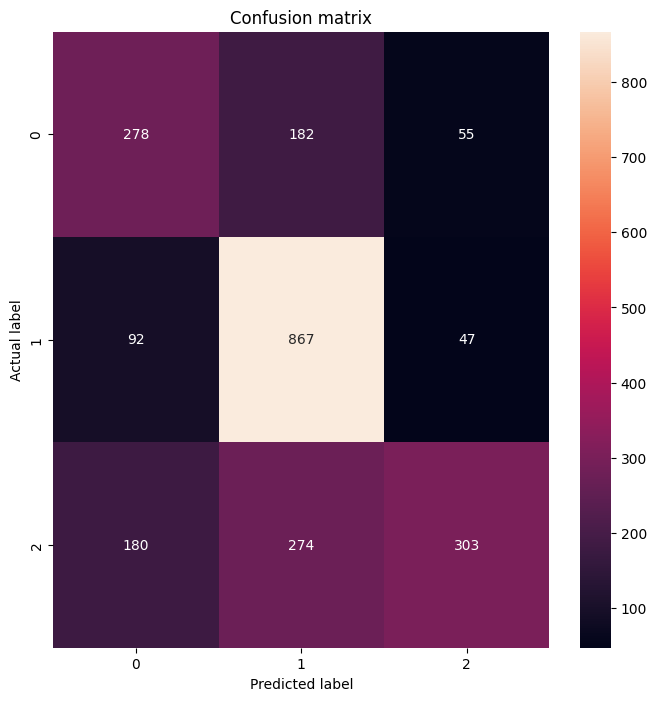

In [ ]:
predicted = []
true_labels = []

for images, labels in tqdm(validation_dataset, desc="Processing validation data"):
    preds = pretrained_model_MobileNetV2.predict(images)
    predicted.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

pred = np.array(predicted)
lab = np.array(true_labels)

cm = confusion_matrix(lab, pred)

wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                                                           y_true=lab,
                                                           preds=pred,
                                                           class_names=CONFIGURATION["CLASS_NAMES"])})

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
